In [2]:
# Audio Processing Script for 4s Classification Preparation
import os
import random
import numpy as np
import pandas as pd
import soundfile as sf
from pathlib import Path
from pydub import AudioSegment
from tqdm import tqdm
from pydub.silence import split_on_silence

import torch
import torchaudio
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from sklearn.preprocessing import MultiLabelBinarizer
from itertools import combinations
from torchaudio import load, save

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Process Audios

In [ ]:
# Configuration
data_root = Path("E:/LSE/ST311/ST311-Group-Project/data/classifier")
processed_root = Path("E:/LSE/ST311/ST311-Group-Project/processed_data")
sample_rate = 16000
random.seed(123)


# Helper functions
def convert_to_wav_and_load(filepath):
    try:
        audio = AudioSegment.from_file(filepath)
        audio = audio.set_frame_rate(sample_rate).set_channels(1)
        return audio
    except Exception as e:
        print(f"Error converting {filepath}: {e}")
        return None

def pad_with_gaussian_noise(audio_segment, target_ms=4000):
    duration = len(audio_segment)
    padding_needed = target_ms - duration
    if padding_needed <= 0:
        return audio_segment
    noise = (np.random.normal(0, 10, int(padding_needed * sample_rate / 1000))
             .astype(np.int16)
             .tobytes())
    noise_segment = AudioSegment(
        noise,
        frame_rate=sample_rate,
        sample_width=2,
        channels=1
    )
    return audio_segment + noise_segment

def save_segment(audio_segment, save_path):
    audio_segment.export(save_path, format="wav")
    
def augment_segment_noise_or_shift(segment, sample_rate=16000, target_ms=4000):
    '''Apply either noise or start-shift augmentation to an audio segment'''
    method = random.choice(["noise", "shift"])
    if method == "noise":
        noise = (np.random.normal(0, 10, len(segment.get_array_of_samples()))
                 .astype(np.int16)
                 .tobytes())
        noise_seg = AudioSegment(
            noise,
            frame_rate=sample_rate,
            sample_width=2,
            channels=1
        )
        return segment.overlay(noise_seg)
    else:  # shift
        max_shift_ms = 500  # shift max 0.5s
        shift = random.randint(100, max_shift_ms)
        silence_padding = AudioSegment.silent(duration=shift)
        shifted = silence_padding + segment
        return shifted[-target_ms:] if len(shifted) > target_ms else shifted

In [8]:
# Process and collect segments
animal_data = {}
def generate_silence(duration_ms):
    return AudioSegment.silent(duration=duration_ms)

for folder in data_root.glob("*"):
    if not folder.is_dir():
        continue
    label = folder.name.lower() # extract labels according to folder name
    if label not in animal_data:
        animal_data[label] = []

    for file in folder.rglob("*.*"):
        if file.suffix.lower() not in [".wav", ".m4a", ".mp3", ".mp4", "mepg"]:
            continue
        audio = convert_to_wav_and_load(file)
        if not audio:
            continue

        chunks = split_on_silence(audio, silence_thresh=-40, min_silence_len=500, keep_silence=100)

        def is_truly_silent(chunk, silence_threshold_db=-40, min_length_ms=1500):
            return len(chunk) >= min_length_ms and chunk.dBFS < silence_threshold_db

        for chunk in chunks:
            if len(chunk) >= 500 and not is_truly_silent(chunk):  # keep chunks whose length equals to or longer than 500ms
                if len(chunk) >= 4000:
                    for i in range(0, len(chunk) - 3999, 4000):
                        seg = chunk[i:i + 4000]
                        animal_data[label].append(seg)
                else:
                    padded = pad_with_gaussian_noise(chunk, 4000)
                    animal_data[label].append(padded)

In [ ]:
# Save all the segments with their labels
csv_entries = []

for label, segments in animal_data.items():
    random.shuffle(segments)
    original_count = len(segments)
    segments_to_save = segments

    # save_dir
    out_dir = processed_root / label
    out_dir.mkdir(parents=True, exist_ok=True)

    print(f"[{label}] original: {original_count}, saved: {len(segments_to_save)}")  # print the number of segments

    for idx, seg in enumerate(segments_to_save):
        name = f"{label}_{idx+1:04d}.wav"
        save_path = out_dir / name
        save_segment(seg, save_path)
        csv_entries.append({"file": name, "label": label})

df = pd.DataFrame(csv_entries)
df.to_csv(processed_root / "dataset.csv", index=False)

[bird] original: 997, saved: 997
[cat] original: 1840, saved: 1840
[cow] original: 393, saved: 393
[dog] original: 1093, saved: 1093
[elephant] original: 672, saved: 672
[horse] original: 735, saved: 735
[lion] original: 683, saved: 683
[sheep] original: 413, saved: 413


# Prepare Dataest

In [3]:
# Split dataset into train/test sets
def create_balanced_splits_from_master(csv_path, max_per_class=700, train_ratio=0.8, seed=123):
    """
    Create train/test CSV splits from a master dataset.csv.
    
    max_per_class: the highest number of samples a class's train set could have (randomly sampled if more)
    """
    df_all = pd.read_csv(csv_path)
    grouped = df_all.groupby('label')

    train_rows = []
    test_rows = []

    for label, group in grouped:
        group = group.sample(frac=1.0, random_state=seed).reset_index(drop=True)
        if len(group) > max_per_class:
            group = group.iloc[:max_per_class]

        split_point = int(len(group) * train_ratio)
        train_rows.extend(group.iloc[:split_point].to_dict('records'))
        test_rows.extend(group.iloc[split_point:].to_dict('records'))

    df_train = pd.DataFrame(train_rows)
    df_test = pd.DataFrame(test_rows)
    
    return df_train, df_test

def prepare_balanced_dataset(master_dataset, split_dir, target_per_class=700, train_ratio=0.8, seed=123):
    """
    Create a balanced train/test split from a master dataset CSV.

    Args:
        processed_root (Path): Path to the root directory where dataset.csv exists.
        target_per_class (int): Max samples per class to keep.
        train_ratio (float): Ratio of data used for training.
        seed (int): Random seed for reproducibility.
    """            
    df_train, df_test = create_balanced_splits_from_master(master_dataset, max_per_class=target_per_class, train_ratio=train_ratio, seed=seed)
    
    df_train.to_csv(split_dir / "train.csv", index=False)
    df_test.to_csv(split_dir / "test.csv", index=False)
    
    train_csv = split_dir / "train.csv"
    test_csv = split_dir / "test.csv"
        
    print(f"Train CSV saved to: {train_csv}")
    print(f"Test CSV saved to: {test_csv}")
    
    return train_csv, test_csv


## Augment on Sheep Data

In [ ]:
csv_path = Path("E:/LSE/ST311/ST311-Group-Project/csv_files")
master_dataset = csv_path / "dataset.csv"

# new destination for augmented data
new_csv_file = csv_path / "dataset_augmented.csv"

# load CSV
master_df = pd.read_csv(master_dataset)
augmented_entries = []

# set augmentation count (30% of the original sheep data)
sheep_df = master_df[master_df['label'] == 'sheep']
augment_count = int(0.5 * len(sheep_df))

def augment_with_noise(filepath):
    waveform, sr = torchaudio.load(filepath)
    noise = 0.02 * torch.randn_like(waveform)
    return waveform + noise, sr

for i in range(augment_count):
    row = sheep_df.sample(n=1).iloc[0]
    filepath = processed_root / row['label'] / row['file']
    waveform_aug, sr = augment_with_noise(filepath)

    new_name = row['file'].replace(".wav", f"_aug{i+1}.wav")
    new_path = processed_root / row['label'] / new_name
    torchaudio.save(new_path.as_posix(), waveform_aug, sr)

    augmented_entries.append({"file": new_name, "label": "sheep"})

df_aug = pd.DataFrame(augmented_entries)
df_combined = pd.concat([df, df_aug], ignore_index=True)
df_combined.to_csv(new_csv_file, index=False)

In [49]:
csv_path = Path("E:/LSE/ST311/ST311-Group-Project/csv_files")
csv_file = csv_path / 'dataset_augmented.csv'
df = pd.read_csv(csv_file)

print(df['label'].value_counts())

label
cat         1840
dog         1093
bird         997
horse        735
lion         683
elephant     672
sheep        619
cow          393
Name: count, dtype: int64


# Build Model

## Model Structure

### ResNet

In [4]:
class ResNetClassifier(nn.Module):
    # Replacing original ResNet18's last layer with a custom classifier for multi-label classification
    def __init__(self, num_classes, use_dropout=False, dropout_rate=0.3):
        super().__init__()
        # Load a pretrained ResNet18 and modify the first and last layers
        resnet = models.resnet18(pretrained=True)
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # remove last layer(avg pool and fc) because we will use our own mlb classifier

        layers = [
            nn.Flatten(),# (B, 512, 1, 1) -> (B, 512)
            nn.Linear(512, 256),
            nn.ReLU()# apply ReLU activation function to introduce non-linearity
        ]
        if use_dropout:
            layers.append(nn.Dropout(p=dropout_rate))
        layers.append(nn.Linear(256, num_classes))# output logits for BCEWithLogitsLoss
        
        self.classifier = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

### ResNet with Transformer

In [5]:
class ResNetTransformerClassifier(nn.Module):
    # The ResNet backbone is used to extract features from the spectrograms, and the transformer processes the sequence of features
    def __init__(self, num_classes, transformer_dim=512, 
                 num_heads=4, num_layers=2, use_dropout=False, dropout_rate=0.3):
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])# remove the last two layers since we only need the feature extractor
        # average pool is more stable and robust than max pool for the transformer input
        self.pool = nn.AdaptiveAvgPool2d((32, 1))# reduce the feature map to (32, 1) to match the transformer input size
        self.flatten = nn.Flatten(2)# flatten to (batch_size, feature_dim, seq_len)
        self.transpose = lambda x: x.transpose(1, 2)# transpose to (batch_size, seq_len, feature_dim)
                
        # build the transformer encoder with self-attention mechanism and feed-forward network
        encoder_layer = nn.TransformerEncoderLayer(d_model=transformer_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        layers = [
            nn.Linear(transformer_dim, 256),
            nn.ReLU()
        ]
        if use_dropout:
            layers.append(nn.Dropout(p=dropout_rate))
        layers.append(nn.Linear(256, num_classes))

        self.classifier = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.backbone(x)
        # transform feature map to (batch_size, seq_len, feature_dim) for transformer input
        x = self.pool(x)
        x = self.flatten(x)
        x = self.transpose(x)
        x = self.transformer(x)
        x = x.mean(dim=1)# averaging the features across the sequence length
        x = self.classifier(x)
        return x

## Metrics

In [6]:
# Metrics function
def compute_ap(y_true, y_score):
    """
    Compute average precision for one class using torch only.
    """
    # Sort by predicted score
    sorted_indices = torch.argsort(y_score, descending=True)
    y_true = y_true[sorted_indices]

    correct = 0
    total = 0
    precision_sum = 0

    for i in range(len(y_true)):
        if y_true[i] == 1:
            correct += 1
            precision = correct / (i + 1)
            precision_sum += precision
            total += 1

    if total == 0:
        return torch.tensor(0.0)
    return precision_sum / total

def multilabel_metrics(y_pred, y_true, threshold=0.5, eps=1e-8):
    y_pred = torch.sigmoid(y_pred)
    y_pred_bin = (y_pred > threshold).float()

    tp = (y_pred_bin * y_true).sum(dim=0)
    fp = (y_pred_bin * (1 - y_true)).sum(dim=0)
    fn = ((1 - y_pred_bin) * y_true).sum(dim=0)

    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)

    # Compute mAP (pure torch version)
    macro_ap = 0
    for i in range(y_true.size(1)):  # for each class
        ap = compute_ap(y_true[:, i], y_pred[:, i])
        macro_ap += ap
    macro_ap /= y_true.size(1)

    return (
        precision.mean().item(),
        recall.mean().item(),
        f1.mean().item(),
        macro_ap,
        precision,
        recall,
        f1
    )

## Load Data and Set Configuration

In [8]:
n_mels = 128
n_fft = 1024
hop_length = 512
target_duration_sec = 4
sample_rate = 16000
target_length = sample_rate * target_duration_sec

# Preprocessing transforms
mel_transform = nn.Sequential(
    MelSpectrogram(sample_rate=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels),
    AmplitudeToDB()
)

class AudioDataset(Dataset):
    def __init__(self, the_df, audio_dir, label_matrix, input_length):
        self.df = the_df
        self.audio_dir = audio_dir
        self.label_matrix = torch.tensor(label_matrix, dtype=torch.float32)
        self.input_length = input_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        if '_mix_' in row['file']:
            filepath = self.audio_dir / "mixed" / row['file']
        else:
            filepath = self.audio_dir / row['label'] / row['file']
        waveform, sr = torchaudio.load(filepath)
        if waveform.shape[1] < self.input_length:
            waveform = torch.nn.functional.pad(waveform, (0, self.input_length - waveform.shape[1]))
        elif waveform.shape[1] > self.input_length:
            waveform = waveform[:, :self.input_length]
        mel_spec = mel_transform(waveform).squeeze(0)
        label_vec = self.label_matrix[idx]
        return mel_spec.unsqueeze(0), label_vec
    
def setup_dataloaders(train_csv_path, test_csv_path, audio_root, batch_size=16, val_ratio=0.1, input_length=64000):
    df_all = pd.read_csv(train_csv_path)
    df_all['label_list'] = df_all['label'].str.split(',')

    mlb = MultiLabelBinarizer()
    label_matrix_all = mlb.fit_transform(df_all['label_list'])

    # Shuffle both df_all and label_matrix_all in the same order
    shuffled_indices = np.random.RandomState(seed=123).permutation(len(df_all))
    df_all = df_all.iloc[shuffled_indices].reset_index(drop=True)
    label_matrix_all = label_matrix_all[shuffled_indices]

    # Split
    split_point = int(len(df_all) * (1 - val_ratio))
    df_train = df_all.iloc[:split_point].reset_index(drop=True)
    df_val = df_all.iloc[split_point:].reset_index(drop=True)

    label_matrix_train = label_matrix_all[:split_point]
    label_matrix_val = label_matrix_all[split_point:]

    train_set = AudioDataset(df_train, audio_root, label_matrix_train, input_length)
    val_set = AudioDataset(df_val, audio_root, label_matrix_val, input_length)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)

    df_test = pd.read_csv(test_csv_path)
    df_test['label_list'] = df_test['label'].str.split(',')
    label_matrix_test = mlb.transform(df_test['label_list'])

    test_set = AudioDataset(df_test, audio_root, label_matrix_test, input_length)
    test_loader = DataLoader(test_set, batch_size=batch_size)

    return train_loader, val_loader, test_loader, mlb.classes_, label_matrix_train


# Training

## ResNet TransformerClassifier

Batch size = 32, learning rate = 1e-4

In [171]:
target_per_class = 700
train_ratio = 0.8

aug_split_dir = csv_path / "augmented_splits"

a_train_csv, a_test_csv = prepare_balanced_dataset(master_dataset=new_csv_file,
                                               split_dir=aug_split_dir,
                                               target_per_class=target_per_class, train_ratio=train_ratio)

num_epochs = 100
early_stop_patience = 10
learning_rate = 1e-4
batch_size = 32

train_loader, val_loader, test_loader,all_labels, train_label_matrix = setup_dataloaders(
    train_csv_path=a_train_csv,
    test_csv_path=a_test_csv,
    audio_root=processed_root,
    batch_size=batch_size,
    val_ratio=0.1
)

label_to_index = {label: i for i, label in enumerate(all_labels)}
index_to_label = {i: label for i, label in enumerate(all_labels)}

label_counts = train_label_matrix.sum(axis=0)
total_samples = train_label_matrix.shape[0]
num_classes = train_label_matrix.shape[1]

pos_weight = total_samples / (label_counts)
pos_weight = torch.tensor(pos_weight, dtype=torch.float32).to(device)

# Model
model = ResNetTransformerClassifier(num_classes).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Train CSV saved to: E:\LSE\ST311\ST311-Group-Project\csv_files\augmented_splits\train.csv
Test CSV saved to: E:\LSE\ST311\ST311-Group-Project\csv_files\augmented_splits\test.csv


d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [172]:
model_save_dir = Path("E:/LSE/ST311/ST311-Group-Project/experiment/aug_restran")
model_save_dir.mkdir(parents=True, exist_ok=True)
best_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, targets in loop:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=total_loss / (loop.n + 1))

    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_preds.append(outputs)
            all_targets.append(targets)

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    val_loss = criterion(all_preds, all_targets).item()
    macro_p, macro_r, macro_f1, macro_map, p_class, r_class, f_class = multilabel_metrics(all_preds, all_targets)

    print(f"Val Loss: {val_loss:.4f}, Map:{round(macro_map,4)}, Macro P: {macro_p:.4f}, R: {macro_r:.4f}, F1: {macro_f1:.4f}")
    print("Per-class F1:")
    for i, label in index_to_label.items():
        print(f"  {label}: P={p_class[i]:.3f}, R={r_class[i]:.3f}, F1={f_class[i]:.3f}")

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), model_save_dir / f"resnet_transformer_f1_{macro_f1:.4f}.pth")
        print("Saved best model.")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{early_stop_patience}")

    if patience_counter >= early_stop_patience:
        print("Early stopping.")
        break


Epoch 1/100:   0%|          | 0/117 [00:00<?, ?it/s]

Epoch 1/100: 100%|██████████| 117/117 [00:15<00:00,  7.69it/s, loss=0.645]


Val Loss: 0.3523, Map:0.9317, Macro P: 0.7071, R: 0.9297, F1: 0.7951
Per-class F1:
  bird: P=0.891, R=0.934, F1=0.912
  cat: P=0.730, R=0.885, F1=0.800
  cow: P=0.550, R=1.000, F1=0.710
  dog: P=0.783, R=0.922, F1=0.847
  elephant: P=0.759, R=0.804, F1=0.781
  horse: P=0.747, R=0.937, F1=0.831
  lion: P=0.679, R=1.000, F1=0.809
  sheep: P=0.518, R=0.957, F1=0.672
Saved best model.


Epoch 2/100: 100%|██████████| 117/117 [00:14<00:00,  7.84it/s, loss=0.233]


Val Loss: 0.2342, Map:0.9653, Macro P: 0.8268, R: 0.9543, F1: 0.8811
Per-class F1:
  bird: P=0.934, R=0.934, F1=0.934
  cat: P=0.758, R=0.962, F1=0.847
  cow: P=0.912, R=0.939, F1=0.925
  dog: P=0.904, R=0.922, F1=0.913
  elephant: P=0.685, R=0.980, F1=0.806
  horse: P=0.697, R=0.984, F1=0.816
  lion: P=0.792, R=1.000, F1=0.884
  sheep: P=0.933, R=0.913, F1=0.923
Saved best model.


Epoch 3/100: 100%|██████████| 117/117 [00:15<00:00,  7.70it/s, loss=0.127]


Val Loss: 0.2010, Map:0.9645, Macro P: 0.8465, R: 0.9626, F1: 0.8987
Per-class F1:
  bird: P=1.000, R=0.967, F1=0.983
  cat: P=0.696, R=0.923, F1=0.793
  cow: P=0.909, R=0.909, F1=0.909
  dog: P=0.817, R=0.961, F1=0.883
  elephant: P=0.823, R=1.000, F1=0.903
  horse: P=0.805, R=0.984, F1=0.886
  lion: P=0.877, R=1.000, F1=0.934
  sheep: P=0.846, R=0.957, F1=0.898
Saved best model.


Epoch 4/100: 100%|██████████| 117/117 [00:15<00:00,  7.74it/s, loss=0.113]


Val Loss: 0.1645, Map:0.9798, Macro P: 0.8612, R: 0.9611, F1: 0.9027
Per-class F1:
  bird: P=0.935, R=0.951, F1=0.943
  cat: P=0.959, R=0.904, F1=0.931
  cow: P=0.600, R=1.000, F1=0.750
  dog: P=0.942, R=0.961, F1=0.951
  elephant: P=0.980, R=0.980, F1=0.980
  horse: P=0.808, R=0.937, F1=0.868
  lion: P=0.864, R=1.000, F1=0.927
  sheep: P=0.800, R=0.957, F1=0.871
Saved best model.


Epoch 5/100: 100%|██████████| 117/117 [00:15<00:00,  7.68it/s, loss=0.0839]


Val Loss: 0.1198, Map:0.9859, Macro P: 0.8902, R: 0.9813, F1: 0.9327
Per-class F1:
  bird: P=0.968, R=0.984, F1=0.976
  cat: P=0.909, R=0.962, F1=0.935
  cow: P=0.892, R=1.000, F1=0.943
  dog: P=0.862, R=0.980, F1=0.917
  elephant: P=0.806, R=0.980, F1=0.885
  horse: P=0.838, R=0.984, F1=0.905
  lion: P=0.889, R=0.982, F1=0.933
  sheep: P=0.957, R=0.978, F1=0.968
Saved best model.


Epoch 6/100: 100%|██████████| 117/117 [00:14<00:00,  7.81it/s, loss=0.0834]


Val Loss: 0.1750, Map:0.9723, Macro P: 0.8697, R: 0.9553, F1: 0.9093
Per-class F1:
  bird: P=0.984, R=0.984, F1=0.984
  cat: P=0.926, R=0.962, F1=0.943
  cow: P=0.775, R=0.939, F1=0.849
  dog: P=0.891, R=0.961, F1=0.925
  elephant: P=0.904, R=0.922, F1=0.913
  horse: P=0.831, R=0.937, F1=0.881
  lion: P=0.875, R=0.982, F1=0.926
  sheep: P=0.772, R=0.957, F1=0.854
No improvement. Patience: 1/10


Epoch 7/100: 100%|██████████| 117/117 [00:15<00:00,  7.77it/s, loss=0.049] 


Val Loss: 0.1907, Map:0.976, Macro P: 0.9050, R: 0.9499, F1: 0.9262
Per-class F1:
  bird: P=0.935, R=0.951, F1=0.943
  cat: P=0.941, R=0.923, F1=0.932
  cow: P=0.914, R=0.970, F1=0.941
  dog: P=0.889, R=0.941, F1=0.914
  elephant: P=0.962, R=1.000, F1=0.981
  horse: P=0.831, R=0.937, F1=0.881
  lion: P=0.833, R=0.965, F1=0.894
  sheep: P=0.933, R=0.913, F1=0.923
No improvement. Patience: 2/10


Epoch 8/100: 100%|██████████| 117/117 [00:15<00:00,  7.65it/s, loss=0.0508]


Val Loss: 0.1610, Map:0.9809, Macro P: 0.9081, R: 0.9597, F1: 0.9310
Per-class F1:
  bird: P=0.937, R=0.967, F1=0.952
  cat: P=0.941, R=0.923, F1=0.932
  cow: P=0.786, R=1.000, F1=0.880
  dog: P=0.926, R=0.980, F1=0.952
  elephant: P=0.877, R=0.980, F1=0.926
  horse: P=0.909, R=0.952, F1=0.930
  lion: P=0.889, R=0.982, F1=0.933
  sheep: P=1.000, R=0.891, F1=0.943
No improvement. Patience: 3/10


Epoch 9/100: 100%|██████████| 117/117 [00:15<00:00,  7.48it/s, loss=0.0407]


Val Loss: 0.1758, Map:0.9894, Macro P: 0.8983, R: 0.9555, F1: 0.9233
Per-class F1:
  bird: P=0.966, R=0.934, F1=0.950
  cat: P=1.000, R=0.904, F1=0.949
  cow: P=0.914, R=0.970, F1=0.941
  dog: P=0.941, R=0.941, F1=0.941
  elephant: P=0.806, R=0.980, F1=0.885
  horse: P=0.922, R=0.937, F1=0.929
  lion: P=0.803, R=1.000, F1=0.891
  sheep: P=0.833, R=0.978, F1=0.900
No improvement. Patience: 4/10


Epoch 10/100: 100%|██████████| 117/117 [00:15<00:00,  7.44it/s, loss=0.0466]


Val Loss: 0.1713, Map:0.9716, Macro P: 0.8996, R: 0.9610, F1: 0.9273
Per-class F1:
  bird: P=0.952, R=0.967, F1=0.959
  cat: P=1.000, R=0.885, F1=0.939
  cow: P=0.941, R=0.970, F1=0.955
  dog: P=0.828, R=0.941, F1=0.881
  elephant: P=0.906, R=0.941, F1=0.923
  horse: P=0.886, R=0.984, F1=0.932
  lion: P=0.864, R=1.000, F1=0.927
  sheep: P=0.821, R=1.000, F1=0.902
No improvement. Patience: 5/10


Epoch 11/100: 100%|██████████| 117/117 [00:15<00:00,  7.48it/s, loss=0.0445]


Val Loss: 0.1730, Map:0.983, Macro P: 0.9118, R: 0.9514, F1: 0.9307
Per-class F1:
  bird: P=0.951, R=0.951, F1=0.951
  cat: P=0.920, R=0.885, F1=0.902
  cow: P=0.943, R=1.000, F1=0.971
  dog: P=0.907, R=0.961, F1=0.933
  elephant: P=0.902, R=0.902, F1=0.902
  horse: P=0.882, R=0.952, F1=0.916
  lion: P=0.889, R=0.982, F1=0.933
  sheep: P=0.900, R=0.978, F1=0.938
No improvement. Patience: 6/10


Epoch 12/100: 100%|██████████| 117/117 [00:15<00:00,  7.46it/s, loss=0.0282]


Val Loss: 0.1758, Map:0.9834, Macro P: 0.9185, R: 0.9566, F1: 0.9362
Per-class F1:
  bird: P=0.967, R=0.967, F1=0.967
  cat: P=0.940, R=0.904, F1=0.922
  cow: P=0.825, R=1.000, F1=0.904
  dog: P=0.942, R=0.961, F1=0.951
  elephant: P=0.926, R=0.980, F1=0.952
  horse: P=0.881, R=0.937, F1=0.908
  lion: P=0.931, R=0.947, F1=0.939
  sheep: P=0.936, R=0.957, F1=0.946
No improvement. Patience: 7/10


Epoch 13/100: 100%|██████████| 117/117 [00:15<00:00,  7.45it/s, loss=0.0198]


Val Loss: 0.1948, Map:0.9847, Macro P: 0.8847, R: 0.9519, F1: 0.9150
Per-class F1:
  bird: P=1.000, R=0.902, F1=0.948
  cat: P=0.847, R=0.962, F1=0.901
  cow: P=0.917, R=1.000, F1=0.957
  dog: P=0.923, R=0.941, F1=0.932
  elephant: P=0.781, R=0.980, F1=0.870
  horse: P=0.891, R=0.905, F1=0.898
  lion: P=0.885, R=0.947, F1=0.915
  sheep: P=0.833, R=0.978, F1=0.900
No improvement. Patience: 8/10


Epoch 14/100: 100%|██████████| 117/117 [00:15<00:00,  7.41it/s, loss=0.0648]


Val Loss: 0.2363, Map:0.9765, Macro P: 0.8533, R: 0.9392, F1: 0.8917
Per-class F1:
  bird: P=0.949, R=0.918, F1=0.933
  cat: P=0.920, R=0.885, F1=0.902
  cow: P=0.780, R=0.970, F1=0.865
  dog: P=0.860, R=0.961, F1=0.907
  elephant: P=0.923, R=0.941, F1=0.932
  horse: P=0.756, R=0.984, F1=0.855
  lion: P=0.820, R=0.877, F1=0.847
  sheep: P=0.818, R=0.978, F1=0.891
No improvement. Patience: 9/10


Epoch 15/100: 100%|██████████| 117/117 [00:15<00:00,  7.47it/s, loss=0.0508]


Val Loss: 0.0948, Map:0.9881, Macro P: 0.9171, R: 0.9821, F1: 0.9477
Per-class F1:
  bird: P=0.968, R=0.984, F1=0.976
  cat: P=0.961, R=0.942, F1=0.951
  cow: P=0.892, R=1.000, F1=0.943
  dog: P=0.943, R=0.980, F1=0.962
  elephant: P=0.879, R=1.000, F1=0.936
  horse: P=0.938, R=0.968, F1=0.953
  lion: P=0.903, R=0.982, F1=0.941
  sheep: P=0.852, R=1.000, F1=0.920
Saved best model.


Epoch 16/100: 100%|██████████| 117/117 [00:18<00:00,  6.40it/s, loss=0.0504]


Val Loss: 0.1462, Map:0.9848, Macro P: 0.8958, R: 0.9655, F1: 0.9273
Per-class F1:
  bird: P=0.983, R=0.967, F1=0.975
  cat: P=0.980, R=0.942, F1=0.961
  cow: P=0.914, R=0.970, F1=0.941
  dog: P=0.925, R=0.961, F1=0.942
  elephant: P=0.773, R=1.000, F1=0.872
  horse: P=0.855, R=0.937, F1=0.894
  lion: P=0.915, R=0.947, F1=0.931
  sheep: P=0.821, R=1.000, F1=0.902
No improvement. Patience: 1/10


Epoch 17/100: 100%|██████████| 117/117 [00:16<00:00,  7.27it/s, loss=0.011] 


Val Loss: 0.1290, Map:0.9922, Macro P: 0.9292, R: 0.9666, F1: 0.9468
Per-class F1:
  bird: P=0.984, R=0.984, F1=0.984
  cat: P=0.980, R=0.923, F1=0.950
  cow: P=0.842, R=0.970, F1=0.901
  dog: P=0.906, R=0.941, F1=0.923
  elephant: P=0.962, R=0.980, F1=0.971
  horse: P=0.923, R=0.952, F1=0.938
  lion: P=0.918, R=0.982, F1=0.949
  sheep: P=0.920, R=1.000, F1=0.958
No improvement. Patience: 2/10


Epoch 18/100: 100%|██████████| 117/117 [00:15<00:00,  7.44it/s, loss=0.00784]


Val Loss: 0.1297, Map:0.9927, Macro P: 0.9448, R: 0.9747, F1: 0.9586
Per-class F1:
  bird: P=0.967, R=0.951, F1=0.959
  cat: P=1.000, R=0.923, F1=0.960
  cow: P=0.971, R=1.000, F1=0.985
  dog: P=0.942, R=0.961, F1=0.951
  elephant: P=0.943, R=0.980, F1=0.962
  horse: P=0.863, R=1.000, F1=0.926
  lion: P=0.933, R=0.982, F1=0.957
  sheep: P=0.939, R=1.000, F1=0.968
No improvement. Patience: 3/10


Epoch 19/100: 100%|██████████| 117/117 [00:16<00:00,  7.26it/s, loss=0.0237]


Val Loss: 0.1214, Map:0.9893, Macro P: 0.9362, R: 0.9754, F1: 0.9550
Per-class F1:
  bird: P=0.983, R=0.951, F1=0.967
  cat: P=0.891, R=0.942, F1=0.916
  cow: P=0.943, R=1.000, F1=0.971
  dog: P=0.909, R=0.980, F1=0.943
  elephant: P=0.962, R=0.980, F1=0.971
  horse: P=0.899, R=0.984, F1=0.939
  lion: P=0.965, R=0.965, F1=0.965
  sheep: P=0.939, R=1.000, F1=0.968
No improvement. Patience: 4/10


Epoch 20/100: 100%|██████████| 117/117 [00:15<00:00,  7.41it/s, loss=0.00536]


Val Loss: 0.1267, Map:0.9917, Macro P: 0.9487, R: 0.9707, F1: 0.9589
Per-class F1:
  bird: P=1.000, R=0.951, F1=0.975
  cat: P=0.941, R=0.923, F1=0.932
  cow: P=0.892, R=1.000, F1=0.943
  dog: P=0.907, R=0.961, F1=0.933
  elephant: P=0.962, R=1.000, F1=0.981
  horse: P=0.952, R=0.952, F1=0.952
  lion: P=0.934, R=1.000, F1=0.966
  sheep: P=1.000, R=0.978, F1=0.989
No improvement. Patience: 5/10


Epoch 21/100: 100%|██████████| 117/117 [00:15<00:00,  7.38it/s, loss=0.0127] 


Val Loss: 0.1155, Map:0.995, Macro P: 0.9325, R: 0.9736, F1: 0.9509
Per-class F1:
  bird: P=0.983, R=0.967, F1=0.975
  cat: P=0.961, R=0.942, F1=0.951
  cow: P=1.000, R=0.970, F1=0.985
  dog: P=0.769, R=0.980, F1=0.862
  elephant: P=0.895, R=1.000, F1=0.944
  horse: P=0.968, R=0.968, F1=0.968
  lion: P=0.966, R=0.982, F1=0.974
  sheep: P=0.918, R=0.978, F1=0.947
No improvement. Patience: 6/10


Epoch 22/100: 100%|██████████| 117/117 [00:16<00:00,  7.24it/s, loss=0.00938]


Val Loss: 0.1697, Map:0.9903, Macro P: 0.9483, R: 0.9642, F1: 0.9560
Per-class F1:
  bird: P=0.983, R=0.951, F1=0.967
  cat: P=0.925, R=0.942, F1=0.933
  cow: P=0.941, R=0.970, F1=0.955
  dog: P=0.961, R=0.961, F1=0.961
  elephant: P=1.000, R=1.000, F1=1.000
  horse: P=0.924, R=0.968, F1=0.946
  lion: P=0.917, R=0.965, F1=0.940
  sheep: P=0.936, R=0.957, F1=0.946
No improvement. Patience: 7/10


Epoch 23/100: 100%|██████████| 117/117 [00:15<00:00,  7.36it/s, loss=0.0265]


Val Loss: 0.0971, Map:0.9918, Macro P: 0.9461, R: 0.9797, F1: 0.9619
Per-class F1:
  bird: P=0.983, R=0.951, F1=0.967
  cat: P=0.961, R=0.942, F1=0.951
  cow: P=0.971, R=1.000, F1=0.985
  dog: P=0.864, R=1.000, F1=0.927
  elephant: P=0.911, R=1.000, F1=0.953
  horse: P=0.939, R=0.984, F1=0.961
  lion: P=0.982, R=0.982, F1=0.982
  sheep: P=0.957, R=0.978, F1=0.968
No improvement. Patience: 8/10


Epoch 24/100: 100%|██████████| 117/117 [00:15<00:00,  7.48it/s, loss=0.0282]


Val Loss: 0.2854, Map:0.9644, Macro P: 0.9016, R: 0.9427, F1: 0.9183
Per-class F1:
  bird: P=0.966, R=0.934, F1=0.950
  cat: P=0.959, R=0.904, F1=0.931
  cow: P=1.000, R=0.848, F1=0.918
  dog: P=0.833, R=0.980, F1=0.901
  elephant: P=0.909, R=0.980, F1=0.943
  horse: P=0.897, R=0.968, F1=0.931
  lion: P=0.885, R=0.947, F1=0.915
  sheep: P=0.763, R=0.978, F1=0.857
No improvement. Patience: 9/10


Epoch 25/100: 100%|██████████| 117/117 [00:15<00:00,  7.50it/s, loss=0.0268]


Val Loss: 0.2450, Map:0.9712, Macro P: 0.9160, R: 0.9517, F1: 0.9326
Per-class F1:
  bird: P=0.938, R=0.984, F1=0.960
  cat: P=0.940, R=0.904, F1=0.922
  cow: P=0.912, R=0.939, F1=0.925
  dog: P=0.847, R=0.980, F1=0.909
  elephant: P=0.943, R=0.980, F1=0.962
  horse: P=0.966, R=0.905, F1=0.934
  lion: P=0.902, R=0.965, F1=0.932
  sheep: P=0.880, R=0.957, F1=0.917
No improvement. Patience: 10/10
Early stopping.


## ResNetTransformer Classifier with dropout

Batch size = 32, learning rate = 1e-4, dropout rate = 0.3

In case we will need to solve overfitting issue in second stage, we also trained the models with dropout to ensure there are corresponding weights

In [198]:
model = ResNetTransformerClassifier(num_classes,use_dropout=True).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model_save_dir = Path("E:/LSE/ST311/ST311-Group-Project/experiment/aug_restran")
model_save_dir.mkdir(parents=True, exist_ok=True)
best_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, targets in loop:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=total_loss / (loop.n + 1))

    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_preds.append(outputs)
            all_targets.append(targets)

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    val_loss = criterion(all_preds, all_targets).item()
    macro_p, macro_r, macro_f1, macro_map, p_class, r_class, f_class = multilabel_metrics(all_preds, all_targets)

    print(f"Val Loss: {val_loss:.4f}, Map:{round(macro_map,4)}, Macro P: {macro_p:.4f}, R: {macro_r:.4f}, F1: {macro_f1:.4f}")
    print("Per-class F1:")
    for i, label in index_to_label.items():
        print(f"  {label}: P={p_class[i]:.3f}, R={r_class[i]:.3f}, F1={f_class[i]:.3f}")

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), model_save_dir / f"resnet_transformer_dp_f1_{macro_f1:.4f}.pth")
        print("Saved best model.")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{early_stop_patience}")

    if patience_counter >= early_stop_patience:
        print("Early stopping.")
        break


d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/100: 100%|██████████| 117/117 [00:14<00:00,  8.01it/s, loss=0.663]


Val Loss: 0.3281, Map:0.9549, Macro P: 0.7161, R: 0.9516, F1: 0.7998
Per-class F1:
  bird: P=0.847, R=1.000, F1=0.917
  cat: P=0.836, R=0.885, F1=0.860
  cow: P=0.471, R=1.000, F1=0.641
  dog: P=0.957, R=0.882, F1=0.918
  elephant: P=0.640, R=0.941, F1=0.762
  horse: P=0.864, R=0.905, F1=0.884
  lion: P=0.671, R=1.000, F1=0.803
  sheep: P=0.442, R=1.000, F1=0.613
Saved best model.


Epoch 2/100: 100%|██████████| 117/117 [00:14<00:00,  7.93it/s, loss=0.245]


Val Loss: 0.2419, Map:0.9555, Macro P: 0.7889, R: 0.9490, F1: 0.8559
Per-class F1:
  bird: P=0.967, R=0.967, F1=0.967
  cat: P=0.727, R=0.923, F1=0.814
  cow: P=0.516, R=0.970, F1=0.674
  dog: P=0.803, R=0.961, F1=0.875
  elephant: P=0.845, R=0.961, F1=0.899
  horse: P=0.787, R=0.937, F1=0.855
  lion: P=0.862, R=0.982, F1=0.918
  sheep: P=0.804, R=0.891, F1=0.845
Saved best model.


Epoch 3/100: 100%|██████████| 117/117 [00:14<00:00,  7.85it/s, loss=0.156]


Val Loss: 0.1508, Map:0.9825, Macro P: 0.8783, R: 0.9647, F1: 0.9185
Per-class F1:
  bird: P=0.897, R=1.000, F1=0.946
  cat: P=0.918, R=0.865, F1=0.891
  cow: P=0.892, R=1.000, F1=0.943
  dog: P=0.862, R=0.980, F1=0.917
  elephant: P=0.926, R=0.980, F1=0.952
  horse: P=0.845, R=0.952, F1=0.896
  lion: P=0.824, R=0.982, F1=0.896
  sheep: P=0.863, R=0.957, F1=0.907
Saved best model.


Epoch 4/100: 100%|██████████| 117/117 [00:15<00:00,  7.72it/s, loss=0.127]


Val Loss: 0.1363, Map:0.981, Macro P: 0.8833, R: 0.9669, F1: 0.9217
Per-class F1:
  bird: P=1.000, R=0.967, F1=0.983
  cat: P=0.821, R=0.885, F1=0.852
  cow: P=0.917, R=1.000, F1=0.957
  dog: P=0.877, R=0.980, F1=0.926
  elephant: P=0.810, R=1.000, F1=0.895
  horse: P=0.924, R=0.968, F1=0.946
  lion: P=0.803, R=1.000, F1=0.891
  sheep: P=0.915, R=0.935, F1=0.925
Saved best model.


Epoch 5/100: 100%|██████████| 117/117 [00:15<00:00,  7.49it/s, loss=0.0591]


Val Loss: 0.1577, Map:0.9823, Macro P: 0.9113, R: 0.9625, F1: 0.9358
Per-class F1:
  bird: P=0.924, R=1.000, F1=0.961
  cat: P=0.906, R=0.923, F1=0.914
  cow: P=0.889, R=0.970, F1=0.928
  dog: P=0.906, R=0.941, F1=0.923
  elephant: P=0.911, R=1.000, F1=0.953
  horse: P=0.873, R=0.984, F1=0.925
  lion: P=0.947, R=0.947, F1=0.947
  sheep: P=0.935, R=0.935, F1=0.935
No improvement. Patience: 1/10


Epoch 6/100: 100%|██████████| 117/117 [00:15<00:00,  7.79it/s, loss=0.0498]


Val Loss: 0.2462, Map:0.9508, Macro P: 0.9003, R: 0.9387, F1: 0.9165
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.776, R=0.865, F1=0.818
  cow: P=0.909, R=0.909, F1=0.909
  dog: P=0.906, R=0.941, F1=0.923
  elephant: P=0.895, R=1.000, F1=0.944
  horse: P=0.827, R=0.984, F1=0.899
  lion: P=0.891, R=1.000, F1=0.942
  sheep: P=1.000, R=0.826, F1=0.905
No improvement. Patience: 2/10


Epoch 7/100: 100%|██████████| 117/117 [00:15<00:00,  7.70it/s, loss=0.0887]


Val Loss: 0.1612, Map:0.9822, Macro P: 0.9080, R: 0.9661, F1: 0.9345
Per-class F1:
  bird: P=0.938, R=1.000, F1=0.968
  cat: P=0.959, R=0.904, F1=0.931
  cow: P=0.825, R=1.000, F1=0.904
  dog: P=0.891, R=0.961, F1=0.925
  elephant: P=0.925, R=0.961, F1=0.942
  horse: P=0.910, R=0.968, F1=0.938
  lion: P=0.838, R=1.000, F1=0.912
  sheep: P=0.977, R=0.935, F1=0.956
No improvement. Patience: 3/10


Epoch 8/100: 100%|██████████| 117/117 [00:15<00:00,  7.76it/s, loss=0.0891]


Val Loss: 0.1586, Map:0.9834, Macro P: 0.9173, R: 0.9614, F1: 0.9376
Per-class F1:
  bird: P=0.968, R=1.000, F1=0.984
  cat: P=0.907, R=0.942, F1=0.925
  cow: P=0.889, R=0.970, F1=0.928
  dog: P=0.847, R=0.980, F1=0.909
  elephant: P=0.907, R=0.961, F1=0.933
  horse: P=0.938, R=0.968, F1=0.953
  lion: P=0.905, R=1.000, F1=0.950
  sheep: P=0.976, R=0.870, F1=0.920
No improvement. Patience: 4/10


Epoch 9/100: 100%|██████████| 117/117 [00:16<00:00,  7.28it/s, loss=0.0484]


Val Loss: 0.2577, Map:0.9758, Macro P: 0.8887, R: 0.9393, F1: 0.9092
Per-class F1:
  bird: P=0.984, R=0.984, F1=0.984
  cat: P=0.978, R=0.865, F1=0.918
  cow: P=0.969, R=0.939, F1=0.954
  dog: P=0.923, R=0.941, F1=0.932
  elephant: P=0.781, R=0.980, F1=0.870
  horse: P=0.765, R=0.984, F1=0.861
  lion: P=0.906, R=0.842, F1=0.873
  sheep: P=0.804, R=0.978, F1=0.882
No improvement. Patience: 5/10


Epoch 10/100: 100%|██████████| 117/117 [00:16<00:00,  7.19it/s, loss=0.0377]


Val Loss: 0.1543, Map:0.9833, Macro P: 0.9197, R: 0.9688, F1: 0.9429
Per-class F1:
  bird: P=0.924, R=1.000, F1=0.961
  cat: P=0.960, R=0.923, F1=0.941
  cow: P=0.892, R=1.000, F1=0.943
  dog: P=0.959, R=0.922, F1=0.940
  elephant: P=0.911, R=1.000, F1=0.953
  horse: P=0.912, R=0.984, F1=0.947
  lion: P=0.902, R=0.965, F1=0.932
  sheep: P=0.898, R=0.957, F1=0.926
No improvement. Patience: 6/10


Epoch 11/100: 100%|██████████| 117/117 [00:16<00:00,  7.22it/s, loss=0.0332]


Val Loss: 0.2064, Map:0.9809, Macro P: 0.9258, R: 0.9645, F1: 0.9433
Per-class F1:
  bird: P=0.938, R=1.000, F1=0.968
  cat: P=1.000, R=0.865, F1=0.928
  cow: P=0.943, R=1.000, F1=0.971
  dog: P=0.845, R=0.961, F1=0.899
  elephant: P=0.927, R=1.000, F1=0.962
  horse: P=0.871, R=0.968, F1=0.917
  lion: P=0.965, R=0.965, F1=0.965
  sheep: P=0.917, R=0.957, F1=0.936
No improvement. Patience: 7/10


Epoch 12/100: 100%|██████████| 117/117 [00:15<00:00,  7.61it/s, loss=0.0291]


Val Loss: 0.3385, Map:0.9423, Macro P: 0.8866, R: 0.9349, F1: 0.9087
Per-class F1:
  bird: P=0.953, R=1.000, F1=0.976
  cat: P=0.960, R=0.923, F1=0.941
  cow: P=0.875, R=0.848, F1=0.862
  dog: P=0.906, R=0.941, F1=0.923
  elephant: P=0.877, R=0.980, F1=0.926
  horse: P=0.857, R=0.952, F1=0.902
  lion: P=0.893, R=0.877, F1=0.885
  sheep: P=0.772, R=0.957, F1=0.854
No improvement. Patience: 8/10


Epoch 13/100: 100%|██████████| 117/117 [00:15<00:00,  7.41it/s, loss=0.0437]


Val Loss: 0.1613, Map:0.9792, Macro P: 0.9274, R: 0.9675, F1: 0.9464
Per-class F1:
  bird: P=1.000, R=0.967, F1=0.983
  cat: P=0.860, R=0.942, F1=0.899
  cow: P=0.917, R=1.000, F1=0.957
  dog: P=0.891, R=0.961, F1=0.925
  elephant: P=0.911, R=1.000, F1=0.953
  horse: P=0.952, R=0.952, F1=0.952
  lion: P=0.933, R=0.982, F1=0.957
  sheep: P=0.956, R=0.935, F1=0.945
No improvement. Patience: 9/10


Epoch 14/100: 100%|██████████| 117/117 [00:15<00:00,  7.37it/s, loss=0.0337]


Val Loss: 0.2158, Map:0.9651, Macro P: 0.9203, R: 0.9627, F1: 0.9392
Per-class F1:
  bird: P=0.983, R=0.934, F1=0.958
  cat: P=0.906, R=0.923, F1=0.914
  cow: P=0.868, R=1.000, F1=0.930
  dog: P=0.790, R=0.961, F1=0.867
  elephant: P=1.000, R=0.980, F1=0.990
  horse: P=0.910, R=0.968, F1=0.938
  lion: P=0.905, R=1.000, F1=0.950
  sheep: P=1.000, R=0.935, F1=0.966
No improvement. Patience: 10/10
Early stopping.


## ResNet TransformerClassifier

Batch size = 32, learning rate = 3e-5

In [16]:
num_epochs = 100
early_stop_patience = 10
batch_size = 32

csv_path = Path("E:/LSE/ST311/ST311-Group-Project/csv_files")
aug_split_dir = csv_path / "augmented_splits"
processed_root = Path("E:/LSE/ST311/ST311-Group-Project/processed_data")

a_train_csv = aug_split_dir / "train.csv"
a_test_csv = aug_split_dir / "test.csv"

train_loader, val_loader, test_loader,all_labels, train_label_matrix = setup_dataloaders(
    train_csv_path=a_train_csv,
    test_csv_path=a_test_csv,
    audio_root=processed_root,
    batch_size=batch_size,
    val_ratio=0.1
)

label_to_index = {label: i for i, label in enumerate(all_labels)}
index_to_label = {i: label for i, label in enumerate(all_labels)}

label_counts = train_label_matrix.sum(axis=0)
total_samples = train_label_matrix.shape[0]
num_classes = train_label_matrix.shape[1]

pos_weight = total_samples / (label_counts)
pos_weight = torch.tensor(pos_weight, dtype=torch.float32).to(device)

learning_rate = 3e-5
model = ResNetTransformerClassifier(num_classes).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model_save_dir = Path("E:/LSE/ST311/ST311-Group-Project/experiment/aug_restrans")
model_save_dir.mkdir(parents=True, exist_ok=True)
best_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, targets in loop:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=total_loss / (loop.n + 1))

    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_preds.append(outputs)
            all_targets.append(targets)

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    val_loss = criterion(all_preds, all_targets).item()
    macro_p, macro_r, macro_f1, macro_map, p_class, r_class, f_class = multilabel_metrics(all_preds, all_targets)

    print(f"Val Loss: {val_loss:.4f}, Map:{round(macro_map,4)}, Macro P: {macro_p:.4f}, R: {macro_r:.4f}, F1: {macro_f1:.4f}")
    print("Per-class F1:")
    for i, label in index_to_label.items():
        print(f"  {label}: P={p_class[i]:.3f}, R={r_class[i]:.3f}, F1={f_class[i]:.3f}")

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), model_save_dir / f"resnettrans_3e_5_f1_{macro_f1:.4f}.pth")
        print("Saved best model.")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{early_stop_patience}")

    if patience_counter >= early_stop_patience:
        print("Early stopping.")
        break


d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/100: 100%|██████████| 117/117 [00:15<00:00,  7.72it/s, loss=0.91] 


Val Loss: 0.5625, Map:0.8738, Macro P: 0.5150, R: 0.9394, F1: 0.6586
Per-class F1:
  bird: P=0.685, R=1.000, F1=0.813
  cat: P=0.662, R=0.865, F1=0.750
  cow: P=0.478, R=0.970, F1=0.640
  dog: P=0.568, R=0.902, F1=0.697
  elephant: P=0.398, R=0.882, F1=0.549
  horse: P=0.387, R=0.952, F1=0.550
  lion: P=0.478, R=0.965, F1=0.640
  sheep: P=0.464, R=0.978, F1=0.629
Saved best model.


Epoch 2/100: 100%|██████████| 117/117 [00:14<00:00,  7.83it/s, loss=0.443]


Val Loss: 0.3188, Map:0.9513, Macro P: 0.7256, R: 0.9607, F1: 0.8209
Per-class F1:
  bird: P=0.882, R=0.984, F1=0.930
  cat: P=0.842, R=0.923, F1=0.881
  cow: P=0.541, R=1.000, F1=0.702
  dog: P=0.828, R=0.941, F1=0.881
  elephant: P=0.620, R=0.961, F1=0.754
  horse: P=0.707, R=0.921, F1=0.800
  lion: P=0.663, R=1.000, F1=0.797
  sheep: P=0.721, R=0.957, F1=0.822
Saved best model.


Epoch 3/100: 100%|██████████| 117/117 [00:15<00:00,  7.41it/s, loss=0.228]


Val Loss: 0.2363, Map:0.9691, Macro P: 0.8064, R: 0.9522, F1: 0.8708
Per-class F1:
  bird: P=0.938, R=1.000, F1=0.968
  cat: P=0.855, R=0.904, F1=0.879
  cow: P=0.653, R=0.970, F1=0.780
  dog: P=0.766, R=0.961, F1=0.852
  elephant: P=0.750, R=0.941, F1=0.835
  horse: P=0.866, R=0.921, F1=0.892
  lion: P=0.809, R=0.965, F1=0.880
  sheep: P=0.815, R=0.957, F1=0.880
Saved best model.


Epoch 4/100: 100%|██████████| 117/117 [00:16<00:00,  7.19it/s, loss=0.125]


Val Loss: 0.1905, Map:0.9759, Macro P: 0.8854, R: 0.9514, F1: 0.9164
Per-class F1:
  bird: P=0.953, R=1.000, F1=0.976
  cat: P=0.870, R=0.904, F1=0.887
  cow: P=0.889, R=0.970, F1=0.928
  dog: P=0.923, R=0.941, F1=0.932
  elephant: P=0.857, R=0.941, F1=0.897
  horse: P=0.892, R=0.921, F1=0.906
  lion: P=0.803, R=1.000, F1=0.891
  sheep: P=0.896, R=0.935, F1=0.915
Saved best model.


Epoch 5/100: 100%|██████████| 117/117 [00:16<00:00,  7.02it/s, loss=0.0705]


Val Loss: 0.1836, Map:0.9731, Macro P: 0.8950, R: 0.9573, F1: 0.9244
Per-class F1:
  bird: P=0.968, R=1.000, F1=0.984
  cat: P=0.870, R=0.904, F1=0.887
  cow: P=0.941, R=0.970, F1=0.955
  dog: P=0.860, R=0.961, F1=0.907
  elephant: P=0.862, R=0.980, F1=0.917
  horse: P=0.934, R=0.905, F1=0.919
  lion: P=0.862, R=0.982, F1=0.918
  sheep: P=0.863, R=0.957, F1=0.907
Saved best model.


Epoch 6/100: 100%|██████████| 117/117 [00:16<00:00,  7.16it/s, loss=0.0457]


Val Loss: 0.1804, Map:0.9766, Macro P: 0.9332, R: 0.9567, F1: 0.9444
Per-class F1:
  bird: P=0.968, R=1.000, F1=0.984
  cat: P=0.960, R=0.923, F1=0.941
  cow: P=0.969, R=0.939, F1=0.954
  dog: P=0.907, R=0.961, F1=0.933
  elephant: P=0.961, R=0.961, F1=0.961
  horse: P=0.882, R=0.952, F1=0.916
  lion: P=0.903, R=0.982, F1=0.941
  sheep: P=0.915, R=0.935, F1=0.925
Saved best model.


Epoch 7/100: 100%|██████████| 117/117 [00:16<00:00,  7.17it/s, loss=0.0318]


Val Loss: 0.1714, Map:0.9792, Macro P: 0.9320, R: 0.9587, F1: 0.9446
Per-class F1:
  bird: P=0.984, R=1.000, F1=0.992
  cat: P=0.941, R=0.923, F1=0.932
  cow: P=1.000, R=0.939, F1=0.969
  dog: P=0.907, R=0.961, F1=0.933
  elephant: P=0.942, R=0.961, F1=0.951
  horse: P=0.910, R=0.968, F1=0.938
  lion: P=0.875, R=0.982, F1=0.926
  sheep: P=0.896, R=0.935, F1=0.915
Saved best model.


Epoch 8/100: 100%|██████████| 117/117 [00:15<00:00,  7.32it/s, loss=0.0213]


Val Loss: 0.1783, Map:0.9805, Macro P: 0.9377, R: 0.9495, F1: 0.9424
Per-class F1:
  bird: P=0.984, R=1.000, F1=0.992
  cat: P=0.940, R=0.904, F1=0.922
  cow: P=1.000, R=0.909, F1=0.952
  dog: P=0.925, R=0.961, F1=0.942
  elephant: P=0.980, R=0.941, F1=0.960
  horse: P=0.897, R=0.968, F1=0.931
  lion: P=0.864, R=1.000, F1=0.927
  sheep: P=0.913, R=0.913, F1=0.913
No improvement. Patience: 1/10


Epoch 9/100: 100%|██████████| 117/117 [00:16<00:00,  6.95it/s, loss=0.0159]


Val Loss: 0.1766, Map:0.98, Macro P: 0.9409, R: 0.9557, F1: 0.9476
Per-class F1:
  bird: P=0.984, R=1.000, F1=0.992
  cat: P=0.939, R=0.885, F1=0.911
  cow: P=1.000, R=0.970, F1=0.985
  dog: P=0.925, R=0.961, F1=0.942
  elephant: P=0.961, R=0.961, F1=0.961
  horse: P=0.909, R=0.952, F1=0.930
  lion: P=0.875, R=0.982, F1=0.926
  sheep: P=0.935, R=0.935, F1=0.935
No improvement. Patience: 2/10


Epoch 10/100: 100%|██████████| 117/117 [00:18<00:00,  6.40it/s, loss=0.0227]


Val Loss: 0.1755, Map:0.9782, Macro P: 0.9280, R: 0.9582, F1: 0.9422
Per-class F1:
  bird: P=0.984, R=0.984, F1=0.984
  cat: P=0.873, R=0.923, F1=0.897
  cow: P=1.000, R=0.970, F1=0.985
  dog: P=0.925, R=0.961, F1=0.942
  elephant: P=0.941, R=0.941, F1=0.941
  horse: P=0.923, R=0.952, F1=0.938
  lion: P=0.864, R=1.000, F1=0.927
  sheep: P=0.915, R=0.935, F1=0.925
No improvement. Patience: 3/10


Epoch 11/100: 100%|██████████| 117/117 [00:18<00:00,  6.47it/s, loss=0.0241]


Val Loss: 0.2167, Map:0.9765, Macro P: 0.9181, R: 0.9453, F1: 0.9305
Per-class F1:
  bird: P=0.967, R=0.967, F1=0.967
  cat: P=0.904, R=0.904, F1=0.904
  cow: P=1.000, R=0.939, F1=0.969
  dog: P=0.940, R=0.922, F1=0.931
  elephant: P=0.891, R=0.961, F1=0.925
  horse: P=0.833, R=0.952, F1=0.889
  lion: P=0.875, R=0.982, F1=0.926
  sheep: P=0.935, R=0.935, F1=0.935
No improvement. Patience: 4/10


Epoch 12/100: 100%|██████████| 117/117 [00:17<00:00,  6.83it/s, loss=0.0143]


Val Loss: 0.2247, Map:0.9798, Macro P: 0.9211, R: 0.9410, F1: 0.9292
Per-class F1:
  bird: P=0.952, R=0.967, F1=0.959
  cat: P=0.959, R=0.904, F1=0.931
  cow: P=1.000, R=0.909, F1=0.952
  dog: P=0.820, R=0.980, F1=0.893
  elephant: P=0.941, R=0.941, F1=0.941
  horse: P=0.934, R=0.905, F1=0.919
  lion: P=0.846, R=0.965, F1=0.902
  sheep: P=0.917, R=0.957, F1=0.936
No improvement. Patience: 5/10


Epoch 13/100: 100%|██████████| 117/117 [00:16<00:00,  6.98it/s, loss=0.0274]


Val Loss: 0.1912, Map:0.9777, Macro P: 0.9026, R: 0.9499, F1: 0.9241
Per-class F1:
  bird: P=0.910, R=1.000, F1=0.953
  cat: P=0.885, R=0.885, F1=0.885
  cow: P=1.000, R=0.939, F1=0.969
  dog: P=0.873, R=0.941, F1=0.906
  elephant: P=0.857, R=0.941, F1=0.897
  horse: P=0.937, R=0.937, F1=0.937
  lion: P=0.803, R=1.000, F1=0.891
  sheep: P=0.957, R=0.957, F1=0.957
No improvement. Patience: 6/10


Epoch 14/100: 100%|██████████| 117/117 [00:16<00:00,  7.13it/s, loss=0.0368]


Val Loss: 0.1509, Map:0.9777, Macro P: 0.9393, R: 0.9609, F1: 0.9494
Per-class F1:
  bird: P=0.984, R=1.000, F1=0.992
  cat: P=0.960, R=0.923, F1=0.941
  cow: P=0.969, R=0.939, F1=0.954
  dog: P=0.925, R=0.961, F1=0.942
  elephant: P=0.960, R=0.941, F1=0.950
  horse: P=0.939, R=0.984, F1=0.961
  lion: P=0.862, R=0.982, F1=0.918
  sheep: P=0.917, R=0.957, F1=0.936
Saved best model.


Epoch 15/100: 100%|██████████| 117/117 [00:15<00:00,  7.33it/s, loss=0.0211]


Val Loss: 0.2206, Map:0.9739, Macro P: 0.9216, R: 0.9476, F1: 0.9340
Per-class F1:
  bird: P=1.000, R=1.000, F1=1.000
  cat: P=0.940, R=0.904, F1=0.922
  cow: P=0.909, R=0.909, F1=0.909
  dog: P=0.877, R=0.980, F1=0.926
  elephant: P=0.941, R=0.941, F1=0.941
  horse: P=0.910, R=0.968, F1=0.938
  lion: P=0.902, R=0.965, F1=0.932
  sheep: P=0.894, R=0.913, F1=0.903
No improvement. Patience: 1/10


Epoch 16/100: 100%|██████████| 117/117 [00:16<00:00,  7.19it/s, loss=0.019] 


Val Loss: 0.2470, Map:0.9688, Macro P: 0.9283, R: 0.9493, F1: 0.9382
Per-class F1:
  bird: P=1.000, R=0.967, F1=0.983
  cat: P=0.923, R=0.923, F1=0.923
  cow: P=0.909, R=0.909, F1=0.909
  dog: P=0.943, R=0.980, F1=0.962
  elephant: P=0.961, R=0.961, F1=0.961
  horse: P=0.894, R=0.937, F1=0.915
  lion: P=0.862, R=0.982, F1=0.918
  sheep: P=0.935, R=0.935, F1=0.935
No improvement. Patience: 2/10


Epoch 17/100: 100%|██████████| 117/117 [00:16<00:00,  7.26it/s, loss=0.0178]


Val Loss: 0.2417, Map:0.9763, Macro P: 0.9223, R: 0.9480, F1: 0.9345
Per-class F1:
  bird: P=0.968, R=0.984, F1=0.976
  cat: P=0.906, R=0.923, F1=0.914
  cow: P=0.939, R=0.939, F1=0.939
  dog: P=0.942, R=0.961, F1=0.951
  elephant: P=0.907, R=0.961, F1=0.933
  horse: P=0.921, R=0.921, F1=0.921
  lion: P=0.862, R=0.982, F1=0.918
  sheep: P=0.933, R=0.913, F1=0.923
No improvement. Patience: 3/10


Epoch 18/100: 100%|██████████| 117/117 [00:16<00:00,  6.94it/s, loss=0.00773]


Val Loss: 0.2541, Map:0.9742, Macro P: 0.9105, R: 0.9464, F1: 0.9274
Per-class F1:
  bird: P=0.984, R=0.984, F1=0.984
  cat: P=0.941, R=0.923, F1=0.932
  cow: P=0.909, R=0.909, F1=0.909
  dog: P=0.942, R=0.961, F1=0.951
  elephant: P=0.941, R=0.941, F1=0.941
  horse: P=0.894, R=0.937, F1=0.915
  lion: P=0.862, R=0.982, F1=0.918
  sheep: P=0.811, R=0.935, F1=0.869
No improvement. Patience: 4/10


Epoch 19/100: 100%|██████████| 117/117 [00:17<00:00,  6.88it/s, loss=0.0069] 


Val Loss: 0.2556, Map:0.9741, Macro P: 0.9292, R: 0.9445, F1: 0.9364
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.941, R=0.923, F1=0.932
  cow: P=0.938, R=0.909, F1=0.923
  dog: P=0.907, R=0.961, F1=0.933
  elephant: P=0.923, R=0.941, F1=0.932
  horse: P=0.921, R=0.921, F1=0.921
  lion: P=0.889, R=0.982, F1=0.933
  sheep: P=0.915, R=0.935, F1=0.925
No improvement. Patience: 5/10


Epoch 20/100: 100%|██████████| 117/117 [00:16<00:00,  7.18it/s, loss=0.00443]


Val Loss: 0.2540, Map:0.9788, Macro P: 0.9396, R: 0.9502, F1: 0.9443
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.941, R=0.923, F1=0.932
  cow: P=0.939, R=0.939, F1=0.939
  dog: P=0.925, R=0.961, F1=0.942
  elephant: P=1.000, R=0.941, F1=0.970
  horse: P=0.922, R=0.937, F1=0.929
  lion: P=0.875, R=0.982, F1=0.926
  sheep: P=0.915, R=0.935, F1=0.925
No improvement. Patience: 6/10


Epoch 21/100: 100%|██████████| 117/117 [00:17<00:00,  6.77it/s, loss=0.0124] 


Val Loss: 0.2579, Map:0.9813, Macro P: 0.9377, R: 0.9486, F1: 0.9414
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.925, R=0.942, F1=0.933
  cow: P=0.968, R=0.909, F1=0.938
  dog: P=0.907, R=0.961, F1=0.933
  elephant: P=1.000, R=0.961, F1=0.980
  horse: P=0.937, R=0.937, F1=0.937
  lion: P=0.789, R=0.982, F1=0.875
  sheep: P=0.977, R=0.913, F1=0.944
No improvement. Patience: 7/10


Epoch 22/100: 100%|██████████| 117/117 [00:15<00:00,  7.35it/s, loss=0.0481]


Val Loss: 0.2081, Map:0.9808, Macro P: 0.9033, R: 0.9490, F1: 0.9244
Per-class F1:
  bird: P=0.968, R=1.000, F1=0.984
  cat: P=0.959, R=0.904, F1=0.931
  cow: P=0.800, R=0.970, F1=0.877
  dog: P=0.891, R=0.961, F1=0.925
  elephant: P=0.941, R=0.941, F1=0.941
  horse: P=0.879, R=0.921, F1=0.899
  lion: P=0.875, R=0.982, F1=0.926
  sheep: P=0.913, R=0.913, F1=0.913
No improvement. Patience: 8/10


Epoch 23/100: 100%|██████████| 117/117 [00:16<00:00,  7.29it/s, loss=0.00951]


Val Loss: 0.2003, Map:0.9805, Macro P: 0.9015, R: 0.9612, F1: 0.9293
Per-class F1:
  bird: P=0.984, R=1.000, F1=0.992
  cat: P=0.906, R=0.923, F1=0.914
  cow: P=0.762, R=0.970, F1=0.853
  dog: P=0.923, R=0.941, F1=0.932
  elephant: P=0.943, R=0.980, F1=0.962
  horse: P=0.881, R=0.937, F1=0.908
  lion: P=0.933, R=0.982, F1=0.957
  sheep: P=0.880, R=0.957, F1=0.917
No improvement. Patience: 9/10


Epoch 24/100: 100%|██████████| 117/117 [00:16<00:00,  6.89it/s, loss=0.00808]


Val Loss: 0.2440, Map:0.9794, Macro P: 0.9326, R: 0.9499, F1: 0.9401
Per-class F1:
  bird: P=0.984, R=1.000, F1=0.992
  cat: P=0.979, R=0.885, F1=0.929
  cow: P=0.969, R=0.939, F1=0.954
  dog: P=0.875, R=0.961, F1=0.916
  elephant: P=0.961, R=0.961, F1=0.961
  horse: P=0.937, R=0.937, F1=0.937
  lion: P=0.862, R=0.982, F1=0.918
  sheep: P=0.896, R=0.935, F1=0.915
No improvement. Patience: 10/10
Early stopping.


## ResNet Classifier

Batch size = 32, learning rate = 1e-4

In [173]:
model = ResNetClassifier(num_classes).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model_save_dir = Path("E:/LSE/ST311/ST311-Group-Project/experiment/aug_res")
model_save_dir.mkdir(parents=True, exist_ok=True)
best_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, targets in loop:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=total_loss / (loop.n + 1))

    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_preds.append(outputs)
            all_targets.append(targets)

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    val_loss = criterion(all_preds, all_targets).item()
    macro_p, macro_r, macro_f1, macro_map, p_class, r_class, f_class = multilabel_metrics(all_preds, all_targets)

    print(f"Val Loss: {val_loss:.4f}, Map:{round(macro_map,4)}, Macro P: {macro_p:.4f}, R: {macro_r:.4f}, F1: {macro_f1:.4f}")
    print("Per-class F1:")
    for i, label in index_to_label.items():
        print(f"  {label}: P={p_class[i]:.3f}, R={r_class[i]:.3f}, F1={f_class[i]:.3f}")

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), model_save_dir / f"resnet_f1_{macro_f1:.4f}.pth")
        print("Saved best model.")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{early_stop_patience}")

    if patience_counter >= early_stop_patience:
        print("Early stopping.")
        break


Epoch 1/100: 100%|██████████| 117/117 [00:11<00:00, 10.14it/s, loss=0.648]


Val Loss: 0.2979, Map:0.9371, Macro P: 0.7525, R: 0.9394, F1: 0.8281
Per-class F1:
  bird: P=0.906, R=0.951, F1=0.928
  cat: P=0.868, R=0.885, F1=0.876
  cow: P=0.795, R=0.939, F1=0.861
  dog: P=0.810, R=0.922, F1=0.862
  elephant: P=0.452, R=0.922, F1=0.606
  horse: P=0.776, R=0.937, F1=0.849
  lion: P=0.709, R=0.982, F1=0.824
  sheep: P=0.703, R=0.978, F1=0.818
Saved best model.


Epoch 2/100: 100%|██████████| 117/117 [00:11<00:00, 10.10it/s, loss=0.22] 


Val Loss: 0.1577, Map:0.9842, Macro P: 0.8373, R: 0.9681, F1: 0.8963
Per-class F1:
  bird: P=0.952, R=0.967, F1=0.959
  cat: P=0.790, R=0.942, F1=0.860
  cow: P=0.865, R=0.970, F1=0.914
  dog: P=0.907, R=0.961, F1=0.933
  elephant: P=0.735, R=0.980, F1=0.840
  horse: P=0.871, R=0.968, F1=0.917
  lion: P=0.792, R=1.000, F1=0.884
  sheep: P=0.786, R=0.957, F1=0.863
Saved best model.


Epoch 3/100: 100%|██████████| 117/117 [00:11<00:00,  9.99it/s, loss=0.111]


Val Loss: 0.1714, Map:0.981, Macro P: 0.8832, R: 0.9611, F1: 0.9192
Per-class F1:
  bird: P=0.983, R=0.951, F1=0.967
  cat: P=0.902, R=0.885, F1=0.893
  cow: P=0.941, R=0.970, F1=0.955
  dog: P=0.831, R=0.961, F1=0.891
  elephant: P=0.860, R=0.961, F1=0.907
  horse: P=0.849, R=0.984, F1=0.912
  lion: P=0.851, R=1.000, F1=0.919
  sheep: P=0.849, R=0.978, F1=0.909
No improvement. Patience: 1/10


Epoch 4/100: 100%|██████████| 117/117 [00:11<00:00, 10.02it/s, loss=0.0696]


Val Loss: 0.1178, Map:0.99, Macro P: 0.9118, R: 0.9694, F1: 0.9387
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.922, R=0.904, F1=0.913
  cow: P=0.971, R=1.000, F1=0.985
  dog: P=0.907, R=0.961, F1=0.933
  elephant: P=0.823, R=1.000, F1=0.903
  horse: P=0.859, R=0.968, F1=0.910
  lion: P=0.933, R=0.982, F1=0.957
  sheep: P=0.880, R=0.957, F1=0.917
Saved best model.


Epoch 5/100: 100%|██████████| 117/117 [00:11<00:00,  9.95it/s, loss=0.0486]


Val Loss: 0.1290, Map:0.9855, Macro P: 0.9341, R: 0.9649, F1: 0.9488
Per-class F1:
  bird: P=0.938, R=1.000, F1=0.968
  cat: P=0.980, R=0.942, F1=0.961
  cow: P=0.909, R=0.909, F1=0.909
  dog: P=0.940, R=0.922, F1=0.931
  elephant: P=0.962, R=1.000, F1=0.981
  horse: P=0.938, R=0.968, F1=0.953
  lion: P=0.905, R=1.000, F1=0.950
  sheep: P=0.900, R=0.978, F1=0.938
No improvement. Patience: 1/10


Epoch 6/100: 100%|██████████| 117/117 [00:11<00:00,  9.93it/s, loss=0.0295]


Val Loss: 0.1239, Map:0.9908, Macro P: 0.9403, R: 0.9689, F1: 0.9538
Per-class F1:
  bird: P=0.923, R=0.984, F1=0.952
  cat: P=0.941, R=0.923, F1=0.932
  cow: P=0.943, R=1.000, F1=0.971
  dog: P=1.000, R=0.941, F1=0.970
  elephant: P=0.877, R=0.980, F1=0.926
  horse: P=0.969, R=0.984, F1=0.976
  lion: P=0.933, R=0.982, F1=0.957
  sheep: P=0.936, R=0.957, F1=0.946
No improvement. Patience: 2/10


Epoch 7/100: 100%|██████████| 117/117 [00:11<00:00,  9.84it/s, loss=0.0236]


Val Loss: 0.1314, Map:0.9915, Macro P: 0.9364, R: 0.9653, F1: 0.9494
Per-class F1:
  bird: P=0.984, R=0.984, F1=0.984
  cat: P=0.958, R=0.885, F1=0.920
  cow: P=0.846, R=1.000, F1=0.917
  dog: P=0.941, R=0.941, F1=0.941
  elephant: P=0.895, R=1.000, F1=0.944
  horse: P=0.923, R=0.952, F1=0.938
  lion: P=0.966, R=0.982, F1=0.974
  sheep: P=0.978, R=0.978, F1=0.978
No improvement. Patience: 3/10


Epoch 8/100: 100%|██████████| 117/117 [00:11<00:00,  9.80it/s, loss=0.0181]


Val Loss: 0.0998, Map:0.9939, Macro P: 0.9556, R: 0.9736, F1: 0.9640
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.941, R=0.923, F1=0.932
  cow: P=0.971, R=1.000, F1=0.985
  dog: P=0.980, R=0.941, F1=0.960
  elephant: P=0.895, R=1.000, F1=0.944
  horse: P=0.939, R=0.984, F1=0.961
  lion: P=0.983, R=1.000, F1=0.991
  sheep: P=0.936, R=0.957, F1=0.946
Saved best model.


Epoch 9/100: 100%|██████████| 117/117 [00:12<00:00,  9.75it/s, loss=0.0294]


Val Loss: 0.1386, Map:0.9907, Macro P: 0.9453, R: 0.9631, F1: 0.9531
Per-class F1:
  bird: P=0.968, R=0.984, F1=0.976
  cat: P=1.000, R=0.865, F1=0.928
  cow: P=0.943, R=1.000, F1=0.971
  dog: P=0.941, R=0.941, F1=0.941
  elephant: P=0.944, R=1.000, F1=0.971
  horse: P=0.894, R=0.937, F1=0.915
  lion: P=0.934, R=1.000, F1=0.966
  sheep: P=0.938, R=0.978, F1=0.957
No improvement. Patience: 1/10


Epoch 10/100: 100%|██████████| 117/117 [00:12<00:00,  9.67it/s, loss=0.0359]


Val Loss: 0.1255, Map:0.9912, Macro P: 0.9331, R: 0.9728, F1: 0.9517
Per-class F1:
  bird: P=0.984, R=0.984, F1=0.984
  cat: P=1.000, R=0.923, F1=0.960
  cow: P=0.889, R=0.970, F1=0.928
  dog: P=0.925, R=0.961, F1=0.942
  elephant: P=0.895, R=1.000, F1=0.944
  horse: P=0.939, R=0.984, F1=0.961
  lion: P=0.933, R=0.982, F1=0.957
  sheep: P=0.900, R=0.978, F1=0.938
No improvement. Patience: 2/10


Epoch 11/100: 100%|██████████| 117/117 [00:12<00:00,  9.65it/s, loss=0.0241]


Val Loss: 0.1168, Map:0.9923, Macro P: 0.9371, R: 0.9632, F1: 0.9495
Per-class F1:
  bird: P=0.952, R=0.984, F1=0.968
  cat: P=0.979, R=0.904, F1=0.940
  cow: P=0.941, R=0.970, F1=0.955
  dog: P=0.942, R=0.961, F1=0.951
  elephant: P=0.926, R=0.980, F1=0.952
  horse: P=0.924, R=0.968, F1=0.946
  lion: P=0.933, R=0.982, F1=0.957
  sheep: P=0.898, R=0.957, F1=0.926
No improvement. Patience: 3/10


Epoch 12/100: 100%|██████████| 117/117 [00:12<00:00,  9.37it/s, loss=0.0155]


Val Loss: 0.0861, Map:0.9953, Macro P: 0.9519, R: 0.9716, F1: 0.9614
Per-class F1:
  bird: P=0.968, R=0.984, F1=0.976
  cat: P=0.960, R=0.923, F1=0.941
  cow: P=0.943, R=1.000, F1=0.971
  dog: P=0.925, R=0.961, F1=0.942
  elephant: P=1.000, R=0.980, F1=0.990
  horse: P=0.953, R=0.968, F1=0.961
  lion: P=0.950, R=1.000, F1=0.974
  sheep: P=0.917, R=0.957, F1=0.936
Saved best model.


Epoch 13/100: 100%|██████████| 117/117 [00:12<00:00,  9.30it/s, loss=0.0285]


Val Loss: 0.1140, Map:0.992, Macro P: 0.9218, R: 0.9698, F1: 0.9445
Per-class F1:
  bird: P=0.983, R=0.967, F1=0.975
  cat: P=0.961, R=0.942, F1=0.951
  cow: P=0.868, R=1.000, F1=0.930
  dog: P=0.907, R=0.961, F1=0.933
  elephant: P=0.891, R=0.961, F1=0.925
  horse: P=0.899, R=0.984, F1=0.939
  lion: P=0.965, R=0.965, F1=0.965
  sheep: P=0.900, R=0.978, F1=0.938
No improvement. Patience: 1/10


Epoch 14/100: 100%|██████████| 117/117 [00:12<00:00,  9.28it/s, loss=0.0135]


Val Loss: 0.0943, Map:0.9939, Macro P: 0.9420, R: 0.9779, F1: 0.9594
Per-class F1:
  bird: P=0.968, R=1.000, F1=0.984
  cat: P=0.891, R=0.942, F1=0.916
  cow: P=0.970, R=0.970, F1=0.970
  dog: P=0.925, R=0.961, F1=0.942
  elephant: P=0.962, R=1.000, F1=0.981
  horse: P=0.953, R=0.968, F1=0.961
  lion: P=0.966, R=0.982, F1=0.974
  sheep: P=0.902, R=1.000, F1=0.948
No improvement. Patience: 2/10


Epoch 15/100: 100%|██████████| 117/117 [00:13<00:00,  8.81it/s, loss=0.0185]


Val Loss: 0.1037, Map:0.9944, Macro P: 0.9535, R: 0.9783, F1: 0.9654
Per-class F1:
  bird: P=1.000, R=1.000, F1=1.000
  cat: P=0.961, R=0.942, F1=0.951
  cow: P=0.917, R=1.000, F1=0.957
  dog: P=0.942, R=0.961, F1=0.951
  elephant: P=0.927, R=1.000, F1=0.962
  horse: P=0.954, R=0.984, F1=0.969
  lion: P=0.949, R=0.982, F1=0.966
  sheep: P=0.978, R=0.957, F1=0.967
No improvement. Patience: 3/10


Epoch 16/100: 100%|██████████| 117/117 [00:12<00:00,  9.25it/s, loss=0.00964]


Val Loss: 0.0912, Map:0.9954, Macro P: 0.9537, R: 0.9794, F1: 0.9660
Per-class F1:
  bird: P=1.000, R=1.000, F1=1.000
  cat: P=0.961, R=0.942, F1=0.951
  cow: P=0.970, R=0.970, F1=0.970
  dog: P=0.980, R=0.961, F1=0.970
  elephant: P=0.927, R=1.000, F1=0.962
  horse: P=0.954, R=0.984, F1=0.969
  lion: P=0.919, R=1.000, F1=0.958
  sheep: P=0.918, R=0.978, F1=0.947
No improvement. Patience: 4/10


Epoch 17/100: 100%|██████████| 117/117 [00:12<00:00,  9.19it/s, loss=0.011] 


Val Loss: 0.0660, Map:0.9971, Macro P: 0.9591, R: 0.9852, F1: 0.9713
Per-class F1:
  bird: P=1.000, R=1.000, F1=1.000
  cat: P=0.961, R=0.942, F1=0.951
  cow: P=0.943, R=1.000, F1=0.971
  dog: P=1.000, R=0.961, F1=0.980
  elephant: P=0.895, R=1.000, F1=0.944
  horse: P=0.913, R=1.000, F1=0.955
  lion: P=0.983, R=1.000, F1=0.991
  sheep: P=0.978, R=0.978, F1=0.978
Saved best model.


Epoch 18/100: 100%|██████████| 117/117 [00:12<00:00,  9.17it/s, loss=0.006]  


Val Loss: 0.0774, Map:0.9969, Macro P: 0.9646, R: 0.9825, F1: 0.9729
Per-class F1:
  bird: P=1.000, R=1.000, F1=1.000
  cat: P=0.980, R=0.942, F1=0.961
  cow: P=0.971, R=1.000, F1=0.985
  dog: P=1.000, R=0.961, F1=0.980
  elephant: P=0.927, R=1.000, F1=0.962
  horse: P=0.926, R=1.000, F1=0.962
  lion: P=0.934, R=1.000, F1=0.966
  sheep: P=0.978, R=0.957, F1=0.967
No improvement. Patience: 1/10


Epoch 19/100: 100%|██████████| 117/117 [00:12<00:00,  9.03it/s, loss=0.0239]


Val Loss: 0.1140, Map:0.9904, Macro P: 0.9584, R: 0.9780, F1: 0.9679
Per-class F1:
  bird: P=0.984, R=1.000, F1=0.992
  cat: P=0.961, R=0.942, F1=0.951
  cow: P=0.971, R=1.000, F1=0.985
  dog: P=0.942, R=0.961, F1=0.951
  elephant: P=0.943, R=0.980, F1=0.962
  horse: P=0.954, R=0.984, F1=0.969
  lion: P=0.934, R=1.000, F1=0.966
  sheep: P=0.978, R=0.957, F1=0.967
No improvement. Patience: 2/10


Epoch 20/100: 100%|██████████| 117/117 [00:13<00:00,  8.94it/s, loss=0.0159]


Val Loss: 0.1061, Map:0.9924, Macro P: 0.9395, R: 0.9740, F1: 0.9562
Per-class F1:
  bird: P=0.984, R=1.000, F1=0.992
  cat: P=0.906, R=0.923, F1=0.914
  cow: P=0.943, R=1.000, F1=0.971
  dog: P=0.941, R=0.941, F1=0.941
  elephant: P=0.961, R=0.961, F1=0.961
  horse: P=0.954, R=0.984, F1=0.969
  lion: P=0.889, R=0.982, F1=0.933
  sheep: P=0.939, R=1.000, F1=0.968
No improvement. Patience: 3/10


Epoch 21/100: 100%|██████████| 117/117 [00:12<00:00,  9.07it/s, loss=0.00585]


Val Loss: 0.0876, Map:0.995, Macro P: 0.9695, R: 0.9766, F1: 0.9728
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=1.000, R=0.942, F1=0.970
  cow: P=0.941, R=0.970, F1=0.955
  dog: P=0.925, R=0.961, F1=0.942
  elephant: P=0.962, R=1.000, F1=0.981
  horse: P=0.984, R=1.000, F1=0.992
  lion: P=0.966, R=1.000, F1=0.983
  sheep: P=0.978, R=0.957, F1=0.967
No improvement. Patience: 4/10


Epoch 22/100: 100%|██████████| 117/117 [00:12<00:00,  9.11it/s, loss=0.00937]


Val Loss: 0.1303, Map:0.9924, Macro P: 0.9326, R: 0.9694, F1: 0.9498
Per-class F1:
  bird: P=0.984, R=0.984, F1=0.984
  cat: P=0.979, R=0.904, F1=0.940
  cow: P=0.917, R=1.000, F1=0.957
  dog: P=0.942, R=0.961, F1=0.951
  elephant: P=0.911, R=1.000, F1=0.953
  horse: P=0.897, R=0.968, F1=0.931
  lion: P=0.875, R=0.982, F1=0.926
  sheep: P=0.957, R=0.957, F1=0.957
No improvement. Patience: 5/10


Epoch 23/100: 100%|██████████| 117/117 [00:12<00:00,  9.16it/s, loss=0.0377]


Val Loss: 0.1540, Map:0.9877, Macro P: 0.9128, R: 0.9603, F1: 0.9351
Per-class F1:
  bird: P=0.937, R=0.967, F1=0.952
  cat: P=0.857, R=0.923, F1=0.889
  cow: P=1.000, R=1.000, F1=1.000
  dog: P=0.941, R=0.941, F1=0.941
  elephant: P=0.909, R=0.980, F1=0.943
  horse: P=0.912, R=0.984, F1=0.947
  lion: P=0.946, R=0.930, F1=0.938
  sheep: P=0.800, R=0.957, F1=0.871
No improvement. Patience: 6/10


Epoch 24/100: 100%|██████████| 117/117 [00:12<00:00,  9.38it/s, loss=0.0199]


Val Loss: 0.1290, Map:0.9924, Macro P: 0.9354, R: 0.9671, F1: 0.9500
Per-class F1:
  bird: P=0.923, R=0.984, F1=0.952
  cat: P=0.957, R=0.865, F1=0.909
  cow: P=0.943, R=1.000, F1=0.971
  dog: P=0.980, R=0.941, F1=0.960
  elephant: P=0.962, R=0.980, F1=0.971
  horse: P=0.899, R=0.984, F1=0.939
  lion: P=0.918, R=0.982, F1=0.949
  sheep: P=0.902, R=1.000, F1=0.948
No improvement. Patience: 7/10


Epoch 25/100: 100%|██████████| 117/117 [00:12<00:00,  9.31it/s, loss=0.00907]


Val Loss: 0.1076, Map:0.9933, Macro P: 0.9533, R: 0.9807, F1: 0.9661
Per-class F1:
  bird: P=0.938, R=1.000, F1=0.968
  cat: P=0.979, R=0.885, F1=0.929
  cow: P=0.971, R=1.000, F1=0.985
  dog: P=0.961, R=0.961, F1=0.961
  elephant: P=0.962, R=1.000, F1=0.981
  horse: P=0.926, R=1.000, F1=0.962
  lion: P=0.950, R=1.000, F1=0.974
  sheep: P=0.939, R=1.000, F1=0.968
No improvement. Patience: 8/10


Epoch 26/100: 100%|██████████| 117/117 [00:12<00:00,  9.33it/s, loss=0.00304]


Val Loss: 0.1141, Map:0.9929, Macro P: 0.9560, R: 0.9721, F1: 0.9636
Per-class F1:
  bird: P=0.983, R=0.967, F1=0.975
  cat: P=0.959, R=0.904, F1=0.931
  cow: P=0.943, R=1.000, F1=0.971
  dog: P=0.942, R=0.961, F1=0.951
  elephant: P=0.962, R=1.000, F1=0.981
  horse: P=0.939, R=0.984, F1=0.961
  lion: P=1.000, R=0.982, F1=0.991
  sheep: P=0.918, R=0.978, F1=0.947
No improvement. Patience: 9/10


Epoch 27/100: 100%|██████████| 117/117 [00:12<00:00,  9.02it/s, loss=0.0036] 


Val Loss: 0.0984, Map:0.9949, Macro P: 0.9515, R: 0.9698, F1: 0.9601
Per-class F1:
  bird: P=1.000, R=0.967, F1=0.983
  cat: P=0.906, R=0.923, F1=0.914
  cow: P=0.971, R=1.000, F1=0.985
  dog: P=0.980, R=0.941, F1=0.960
  elephant: P=0.895, R=1.000, F1=0.944
  horse: P=0.939, R=0.984, F1=0.961
  lion: P=0.965, R=0.965, F1=0.965
  sheep: P=0.957, R=0.978, F1=0.968
No improvement. Patience: 10/10
Early stopping.


## ResNet Classifier with dropout

Batch size = 32, learning rate = 1e-4, dropout_rate = 0.3

In [188]:
model = ResNetClassifier(num_classes,use_dropout=True).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model_save_dir = Path("E:/LSE/ST311/ST311-Group-Project/experiment/aug_res")
model_save_dir.mkdir(parents=True, exist_ok=True)
best_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, targets in loop:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=total_loss / (loop.n + 1))

    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_preds.append(outputs)
            all_targets.append(targets)

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    val_loss = criterion(all_preds, all_targets).item()
    macro_p, macro_r, macro_f1, macro_map, p_class, r_class, f_class = multilabel_metrics(all_preds, all_targets)

    print(f"Val Loss: {val_loss:.4f}, Map:{round(macro_map,4)}, Macro P: {macro_p:.4f}, R: {macro_r:.4f}, F1: {macro_f1:.4f}")
    print("Per-class F1:")
    for i, label in index_to_label.items():
        print(f"  {label}: P={p_class[i]:.3f}, R={r_class[i]:.3f}, F1={f_class[i]:.3f}")

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), model_save_dir / f"resnet_dp_f1_{macro_f1:.4f}.pth")
        print("Saved best model.")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{early_stop_patience}")

    if patience_counter >= early_stop_patience:
        print("Early stopping.")
        break


d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/100: 100%|██████████| 117/117 [00:12<00:00,  9.31it/s, loss=0.732]


Val Loss: 0.3399, Map:0.9353, Macro P: 0.6857, R: 0.9405, F1: 0.7849
Per-class F1:
  bird: P=0.892, R=0.951, F1=0.921
  cat: P=0.811, R=0.827, F1=0.819
  cow: P=0.647, R=1.000, F1=0.786
  dog: P=0.800, R=0.941, F1=0.865
  elephant: P=0.613, R=0.902, F1=0.730
  horse: P=0.526, R=0.968, F1=0.682
  lion: P=0.582, R=1.000, F1=0.735
  sheep: P=0.614, R=0.935, F1=0.741
Saved best model.


Epoch 2/100: 100%|██████████| 117/117 [00:12<00:00,  9.57it/s, loss=0.267]


Val Loss: 0.1956, Map:0.9772, Macro P: 0.8339, R: 0.9575, F1: 0.8868
Per-class F1:
  bird: P=0.938, R=0.984, F1=0.960
  cat: P=0.904, R=0.904, F1=0.904
  cow: P=0.846, R=1.000, F1=0.917
  dog: P=0.889, R=0.941, F1=0.914
  elephant: P=0.704, R=0.980, F1=0.820
  horse: P=0.649, R=1.000, F1=0.787
  lion: P=0.895, R=0.895, F1=0.895
  sheep: P=0.846, R=0.957, F1=0.898
Saved best model.


Epoch 3/100: 100%|██████████| 117/117 [00:12<00:00,  9.46it/s, loss=0.125]


Val Loss: 0.1738, Map:0.9765, Macro P: 0.8812, R: 0.9532, F1: 0.9129
Per-class F1:
  bird: P=0.983, R=0.967, F1=0.975
  cat: P=0.821, R=0.885, F1=0.852
  cow: P=0.892, R=1.000, F1=0.943
  dog: P=0.941, R=0.941, F1=0.941
  elephant: P=0.671, R=0.961, F1=0.790
  horse: P=0.847, R=0.968, F1=0.904
  lion: P=0.915, R=0.947, F1=0.931
  sheep: P=0.978, R=0.957, F1=0.967
Saved best model.


Epoch 4/100: 100%|██████████| 117/117 [00:12<00:00,  9.14it/s, loss=0.0757]


Val Loss: 0.1355, Map:0.9866, Macro P: 0.9091, R: 0.9562, F1: 0.9306
Per-class F1:
  bird: P=0.967, R=0.951, F1=0.959
  cat: P=0.887, R=0.904, F1=0.895
  cow: P=0.970, R=0.970, F1=0.970
  dog: P=0.961, R=0.961, F1=0.961
  elephant: P=0.873, R=0.941, F1=0.906
  horse: P=0.827, R=0.984, F1=0.899
  lion: P=0.812, R=0.982, F1=0.889
  sheep: P=0.978, R=0.957, F1=0.967
Saved best model.


Epoch 5/100: 100%|██████████| 117/117 [00:12<00:00,  9.69it/s, loss=0.0604]


Val Loss: 0.1313, Map:0.989, Macro P: 0.9404, R: 0.9589, F1: 0.9484
Per-class F1:
  bird: P=0.896, R=0.984, F1=0.938
  cat: P=0.958, R=0.885, F1=0.920
  cow: P=0.970, R=0.970, F1=0.970
  dog: P=0.942, R=0.961, F1=0.951
  elephant: P=0.980, R=0.980, F1=0.980
  horse: P=0.838, R=0.984, F1=0.905
  lion: P=0.981, R=0.930, F1=0.955
  sheep: P=0.957, R=0.978, F1=0.968
Saved best model.


Epoch 6/100: 100%|██████████| 117/117 [00:12<00:00,  9.54it/s, loss=0.0583]


Val Loss: 0.1015, Map:0.9923, Macro P: 0.9290, R: 0.9650, F1: 0.9457
Per-class F1:
  bird: P=0.968, R=0.984, F1=0.976
  cat: P=0.902, R=0.885, F1=0.893
  cow: P=0.970, R=0.970, F1=0.970
  dog: P=0.941, R=0.941, F1=0.941
  elephant: P=0.962, R=0.980, F1=0.971
  horse: P=0.829, R=1.000, F1=0.906
  lion: P=0.903, R=0.982, F1=0.941
  sheep: P=0.957, R=0.978, F1=0.968
Saved best model.


Epoch 7/100: 100%|██████████| 117/117 [00:12<00:00,  9.42it/s, loss=0.024] 


Val Loss: 0.1118, Map:0.9895, Macro P: 0.9396, R: 0.9591, F1: 0.9485
Per-class F1:
  bird: P=0.968, R=1.000, F1=0.984
  cat: P=0.920, R=0.885, F1=0.902
  cow: P=0.917, R=1.000, F1=0.957
  dog: P=0.923, R=0.941, F1=0.932
  elephant: P=0.926, R=0.980, F1=0.952
  horse: P=0.899, R=0.984, F1=0.939
  lion: P=0.964, R=0.947, F1=0.956
  sheep: P=1.000, R=0.935, F1=0.966
No improvement. Patience: 1/10


Epoch 8/100: 100%|██████████| 117/117 [00:12<00:00,  9.16it/s, loss=0.0166]


Val Loss: 0.1223, Map:0.9918, Macro P: 0.9212, R: 0.9672, F1: 0.9424
Per-class F1:
  bird: P=0.968, R=1.000, F1=0.984
  cat: P=0.958, R=0.885, F1=0.920
  cow: P=0.825, R=1.000, F1=0.904
  dog: P=0.961, R=0.961, F1=0.961
  elephant: P=0.943, R=0.980, F1=0.962
  horse: P=0.897, R=0.968, F1=0.931
  lion: P=0.917, R=0.965, F1=0.940
  sheep: P=0.900, R=0.978, F1=0.938
No improvement. Patience: 2/10


Epoch 9/100: 100%|██████████| 117/117 [00:12<00:00,  9.30it/s, loss=0.0314]


Val Loss: 0.1501, Map:0.99, Macro P: 0.9410, R: 0.9598, F1: 0.9487
Per-class F1:
  bird: P=0.984, R=0.984, F1=0.984
  cat: P=1.000, R=0.865, F1=0.928
  cow: P=0.892, R=1.000, F1=0.943
  dog: P=0.906, R=0.941, F1=0.923
  elephant: P=0.907, R=0.961, F1=0.933
  horse: P=0.861, R=0.984, F1=0.919
  lion: P=1.000, R=0.965, F1=0.982
  sheep: P=0.978, R=0.978, F1=0.978
No improvement. Patience: 3/10


Epoch 10/100: 100%|██████████| 117/117 [00:11<00:00,  9.75it/s, loss=0.0924]


Val Loss: 0.1078, Map:0.9906, Macro P: 0.9194, R: 0.9698, F1: 0.9426
Per-class F1:
  bird: P=0.968, R=0.984, F1=0.976
  cat: P=0.938, R=0.865, F1=0.900
  cow: P=1.000, R=1.000, F1=1.000
  dog: P=0.909, R=0.980, F1=0.943
  elephant: P=0.944, R=1.000, F1=0.971
  horse: P=0.836, R=0.968, F1=0.897
  lion: P=0.824, R=0.982, F1=0.896
  sheep: P=0.938, R=0.978, F1=0.957
No improvement. Patience: 4/10


Epoch 11/100: 100%|██████████| 117/117 [00:11<00:00,  9.83it/s, loss=0.0188]


Val Loss: 0.1445, Map:0.9882, Macro P: 0.9325, R: 0.9598, F1: 0.9443
Per-class F1:
  bird: P=0.953, R=1.000, F1=0.976
  cat: P=0.979, R=0.885, F1=0.929
  cow: P=0.892, R=1.000, F1=0.943
  dog: P=0.979, R=0.922, F1=0.949
  elephant: P=0.803, R=0.961, F1=0.875
  horse: P=0.910, R=0.968, F1=0.938
  lion: P=0.965, R=0.965, F1=0.965
  sheep: P=0.978, R=0.978, F1=0.978
No improvement. Patience: 5/10


Epoch 12/100: 100%|██████████| 117/117 [00:12<00:00,  9.44it/s, loss=0.0126]


Val Loss: 0.1125, Map:0.9912, Macro P: 0.9486, R: 0.9711, F1: 0.9590
Per-class F1:
  bird: P=0.953, R=1.000, F1=0.976
  cat: P=0.957, R=0.865, F1=0.909
  cow: P=0.971, R=1.000, F1=0.985
  dog: P=0.980, R=0.980, F1=0.980
  elephant: P=0.927, R=1.000, F1=0.962
  horse: P=0.925, R=0.984, F1=0.954
  lion: P=0.918, R=0.982, F1=0.949
  sheep: P=0.957, R=0.957, F1=0.957
No improvement. Patience: 6/10


Epoch 13/100: 100%|██████████| 117/117 [00:12<00:00,  9.13it/s, loss=0.0121]


Val Loss: 0.1525, Map:0.9859, Macro P: 0.9471, R: 0.9688, F1: 0.9569
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.959, R=0.904, F1=0.931
  cow: P=0.971, R=1.000, F1=0.985
  dog: P=0.962, R=0.980, F1=0.971
  elephant: P=0.961, R=0.961, F1=0.961
  horse: P=0.851, R=1.000, F1=0.920
  lion: P=0.917, R=0.965, F1=0.940
  sheep: P=0.957, R=0.957, F1=0.957
No improvement. Patience: 7/10


Epoch 14/100: 100%|██████████| 117/117 [00:12<00:00,  9.22it/s, loss=0.0158]


Val Loss: 0.1223, Map:0.9921, Macro P: 0.9426, R: 0.9570, F1: 0.9482
Per-class F1:
  bird: P=0.984, R=0.984, F1=0.984
  cat: P=1.000, R=0.904, F1=0.949
  cow: P=0.868, R=1.000, F1=0.930
  dog: P=0.980, R=0.941, F1=0.960
  elephant: P=0.960, R=0.941, F1=0.950
  horse: P=0.863, R=1.000, F1=0.926
  lion: P=0.930, R=0.930, F1=0.930
  sheep: P=0.957, R=0.957, F1=0.957
No improvement. Patience: 8/10


Epoch 15/100: 100%|██████████| 117/117 [00:13<00:00,  8.96it/s, loss=0.0467]


Val Loss: 0.1436, Map:0.9876, Macro P: 0.9205, R: 0.9673, F1: 0.9426
Per-class F1:
  bird: P=0.983, R=0.967, F1=0.975
  cat: P=0.857, R=0.923, F1=0.889
  cow: P=0.892, R=1.000, F1=0.943
  dog: P=0.909, R=0.980, F1=0.943
  elephant: P=0.942, R=0.961, F1=0.951
  horse: P=0.847, R=0.968, F1=0.904
  lion: P=0.933, R=0.982, F1=0.957
  sheep: P=1.000, R=0.957, F1=0.978
No improvement. Patience: 9/10


Epoch 16/100: 100%|██████████| 117/117 [00:13<00:00,  8.97it/s, loss=0.0178]


Val Loss: 0.1285, Map:0.9924, Macro P: 0.9304, R: 0.9583, F1: 0.9431
Per-class F1:
  bird: P=0.952, R=0.967, F1=0.959
  cat: P=0.959, R=0.904, F1=0.931
  cow: P=0.846, R=1.000, F1=0.917
  dog: P=0.943, R=0.980, F1=0.962
  elephant: P=0.960, R=0.941, F1=0.950
  horse: P=0.857, R=0.952, F1=0.902
  lion: P=0.948, R=0.965, F1=0.957
  sheep: P=0.978, R=0.957, F1=0.967
No improvement. Patience: 10/10
Early stopping.


## ResNet Classifier

Batch size = 32, learning rate = 3e-5

In [12]:

num_epochs = 100
early_stop_patience = 10
batch_size = 32

csv_path = Path("E:/LSE/ST311/ST311-Group-Project/csv_files")
aug_split_dir = csv_path / "augmented_splits"
processed_root = Path("E:/LSE/ST311/ST311-Group-Project/processed_data")

a_train_csv = aug_split_dir / "train.csv"
a_test_csv = aug_split_dir / "test.csv"

train_loader, val_loader, test_loader,all_labels, train_label_matrix = setup_dataloaders(
    train_csv_path=a_train_csv,
    test_csv_path=a_test_csv,
    audio_root=processed_root,
    batch_size=batch_size,
    val_ratio=0.1
)

label_to_index = {label: i for i, label in enumerate(all_labels)}
index_to_label = {i: label for i, label in enumerate(all_labels)}

label_counts = train_label_matrix.sum(axis=0)
total_samples = train_label_matrix.shape[0]
num_classes = train_label_matrix.shape[1]

pos_weight = total_samples / (label_counts)
pos_weight = torch.tensor(pos_weight, dtype=torch.float32).to(device)

learning_rate = 3e-5
model = ResNetClassifier(num_classes).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model_save_dir = Path("E:/LSE/ST311/ST311-Group-Project/experiment/aug_res")
model_save_dir.mkdir(parents=True, exist_ok=True)
best_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, targets in loop:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=total_loss / (loop.n + 1))

    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_preds.append(outputs)
            all_targets.append(targets)

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    val_loss = criterion(all_preds, all_targets).item()
    macro_p, macro_r, macro_f1, macro_map, p_class, r_class, f_class = multilabel_metrics(all_preds, all_targets)

    print(f"Val Loss: {val_loss:.4f}, Map:{round(macro_map,4)}, Macro P: {macro_p:.4f}, R: {macro_r:.4f}, F1: {macro_f1:.4f}")
    print("Per-class F1:")
    for i, label in index_to_label.items():
        print(f"  {label}: P={p_class[i]:.3f}, R={r_class[i]:.3f}, F1={f_class[i]:.3f}")

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), model_save_dir / f"resnet_3e_5_f1_{macro_f1:.4f}.pth")
        print("Saved best model.")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{early_stop_patience}")

    if patience_counter >= early_stop_patience:
        print("Early stopping.")
        break


d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/100: 100%|██████████| 117/117 [00:15<00:00,  7.76it/s, loss=0.997]


Val Loss: 0.6943, Map:0.8094, Macro P: 0.4641, R: 0.9133, F1: 0.5931
Per-class F1:
  bird: P=0.792, R=0.934, F1=0.857
  cat: P=0.741, R=0.827, F1=0.782
  cow: P=0.246, R=0.970, F1=0.393
  dog: P=0.409, R=0.922, F1=0.566
  elephant: P=0.333, R=0.843, F1=0.478
  horse: P=0.355, R=0.937, F1=0.515
  lion: P=0.400, R=0.982, F1=0.569
  sheep: P=0.436, R=0.891, F1=0.586
Saved best model.


Epoch 2/100: 100%|██████████| 117/117 [00:12<00:00,  9.61it/s, loss=0.541]


Val Loss: 0.4020, Map:0.9333, Macro P: 0.6667, R: 0.9283, F1: 0.7630
Per-class F1:
  bird: P=0.919, R=0.934, F1=0.927
  cat: P=0.846, R=0.846, F1=0.846
  cow: P=0.569, R=1.000, F1=0.725
  dog: P=0.730, R=0.902, F1=0.807
  elephant: P=0.540, R=0.922, F1=0.681
  horse: P=0.536, R=0.952, F1=0.686
  lion: P=0.479, R=1.000, F1=0.648
  sheep: P=0.714, R=0.870, F1=0.784
Saved best model.


Epoch 3/100: 100%|██████████| 117/117 [00:12<00:00,  9.13it/s, loss=0.301]


Val Loss: 0.2708, Map:0.9691, Macro P: 0.7845, R: 0.9472, F1: 0.8501
Per-class F1:
  bird: P=0.966, R=0.934, F1=0.950
  cat: P=0.939, R=0.885, F1=0.911
  cow: P=0.541, R=1.000, F1=0.702
  dog: P=0.857, R=0.941, F1=0.897
  elephant: P=0.770, R=0.922, F1=0.839
  horse: P=0.723, R=0.952, F1=0.822
  lion: P=0.753, R=0.965, F1=0.846
  sheep: P=0.726, R=0.978, F1=0.833
Saved best model.


Epoch 4/100: 100%|██████████| 117/117 [00:12<00:00,  9.00it/s, loss=0.167]


Val Loss: 0.1969, Map:0.98, Macro P: 0.8767, R: 0.9454, F1: 0.9083
Per-class F1:
  bird: P=0.952, R=0.967, F1=0.959
  cat: P=0.902, R=0.885, F1=0.893
  cow: P=0.914, R=0.970, F1=0.941
  dog: P=0.887, R=0.922, F1=0.904
  elephant: P=0.891, R=0.961, F1=0.925
  horse: P=0.871, R=0.968, F1=0.917
  lion: P=0.760, R=1.000, F1=0.864
  sheep: P=0.837, R=0.891, F1=0.863
Saved best model.


Epoch 5/100: 100%|██████████| 117/117 [00:13<00:00,  8.69it/s, loss=0.0961]


Val Loss: 0.1695, Map:0.9833, Macro P: 0.8975, R: 0.9467, F1: 0.9204
Per-class F1:
  bird: P=0.938, R=0.984, F1=0.960
  cat: P=0.922, R=0.904, F1=0.913
  cow: P=0.969, R=0.939, F1=0.954
  dog: P=0.923, R=0.941, F1=0.932
  elephant: P=0.803, R=0.961, F1=0.875
  horse: P=0.861, R=0.984, F1=0.919
  lion: P=0.871, R=0.947, F1=0.908
  sheep: P=0.894, R=0.913, F1=0.903
Saved best model.


Epoch 6/100: 100%|██████████| 117/117 [00:14<00:00,  7.87it/s, loss=0.0686]


Val Loss: 0.1691, Map:0.9815, Macro P: 0.9165, R: 0.9469, F1: 0.9306
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.922, R=0.904, F1=0.913
  cow: P=0.969, R=0.939, F1=0.954
  dog: P=0.941, R=0.941, F1=0.941
  elephant: P=0.941, R=0.941, F1=0.941
  horse: P=0.886, R=0.984, F1=0.932
  lion: P=0.831, R=0.947, F1=0.885
  sheep: P=0.843, R=0.935, F1=0.887
Saved best model.


Epoch 7/100: 100%|██████████| 117/117 [00:13<00:00,  8.73it/s, loss=0.0579]


Val Loss: 0.1586, Map:0.9847, Macro P: 0.9239, R: 0.9430, F1: 0.9319
Per-class F1:
  bird: P=0.984, R=0.984, F1=0.984
  cat: P=0.957, R=0.865, F1=0.909
  cow: P=0.969, R=0.939, F1=0.954
  dog: P=0.925, R=0.961, F1=0.942
  elephant: P=0.960, R=0.941, F1=0.950
  horse: P=0.908, R=0.937, F1=0.922
  lion: P=0.812, R=0.982, F1=0.889
  sheep: P=0.878, R=0.935, F1=0.905
Saved best model.


Epoch 8/100: 100%|██████████| 117/117 [00:13<00:00,  8.97it/s, loss=0.0456]


Val Loss: 0.1497, Map:0.9851, Macro P: 0.9383, R: 0.9631, F1: 0.9495
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.940, R=0.904, F1=0.922
  cow: P=0.971, R=1.000, F1=0.985
  dog: P=0.980, R=0.941, F1=0.960
  elephant: P=0.980, R=0.941, F1=0.960
  horse: P=0.900, R=1.000, F1=0.947
  lion: P=0.877, R=1.000, F1=0.934
  sheep: P=0.860, R=0.935, F1=0.896
Saved best model.


Epoch 9/100: 100%|██████████| 117/117 [00:12<00:00,  9.34it/s, loss=0.0272]


Val Loss: 0.1521, Map:0.9859, Macro P: 0.9288, R: 0.9477, F1: 0.9372
Per-class F1:
  bird: P=0.984, R=0.984, F1=0.984
  cat: P=0.902, R=0.885, F1=0.893
  cow: P=0.970, R=0.970, F1=0.970
  dog: P=0.907, R=0.961, F1=0.933
  elephant: P=1.000, R=0.941, F1=0.970
  horse: P=0.847, R=0.968, F1=0.904
  lion: P=0.889, R=0.982, F1=0.933
  sheep: P=0.932, R=0.891, F1=0.911
No improvement. Patience: 1/10


Epoch 10/100: 100%|██████████| 117/117 [00:13<00:00,  8.90it/s, loss=0.0213]


Val Loss: 0.1578, Map:0.9847, Macro P: 0.9368, R: 0.9526, F1: 0.9429
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.957, R=0.865, F1=0.909
  cow: P=1.000, R=0.970, F1=0.985
  dog: P=0.979, R=0.922, F1=0.949
  elephant: P=0.960, R=0.941, F1=0.950
  horse: P=0.863, R=1.000, F1=0.926
  lion: P=0.889, R=0.982, F1=0.933
  sheep: P=0.846, R=0.957, F1=0.898
No improvement. Patience: 2/10


Epoch 11/100: 100%|██████████| 117/117 [00:13<00:00,  9.00it/s, loss=0.0175]


Val Loss: 0.1601, Map:0.9852, Macro P: 0.9237, R: 0.9596, F1: 0.9401
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.922, R=0.904, F1=0.913
  cow: P=0.917, R=1.000, F1=0.957
  dog: P=0.980, R=0.941, F1=0.960
  elephant: P=0.980, R=0.941, F1=0.960
  horse: P=0.910, R=0.968, F1=0.938
  lion: P=0.836, R=0.982, F1=0.903
  sheep: P=0.846, R=0.957, F1=0.898
No improvement. Patience: 3/10


Epoch 12/100: 100%|██████████| 117/117 [00:13<00:00,  8.89it/s, loss=0.0113]


Val Loss: 0.1649, Map:0.9866, Macro P: 0.9324, R: 0.9443, F1: 0.9360
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.957, R=0.865, F1=0.909
  cow: P=1.000, R=0.939, F1=0.969
  dog: P=1.000, R=0.922, F1=0.959
  elephant: P=0.960, R=0.941, F1=0.950
  horse: P=0.884, R=0.968, F1=0.924
  lion: P=0.814, R=1.000, F1=0.898
  sheep: P=0.843, R=0.935, F1=0.887
No improvement. Patience: 4/10


Epoch 13/100: 100%|██████████| 117/117 [00:12<00:00,  9.13it/s, loss=0.0109]


Val Loss: 0.1563, Map:0.9872, Macro P: 0.9359, R: 0.9548, F1: 0.9434
Per-class F1:
  bird: P=1.000, R=0.967, F1=0.983
  cat: P=0.960, R=0.923, F1=0.941
  cow: P=1.000, R=0.909, F1=0.952
  dog: P=0.941, R=0.941, F1=0.941
  elephant: P=0.980, R=0.941, F1=0.960
  horse: P=0.900, R=1.000, F1=0.947
  lion: P=0.826, R=1.000, F1=0.905
  sheep: P=0.880, R=0.957, F1=0.917
No improvement. Patience: 5/10


Epoch 14/100: 100%|██████████| 117/117 [00:13<00:00,  8.90it/s, loss=0.0105] 


Val Loss: 0.1659, Map:0.9866, Macro P: 0.9412, R: 0.9455, F1: 0.9426
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.940, R=0.904, F1=0.922
  cow: P=0.968, R=0.909, F1=0.938
  dog: P=0.942, R=0.961, F1=0.951
  elephant: P=0.960, R=0.941, F1=0.950
  horse: P=0.909, R=0.952, F1=0.930
  lion: P=0.877, R=1.000, F1=0.934
  sheep: P=0.933, R=0.913, F1=0.923
No improvement. Patience: 6/10


Epoch 15/100: 100%|██████████| 117/117 [00:13<00:00,  8.89it/s, loss=0.0237]


Val Loss: 0.1638, Map:0.9859, Macro P: 0.9133, R: 0.9538, F1: 0.9312
Per-class F1:
  bird: P=0.984, R=0.984, F1=0.984
  cat: P=0.940, R=0.904, F1=0.922
  cow: P=1.000, R=1.000, F1=1.000
  dog: P=0.979, R=0.902, F1=0.939
  elephant: P=0.750, R=0.941, F1=0.835
  horse: P=0.875, R=1.000, F1=0.933
  lion: P=0.902, R=0.965, F1=0.932
  sheep: P=0.878, R=0.935, F1=0.905
No improvement. Patience: 7/10


Epoch 16/100: 100%|██████████| 117/117 [00:13<00:00,  8.94it/s, loss=0.0124]


Val Loss: 0.1261, Map:0.9894, Macro P: 0.9388, R: 0.9666, F1: 0.9519
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.941, R=0.923, F1=0.932
  cow: P=1.000, R=0.970, F1=0.985
  dog: P=0.925, R=0.961, F1=0.942
  elephant: P=0.961, R=0.961, F1=0.961
  horse: P=0.887, R=1.000, F1=0.940
  lion: P=0.919, R=1.000, F1=0.958
  sheep: P=0.878, R=0.935, F1=0.905
Saved best model.


Epoch 17/100: 100%|██████████| 117/117 [00:13<00:00,  8.65it/s, loss=0.00912]


Val Loss: 0.1206, Map:0.9912, Macro P: 0.9334, R: 0.9602, F1: 0.9460
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.941, R=0.923, F1=0.932
  cow: P=0.970, R=0.970, F1=0.970
  dog: P=0.925, R=0.961, F1=0.942
  elephant: P=0.959, R=0.922, F1=0.940
  horse: P=0.886, R=0.984, F1=0.932
  lion: P=0.889, R=0.982, F1=0.933
  sheep: P=0.898, R=0.957, F1=0.926
Saved best model.


Epoch 18/100: 100%|██████████| 117/117 [00:13<00:00,  8.65it/s, loss=0.0103]


Val Loss: 0.1438, Map:0.9882, Macro P: 0.9472, R: 0.9599, F1: 0.9529
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.958, R=0.885, F1=0.920
  cow: P=1.000, R=1.000, F1=1.000
  dog: P=0.961, R=0.961, F1=0.961
  elephant: P=0.941, R=0.941, F1=0.941
  horse: P=0.896, R=0.952, F1=0.923
  lion: P=0.905, R=1.000, F1=0.950
  sheep: P=0.917, R=0.957, F1=0.936
No improvement. Patience: 1/10


Epoch 19/100: 100%|██████████| 117/117 [00:13<00:00,  8.69it/s, loss=0.00639]


Val Loss: 0.1456, Map:0.9908, Macro P: 0.9497, R: 0.9625, F1: 0.9550
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.958, R=0.885, F1=0.920
  cow: P=1.000, R=0.970, F1=0.985
  dog: P=0.961, R=0.961, F1=0.961
  elephant: P=0.980, R=0.961, F1=0.970
  horse: P=0.899, R=0.984, F1=0.939
  lion: P=0.864, R=1.000, F1=0.927
  sheep: P=0.936, R=0.957, F1=0.946
No improvement. Patience: 2/10


Epoch 20/100: 100%|██████████| 117/117 [00:13<00:00,  8.91it/s, loss=0.00777]


Val Loss: 0.1217, Map:0.9932, Macro P: 0.9540, R: 0.9600, F1: 0.9559
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.979, R=0.904, F1=0.940
  cow: P=1.000, R=0.970, F1=0.985
  dog: P=0.960, R=0.941, F1=0.950
  elephant: P=1.000, R=0.941, F1=0.970
  horse: P=0.886, R=0.984, F1=0.932
  lion: P=0.891, R=1.000, F1=0.942
  sheep: P=0.917, R=0.957, F1=0.936
No improvement. Patience: 3/10


Epoch 21/100: 100%|██████████| 117/117 [00:13<00:00,  8.80it/s, loss=0.00623]


Val Loss: 0.1303, Map:0.992, Macro P: 0.9439, R: 0.9618, F1: 0.9519
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.979, R=0.904, F1=0.940
  cow: P=1.000, R=1.000, F1=1.000
  dog: P=0.959, R=0.922, F1=0.940
  elephant: P=0.907, R=0.961, F1=0.933
  horse: P=0.884, R=0.968, F1=0.924
  lion: P=0.905, R=1.000, F1=0.950
  sheep: P=0.917, R=0.957, F1=0.936
No improvement. Patience: 4/10


Epoch 22/100: 100%|██████████| 117/117 [00:13<00:00,  8.78it/s, loss=0.0122]


Val Loss: 0.1504, Map:0.9891, Macro P: 0.9353, R: 0.9436, F1: 0.9381
Per-class F1:
  bird: P=0.984, R=0.984, F1=0.984
  cat: P=0.939, R=0.885, F1=0.911
  cow: P=1.000, R=0.909, F1=0.952
  dog: P=0.959, R=0.922, F1=0.940
  elephant: P=0.960, R=0.941, F1=0.950
  horse: P=0.833, R=0.952, F1=0.889
  lion: P=0.891, R=1.000, F1=0.942
  sheep: P=0.917, R=0.957, F1=0.936
No improvement. Patience: 5/10


Epoch 23/100: 100%|██████████| 117/117 [00:14<00:00,  8.32it/s, loss=0.00684]


Val Loss: 0.1542, Map:0.9888, Macro P: 0.9412, R: 0.9491, F1: 0.9443
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.958, R=0.885, F1=0.920
  cow: P=0.939, R=0.939, F1=0.939
  dog: P=0.941, R=0.941, F1=0.941
  elephant: P=0.980, R=0.941, F1=0.960
  horse: P=0.938, R=0.968, F1=0.953
  lion: P=0.877, R=1.000, F1=0.934
  sheep: P=0.896, R=0.935, F1=0.915
No improvement. Patience: 6/10


Epoch 24/100: 100%|██████████| 117/117 [00:13<00:00,  8.60it/s, loss=0.00628]


Val Loss: 0.1644, Map:0.9885, Macro P: 0.9441, R: 0.9453, F1: 0.9436
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.959, R=0.904, F1=0.931
  cow: P=1.000, R=0.909, F1=0.952
  dog: P=0.941, R=0.941, F1=0.941
  elephant: P=0.959, R=0.922, F1=0.940
  horse: P=0.938, R=0.968, F1=0.953
  lion: P=0.877, R=1.000, F1=0.934
  sheep: P=0.878, R=0.935, F1=0.905
No improvement. Patience: 7/10


Epoch 25/100: 100%|██████████| 117/117 [00:15<00:00,  7.64it/s, loss=0.0107] 


Val Loss: 0.1628, Map:0.9858, Macro P: 0.9308, R: 0.9512, F1: 0.9402
Per-class F1:
  bird: P=0.968, R=0.984, F1=0.976
  cat: P=0.958, R=0.885, F1=0.920
  cow: P=0.889, R=0.970, F1=0.928
  dog: P=0.923, R=0.941, F1=0.932
  elephant: P=0.961, R=0.961, F1=0.961
  horse: P=0.938, R=0.952, F1=0.945
  lion: P=0.875, R=0.982, F1=0.926
  sheep: P=0.935, R=0.935, F1=0.935
No improvement. Patience: 8/10


Epoch 26/100: 100%|██████████| 117/117 [00:13<00:00,  8.44it/s, loss=0.0082] 


Val Loss: 0.1505, Map:0.9892, Macro P: 0.9458, R: 0.9575, F1: 0.9509
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.959, R=0.904, F1=0.931
  cow: P=1.000, R=0.939, F1=0.969
  dog: P=0.925, R=0.961, F1=0.942
  elephant: P=0.961, R=0.961, F1=0.961
  horse: P=0.897, R=0.968, F1=0.931
  lion: P=0.887, R=0.965, F1=0.924
  sheep: P=0.938, R=0.978, F1=0.957
No improvement. Patience: 9/10


Epoch 27/100: 100%|██████████| 117/117 [00:13<00:00,  8.94it/s, loss=0.00424]


Val Loss: 0.1650, Map:0.989, Macro P: 0.9577, R: 0.9550, F1: 0.9555
Per-class F1:
  bird: P=0.984, R=0.984, F1=0.984
  cat: P=1.000, R=0.885, F1=0.939
  cow: P=1.000, R=0.939, F1=0.969
  dog: P=0.941, R=0.941, F1=0.941
  elephant: P=0.942, R=0.961, F1=0.951
  horse: P=0.938, R=0.952, F1=0.945
  lion: P=0.919, R=1.000, F1=0.958
  sheep: P=0.938, R=0.978, F1=0.957
No improvement. Patience: 10/10
Early stopping.


# Evaluation

In [26]:
def evaluate_model(model, dataloader, label_mapping, criterion, device, print_detail=True, threshold = 0.5):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_preds.append(outputs)
            all_targets.append(targets)

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    val_loss = criterion(all_preds, all_targets).item()
    macro_p, macro_r, macro_f1, macro_map, p_class, r_class, f_class = multilabel_metrics(all_preds, all_targets, threshold=threshold)

    if print_detail:
        print(f"Test Loss: {val_loss:.4f}, mAP: {macro_map:.4f}, Macro P: {macro_p:.4f}, R: {macro_r:.4f}, F1: {macro_f1:.4f}")
        print("Per-class F1:")
        for i, label in label_mapping.items():
            print(f"  {label}: P={p_class[i]:.3f}, R={r_class[i]:.3f}, F1={f_class[i]:.3f}")

    return macro_map, macro_p, macro_r, macro_f1, p_class, r_class, f_class

def save_eval_results_to_csv(model_path, macro_map, macro_p, macro_r, macro_f1,
                              p_class, r_class, f_class, label_list, output_dir="E:/LSE/ST311/ST311-Group-Project/experiment"):
    model_name = Path(model_path).stem
    csv_path = Path(output_dir) / f"{model_name}_metrics.csv"
    

    df = pd.DataFrame({
        'label': label_list,
        'precision': p_class.cpu().numpy(),
        'recall': r_class.cpu().numpy(),
        'f1': f_class.cpu().numpy()
    })

    # Add summary rows
    df.loc[len(df.index)] = ['OVERALL', round(macro_p, 4), round(macro_r, 4), round(macro_f1, 4)]
    df.loc[len(df.index)] = ['mAP', round(macro_map, 4), '', '']

    df.to_csv(csv_path, index=False)
    print(f"Saved evaluation results to: {csv_path}")

def load_model(model_path, model_class, num_classes, device, use_dropout=False):
    if use_dropout:
        model = model_class(num_classes, use_dropout=True)
    else:
        model = model_class(num_classes).to(device)
    model = model.to(device)
    model.load_state_dict(torch.load(model_path))
    return model

In [ ]:
# ResNetTransformer evaluation
model_path = "E:/LSE/ST311/ST311-Group-Project/experiment/aug_restran/resnet_transformer_f1_0.9477.pth"
model = load_model(model_path, ResNetTransformerClassifier, num_classes, device)

macro_map, macro_p, macro_r, macro_f1, p_class, r_class, f_class = evaluate_model(model, test_loader, index_to_label, criterion, device)

# save results to CSV
save_eval_results_to_csv(
    model_path,
    macro_map, macro_p, macro_r, macro_f1,
    p_class, r_class, f_class,
    list(label_to_index.keys())
)

d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Loss: 0.1613, mAP: 0.9809, Macro P: 0.9080, R: 0.9686, F1: 0.9367
Per-class F1:
  bird: P=0.972, R=0.993, F1=0.982
  cat: P=0.931, R=0.964, F1=0.947
  cow: P=0.961, R=0.924, F1=0.942
  dog: P=0.896, R=0.986, F1=0.939
  elephant: P=0.897, R=0.970, F1=0.932
  horse: P=0.882, R=0.957, F1=0.918
  lion: P=0.842, R=0.971, F1=0.902
  sheep: P=0.884, R=0.984, F1=0.931
Saved evaluation results to: E:\LSE\ST311\ST311-Group-Project\experiment\resnet_transformer_f1_0.9477_metrics.csv


In [199]:
# ResNetTransformer evaluation(with dropout)
model_path = "E:/LSE/ST311/ST311-Group-Project/experiment/aug_restran/resnet_transformer_dp_f1_0.9217.pth"
model = load_model(model_path, ResNetTransformerClassifier, num_classes, device, use_dropout=True)

macro_map, macro_p, macro_r, macro_f1, p_class, r_class, f_class = evaluate_model(model, test_loader, index_to_label, criterion, device)

# save results to CSV
save_eval_results_to_csv(
    model_path,
    macro_map, macro_p, macro_r, macro_f1,
    p_class, r_class, f_class,
    list(label_to_index.keys())
)

d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Loss: 0.2139, mAP: 0.9601, Macro P: 0.8746, R: 0.9539, F1: 0.9112
Per-class F1:
  bird: P=0.971, R=0.943, F1=0.957
  cat: P=0.815, R=0.979, F1=0.890
  cow: P=0.923, R=0.911, F1=0.917
  dog: P=0.867, R=0.979, F1=0.919
  elephant: P=0.828, R=0.926, F1=0.874
  horse: P=0.845, R=0.971, F1=0.904
  lion: P=0.826, R=0.971, F1=0.893
  sheep: P=0.922, R=0.952, F1=0.937
Saved evaluation results to: E:\LSE\ST311\ST311-Group-Project\experiment\resnet_transformer_dp_f1_0.9217_metrics.csv


In [18]:
# ResNetTransformer evaluation(lower_learning rate)
model_path = "E:/LSE/ST311/ST311-Group-Project/experiment/aug_restrans/resnettrans_3e_5_f1_0.9494.pth"
model = load_model(model_path, ResNetTransformerClassifier, num_classes, device)

macro_map, macro_p, macro_r, macro_f1, p_class, r_class, f_class = evaluate_model(model, test_loader, index_to_label, criterion, device)

# save results to CSV
save_eval_results_to_csv(
    model_path,
    macro_map, macro_p, macro_r, macro_f1,
    p_class, r_class, f_class,
    list(label_to_index.keys())
)

Test Loss: 0.2405, mAP: 0.9744, Macro P: 0.9191, R: 0.9443, F1: 0.9311
Per-class F1:
  bird: P=0.964, R=0.964, F1=0.964
  cat: P=0.942, R=0.936, F1=0.939
  cow: P=0.960, R=0.911, F1=0.935
  dog: P=0.930, R=0.950, F1=0.940
  elephant: P=0.886, R=0.919, F1=0.902
  horse: P=0.874, R=0.943, F1=0.907
  lion: P=0.879, R=0.956, F1=0.916
  sheep: P=0.917, R=0.976, F1=0.945
Saved evaluation results to: E:\LSE\ST311\ST311-Group-Project\experiment\resnettrans_3e_5_f1_0.9494_metrics.csv


In [186]:
# ResNet evaluation
model_path = "E:/LSE/ST311/ST311-Group-Project/experiment/aug_res/resnet_f1_0.9713.pth"
model = load_model(model_path, ResNetClassifier, num_classes, device)

macro_map, macro_p, macro_r, macro_f1, p_class, r_class, f_class = evaluate_model(model, test_loader, index_to_label, criterion, device)

# save results to CSV
save_eval_results_to_csv(
    model_path,
    macro_map, macro_p, macro_r, macro_f1,
    p_class, r_class, f_class,
    list(label_to_index.keys())
)

d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Loss: 0.1389, mAP: 0.9897, Macro P: 0.9407, R: 0.9668, F1: 0.9533
Per-class F1:
  bird: P=0.993, R=0.986, F1=0.989
  cat: P=0.957, R=0.957, F1=0.957
  cow: P=0.938, R=0.962, F1=0.950
  dog: P=0.920, R=0.986, F1=0.952
  elephant: P=0.934, R=0.948, F1=0.941
  horse: P=0.907, R=0.971, F1=0.938
  lion: P=0.916, R=0.956, F1=0.936
  sheep: P=0.960, R=0.968, F1=0.964
Saved evaluation results to: E:\LSE\ST311\ST311-Group-Project\experiment\resnet_f1_0.9713_metrics.csv


In [ ]:
# ResNet evaluation(with dropout)
model_path = "E:/LSE/ST311/ST311-Group-Project/experiment/aug_res/resnet_dp_f1_0.9484.pth"
model = load_model(model_path, ResNetClassifier, num_classes, device,use_dropout=True)

macro_map, macro_p, macro_r, macro_f1, p_class, r_class, f_class = evaluate_model(model, test_loader, index_to_label, criterion, device)

# save results to CSV
save_eval_results_to_csv(
    model_path,
    macro_map, macro_p, macro_r, macro_f1,
    p_class, r_class, f_class,
    list(label_to_index.keys())
)

Test Loss: 0.1931, mAP: 0.9802, Macro P: 0.9122, R: 0.9470, F1: 0.9283
Per-class F1:
  bird: P=0.920, R=0.986, F1=0.952
  cat: P=0.949, R=0.936, F1=0.942
  cow: P=0.947, R=0.899, F1=0.922
  dog: P=0.900, R=0.964, F1=0.931
  elephant: P=0.908, R=0.948, F1=0.928
  horse: P=0.810, R=0.971, F1=0.883
  lion: P=0.912, R=0.912, F1=0.912
  sheep: P=0.952, R=0.960, F1=0.956
Saved evaluation results to: E:\LSE\ST311\ST311-Group-Project\experiment\resnet_dp_f1_0.9484_metrics.csv


In [15]:
# ResNet evaluation(lower learning rate)
model_path = "E:/LSE/ST311/ST311-Group-Project/experiment/aug_res/resnet_3e_5_f1_0.9519.pth"
model = load_model(model_path, ResNetClassifier, num_classes, device)

macro_map, macro_p, macro_r, macro_f1, p_class, r_class, f_class = evaluate_model(model, test_loader, index_to_label, criterion, device)

# save results to CSV
save_eval_results_to_csv(
    model_path,
    macro_map, macro_p, macro_r, macro_f1,
    p_class, r_class, f_class,
    list(label_to_index.keys())
)

d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Loss: 0.1857, mAP: 0.9819, Macro P: 0.9230, R: 0.9473, F1: 0.9345
Per-class F1:
  bird: P=0.971, R=0.971, F1=0.971
  cat: P=0.937, R=0.950, F1=0.943
  cow: P=0.901, R=0.924, F1=0.913
  dog: P=0.926, R=0.986, F1=0.955
  elephant: P=0.976, R=0.911, F1=0.943
  horse: P=0.882, R=0.957, F1=0.918
  lion: P=0.876, R=0.927, F1=0.901
  sheep: P=0.915, R=0.952, F1=0.933
Saved evaluation results to: E:\LSE\ST311\ST311-Group-Project\experiment\resnet_3e_5_f1_0.9519_metrics.csv


ResNet without dropout with learning rate 1e-4 has the best performance.

# Prepare Mixed audios Dataset

In [ ]:
labels = df_combined['label'].unique().tolist()
pairs = list(combinations(labels, 2))
random.shuffle(pairs)

mixed_entries = []

for a, b in pairs:
    files_a = df_combined[df_combined['label'] == a].sample(n=350, random_state=42)['file'].tolist()
    files_b = df_combined[df_combined['label'] == b].sample(n=350, random_state=42)['file'].tolist()

    for i in range(len(files_a)):
        path_a = processed_root / a / files_a[i]
        path_b = processed_root / b / files_b[i]

        wav_a, sr_a = load(path_a)
        wav_b, sr_b = load(path_b)

        min_len = min(wav_a.shape[1], wav_b.shape[1])
        mix = wav_a[:, :min_len] + wav_b[:, :min_len]

        name = f"{a}_{b}_mix_{i+1:03d}.wav"
        save_path = processed_root / "mixed" / name
        save_path.parent.mkdir(exist_ok=True, parents=True)

        save(save_path.as_posix(), mix, sr_a)
        mixed_entries.append({"file": name, "label": f"{a},{b}"})


In [224]:
df_mixed_350 = pd.DataFrame(mixed_entries)
df_mixed_350.to_csv(csv_path / "mixed_dataset_350.csv", index=False)

df_combined_sampled = df_combined.sample(frac=0.5, random_state=123).reset_index(drop=True)
df_50 = pd.concat([df_combined_sampled, df_mixed_350], ignore_index=True)
df_50.to_csv(csv_path / "fifity_dataset.csv", index=False)

df_combined_sampled = df_combined.sample(frac=0.3, random_state=123).reset_index(drop=True)
df_30 = pd.concat([df_combined_sampled, df_mixed_350], ignore_index=True)
df_30.to_csv(csv_path / "thirty_dataset.csv", index=False)

# Trainining second-stage model on mixed audio dataset

### ResNet

learning_rate = 1e-4, batch_size = 32

In [ ]:
target_per_class = 700
train_ratio = 0.8

mix_split_dir = csv_path / "mixed_splits"
final_csv_file = csv_path / "mixed_dataset_350.csv"

m_train_csv, m_test_csv = prepare_balanced_dataset(master_dataset=final_csv_file,
                                               split_dir=mix_split_dir,
                                               target_per_class=target_per_class, train_ratio=train_ratio)

Train CSV saved to: E:\LSE\ST311\ST311-Group-Project\csv_files\mixed_splits\train.csv
Test CSV saved to: E:\LSE\ST311\ST311-Group-Project\csv_files\mixed_splits\test.csv


In [22]:
num_epochs = 100
early_stop_patience = 10
learning_rate = 1e-4
batch_size = 32

mix_split_dir = csv_path / "mixed_splits"

m_train_csv = mix_split_dir / "train.csv"
m_test_csv = mix_split_dir / "test.csv"

m_train_loader, m_val_loader, m_test_loader, m_all_labels, m_train_label_matrix = setup_dataloaders(
    train_csv_path=m_train_csv,
    test_csv_path=m_test_csv,
    audio_root=processed_root,
    batch_size=batch_size,
    val_ratio=0.15
)

m_label_to_index = {label: i for i, label in enumerate(m_all_labels)}
m_index_to_label = {i: label for i, label in enumerate(m_all_labels)}

m_label_counts = m_train_label_matrix.sum(axis=0)
m_total_samples = m_train_label_matrix.shape[0]
m_num_classes = m_train_label_matrix.shape[1]

m_pos_weight = m_total_samples / (m_label_counts)
m_pos_weight = torch.tensor(m_pos_weight, dtype=torch.float32).to(device)

In [23]:
# Model
model = ResNetClassifier(m_num_classes).to(device)
model.load_state_dict(torch.load("E:/LSE/ST311/ST311-Group-Project/experiment/aug_res/resnet_f1_0.9713.pth"))
criterion = nn.BCEWithLogitsLoss(pos_weight=m_pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model_save_dir = Path("E:/LSE/ST311/ST311-Group-Project/experiment/mixed_res")
model_save_dir.mkdir(parents=True, exist_ok=True)
best_loss = float('inf')
patience_counter = 0

train_losses = []
val_losses = []
f1_scores = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, targets in loop:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=total_loss / (loop.n + 1))

    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_preds.append(outputs)
            all_targets.append(targets)

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    val_loss = criterion(all_preds, all_targets).item()
    macro_p, macro_r, macro_f1, macro_map, p_class, r_class, f_class = multilabel_metrics(all_preds, all_targets, threshold=0.3)

    print(f"Val Loss: {val_loss:.4f}, Map:{round(macro_map,4)}, Macro P: {macro_p:.4f}, R: {macro_r:.4f}, F1: {macro_f1:.4f}")
    print("Per-class F1:")
    for i, label in index_to_label.items():
        print(f"  {label}: P={p_class[i]:.3f}, R={r_class[i]:.3f}, F1={f_class[i]:.3f}")
        
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss)
    f1_scores.append(macro_f1)

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), model_save_dir / f"resnet_f1_{macro_f1:.4f}.pth")
        print("Saved best model.")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{early_stop_patience}")

    if patience_counter >= early_stop_patience:
        print("Early stopping.")
        break


d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/100: 100%|██████████| 117/117 [00:13<00:00,  8.67it/s, loss=0.0109] 


Val Loss: 0.0935, Map:0.989, Macro P: 0.9224, R: 0.9684, F1: 0.9441
Per-class F1:
  bird: P=0.938, R=0.984, F1=0.960
  cat: P=0.961, R=0.942, F1=0.951
  cow: P=0.846, R=1.000, F1=0.917
  dog: P=0.909, R=0.980, F1=0.943
  elephant: P=0.960, R=0.941, F1=0.950
  horse: P=0.896, R=0.952, F1=0.923
  lion: P=0.931, R=0.947, F1=0.939
  sheep: P=0.939, R=1.000, F1=0.968
Saved best model.


Epoch 2/100: 100%|██████████| 117/117 [00:13<00:00,  8.83it/s, loss=0.0206]


Val Loss: 0.0722, Map:0.9943, Macro P: 0.9344, R: 0.9768, F1: 0.9537
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.817, R=0.942, F1=0.875
  cow: P=0.943, R=1.000, F1=0.971
  dog: P=1.000, R=0.922, F1=0.959
  elephant: P=0.944, R=1.000, F1=0.971
  horse: P=0.827, R=0.984, F1=0.899
  lion: P=0.966, R=0.982, F1=0.974
  sheep: P=0.979, R=1.000, F1=0.989
Saved best model.


Epoch 3/100: 100%|██████████| 117/117 [00:13<00:00,  8.50it/s, loss=0.0256]


Val Loss: 0.0658, Map:0.9936, Macro P: 0.9158, R: 0.9701, F1: 0.9416
Per-class F1:
  bird: P=0.968, R=1.000, F1=0.984
  cat: P=0.923, R=0.923, F1=0.923
  cow: P=0.892, R=1.000, F1=0.943
  dog: P=0.875, R=0.961, F1=0.916
  elephant: P=0.909, R=0.980, F1=0.943
  horse: P=0.912, R=0.984, F1=0.947
  lion: P=0.945, R=0.912, F1=0.929
  sheep: P=0.902, R=1.000, F1=0.948
Saved best model.


Epoch 4/100: 100%|██████████| 117/117 [00:14<00:00,  8.31it/s, loss=0.0224]


Val Loss: 0.0820, Map:0.9916, Macro P: 0.9171, R: 0.9641, F1: 0.9388
Per-class F1:
  bird: P=0.984, R=1.000, F1=0.992
  cat: P=0.907, R=0.942, F1=0.925
  cow: P=0.967, R=0.879, F1=0.921
  dog: P=0.879, R=1.000, F1=0.936
  elephant: P=0.911, R=1.000, F1=0.953
  horse: P=0.857, R=0.952, F1=0.902
  lion: P=0.875, R=0.982, F1=0.926
  sheep: P=0.957, R=0.957, F1=0.957
No improvement. Patience: 1/10


Epoch 5/100: 100%|██████████| 117/117 [00:13<00:00,  8.41it/s, loss=0.00481]


Val Loss: 0.0511, Map:0.996, Macro P: 0.9430, R: 0.9783, F1: 0.9600
Per-class F1:
  bird: P=1.000, R=1.000, F1=1.000
  cat: P=0.941, R=0.923, F1=0.932
  cow: P=0.943, R=1.000, F1=0.971
  dog: P=0.926, R=0.980, F1=0.952
  elephant: P=0.962, R=1.000, F1=0.981
  horse: P=0.912, R=0.984, F1=0.947
  lion: P=0.903, R=0.982, F1=0.941
  sheep: P=0.957, R=0.957, F1=0.957
Saved best model.


Epoch 6/100: 100%|██████████| 117/117 [00:14<00:00,  8.24it/s, loss=0.00612]


Val Loss: 0.0535, Map:0.9949, Macro P: 0.9503, R: 0.9784, F1: 0.9641
Per-class F1:
  bird: P=1.000, R=1.000, F1=1.000
  cat: P=0.906, R=0.923, F1=0.914
  cow: P=0.912, R=0.939, F1=0.925
  dog: P=0.943, R=0.980, F1=0.962
  elephant: P=0.981, R=1.000, F1=0.990
  horse: P=0.939, R=0.984, F1=0.961
  lion: P=0.983, R=1.000, F1=0.991
  sheep: P=0.939, R=1.000, F1=0.968
No improvement. Patience: 1/10


Epoch 7/100: 100%|██████████| 117/117 [00:13<00:00,  8.40it/s, loss=0.00209]


Val Loss: 0.0573, Map:0.9963, Macro P: 0.9517, R: 0.9721, F1: 0.9615
Per-class F1:
  bird: P=1.000, R=1.000, F1=1.000
  cat: P=0.959, R=0.904, F1=0.931
  cow: P=0.889, R=0.970, F1=0.928
  dog: P=0.925, R=0.961, F1=0.942
  elephant: P=0.962, R=0.980, F1=0.971
  horse: P=0.939, R=0.984, F1=0.961
  lion: P=0.983, R=1.000, F1=0.991
  sheep: P=0.957, R=0.978, F1=0.968
No improvement. Patience: 2/10


Epoch 8/100: 100%|██████████| 117/117 [00:13<00:00,  8.67it/s, loss=0.00118]


Val Loss: 0.0575, Map:0.9968, Macro P: 0.9545, R: 0.9773, F1: 0.9654
Per-class F1:
  bird: P=1.000, R=1.000, F1=1.000
  cat: P=0.959, R=0.904, F1=0.931
  cow: P=0.914, R=0.970, F1=0.941
  dog: P=0.925, R=0.961, F1=0.942
  elephant: P=0.944, R=1.000, F1=0.971
  horse: P=0.969, R=0.984, F1=0.976
  lion: P=0.966, R=1.000, F1=0.983
  sheep: P=0.958, R=1.000, F1=0.979
No improvement. Patience: 3/10


Epoch 9/100: 100%|██████████| 117/117 [00:14<00:00,  8.14it/s, loss=0.00219]


Val Loss: 0.0580, Map:0.9966, Macro P: 0.9633, R: 0.9773, F1: 0.9698
Per-class F1:
  bird: P=1.000, R=1.000, F1=1.000
  cat: P=1.000, R=0.904, F1=0.949
  cow: P=0.941, R=0.970, F1=0.955
  dog: P=0.925, R=0.961, F1=0.942
  elephant: P=0.962, R=1.000, F1=0.981
  horse: P=0.954, R=0.984, F1=0.969
  lion: P=0.966, R=1.000, F1=0.983
  sheep: P=0.958, R=1.000, F1=0.979
No improvement. Patience: 4/10


Epoch 10/100: 100%|██████████| 117/117 [00:13<00:00,  8.45it/s, loss=0.00172]


Val Loss: 0.0627, Map:0.9969, Macro P: 0.9578, R: 0.9762, F1: 0.9662
Per-class F1:
  bird: P=1.000, R=1.000, F1=1.000
  cat: P=1.000, R=0.885, F1=0.939
  cow: P=0.943, R=1.000, F1=0.971
  dog: P=0.925, R=0.961, F1=0.942
  elephant: P=0.962, R=0.980, F1=0.971
  horse: P=0.925, R=0.984, F1=0.954
  lion: P=0.950, R=1.000, F1=0.974
  sheep: P=0.958, R=1.000, F1=0.979
No improvement. Patience: 5/10


Epoch 11/100: 100%|██████████| 117/117 [00:13<00:00,  8.45it/s, loss=0.00967]


Val Loss: 0.0838, Map:0.9925, Macro P: 0.9442, R: 0.9667, F1: 0.9549
Per-class F1:
  bird: P=1.000, R=1.000, F1=1.000
  cat: P=0.940, R=0.904, F1=0.922
  cow: P=0.939, R=0.939, F1=0.939
  dog: P=0.942, R=0.961, F1=0.951
  elephant: P=0.893, R=0.980, F1=0.935
  horse: P=0.954, R=0.984, F1=0.969
  lion: P=0.965, R=0.965, F1=0.965
  sheep: P=0.920, R=1.000, F1=0.958
No improvement. Patience: 6/10


Epoch 12/100: 100%|██████████| 117/117 [00:13<00:00,  8.59it/s, loss=0.0256]


Val Loss: 0.0682, Map:0.9942, Macro P: 0.9110, R: 0.9833, F1: 0.9433
Per-class F1:
  bird: P=1.000, R=1.000, F1=1.000
  cat: P=0.980, R=0.923, F1=0.950
  cow: P=0.846, R=1.000, F1=0.917
  dog: P=0.961, R=0.961, F1=0.961
  elephant: P=0.879, R=1.000, F1=0.936
  horse: P=0.750, R=1.000, F1=0.857
  lion: P=0.933, R=0.982, F1=0.957
  sheep: P=0.939, R=1.000, F1=0.968
No improvement. Patience: 7/10


Epoch 13/100: 100%|██████████| 117/117 [00:14<00:00,  8.29it/s, loss=0.0329]


Val Loss: 0.0566, Map:0.9945, Macro P: 0.9415, R: 0.9743, F1: 0.9574
Per-class F1:
  bird: P=0.984, R=1.000, F1=0.992
  cat: P=0.906, R=0.923, F1=0.914
  cow: P=0.941, R=0.970, F1=0.955
  dog: P=0.960, R=0.941, F1=0.950
  elephant: P=0.944, R=1.000, F1=0.971
  horse: P=0.913, R=1.000, F1=0.955
  lion: P=0.966, R=0.982, F1=0.974
  sheep: P=0.918, R=0.978, F1=0.947
No improvement. Patience: 8/10


Epoch 14/100: 100%|██████████| 117/117 [00:14<00:00,  7.80it/s, loss=0.00568]


Val Loss: 0.0585, Map:0.9954, Macro P: 0.9420, R: 0.9807, F1: 0.9607
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.923, R=0.923, F1=0.923
  cow: P=0.943, R=1.000, F1=0.971
  dog: P=0.943, R=0.980, F1=0.962
  elephant: P=0.893, R=0.980, F1=0.935
  horse: P=0.926, R=1.000, F1=0.962
  lion: P=0.950, R=1.000, F1=0.974
  sheep: P=0.957, R=0.978, F1=0.968
No improvement. Patience: 9/10


Epoch 15/100: 100%|██████████| 117/117 [00:13<00:00,  8.51it/s, loss=0.00228]


Val Loss: 0.0542, Map:0.9963, Macro P: 0.9572, R: 0.9807, F1: 0.9686
Per-class F1:
  bird: P=0.984, R=0.984, F1=0.984
  cat: P=0.941, R=0.923, F1=0.932
  cow: P=0.943, R=1.000, F1=0.971
  dog: P=0.961, R=0.961, F1=0.961
  elephant: P=0.962, R=1.000, F1=0.981
  horse: P=0.926, R=1.000, F1=0.962
  lion: P=0.983, R=1.000, F1=0.991
  sheep: P=0.957, R=0.978, F1=0.968
No improvement. Patience: 10/10
Early stopping.


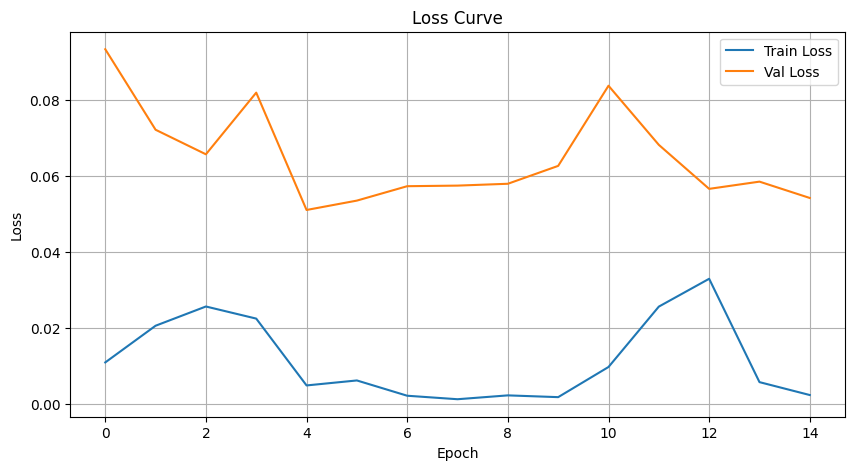

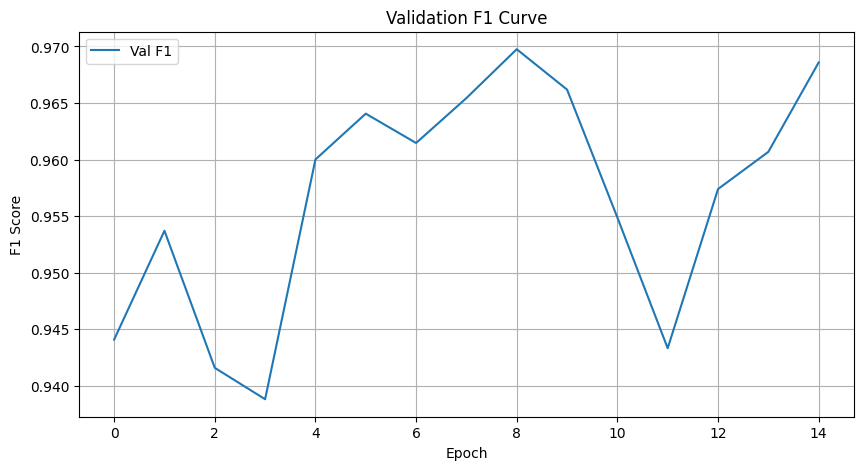

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(f1_scores, label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Curve")
plt.legend()
plt.grid()
plt.show()

### Performance on Training set

To try out the best evaluation threshold

In [29]:
# ResNet evaluation
model_path = "E:/LSE/ST311/ST311-Group-Project/experiment/mixed_res/resnet_f1_0.9744.pth"
model = load_model(model_path, ResNetClassifier, m_num_classes, device)

macro_map, macro_p, macro_r, macro_f1, p_class, r_class, f_class = evaluate_model(model, m_train_loader, m_index_to_label, criterion, device, threshold =0.3)

# save results to CSV
save_eval_results_to_csv(
    model_path,
    macro_map, macro_p, macro_r, macro_f1,
    p_class, r_class, f_class,
    list(m_label_to_index.keys())
)

d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Loss: 3.3244, mAP: 0.8264, Macro P: 0.9685, R: 0.5338, F1: 0.6757
Per-class F1:
  bird: P=0.998, R=0.330, F1=0.496
  cat: P=0.945, R=0.437, F1=0.598
  cow: P=0.994, R=0.757, F1=0.859
  dog: P=0.982, R=0.417, F1=0.585
  elephant: P=0.979, R=0.583, F1=0.731
  horse: P=0.955, R=0.401, F1=0.564
  lion: P=0.957, R=0.637, F1=0.764
  sheep: P=0.939, R=0.709, F1=0.808
Saved evaluation results to: E:\LSE\ST311\ST311-Group-Project\experiment\resnet_f1_0.9744_metrics.csv


In [30]:
macro_map, macro_p, macro_r, macro_f1, p_class, r_class, f_class = evaluate_model(model, m_train_loader, m_index_to_label, criterion, device, threshold=0.2)

# save results to CSV
save_eval_results_to_csv(
    model_path,
    macro_map, macro_p, macro_r, macro_f1,
    p_class, r_class, f_class,
    list(m_label_to_index.keys())
)

Test Loss: 3.3244, mAP: 0.8264, Macro P: 0.9598, R: 0.5510, F1: 0.6884
Per-class F1:
  bird: P=0.995, R=0.347, F1=0.514
  cat: P=0.931, R=0.459, F1=0.615
  cow: P=0.991, R=0.771, F1=0.867
  dog: P=0.968, R=0.440, F1=0.605
  elephant: P=0.974, R=0.600, F1=0.743
  horse: P=0.946, R=0.418, F1=0.580
  lion: P=0.952, R=0.656, F1=0.777
  sheep: P=0.921, R=0.718, F1=0.807
Saved evaluation results to: E:\LSE\ST311\ST311-Group-Project\experiment\resnet_f1_0.9744_metrics.csv


In [31]:
macro_map, macro_p, macro_r, macro_f1, p_class, r_class, f_class = evaluate_model(model, m_train_loader, m_index_to_label, criterion, device, threshold=0.1)

# save results to CSV
save_eval_results_to_csv(
    model_path,
    macro_map, macro_p, macro_r, macro_f1,
    p_class, r_class, f_class,
    list(m_label_to_index.keys())
)

Test Loss: 3.3244, mAP: 0.8264, Macro P: 0.9473, R: 0.5779, F1: 0.7068
Per-class F1:
  bird: P=0.992, R=0.380, F1=0.549
  cat: P=0.905, R=0.493, F1=0.638
  cow: P=0.984, R=0.798, F1=0.881
  dog: P=0.961, R=0.466, F1=0.627
  elephant: P=0.964, R=0.630, F1=0.762
  horse: P=0.935, R=0.440, F1=0.598
  lion: P=0.942, R=0.679, F1=0.789
  sheep: P=0.896, R=0.738, F1=0.809
Saved evaluation results to: E:\LSE\ST311\ST311-Group-Project\experiment\resnet_f1_0.9744_metrics.csv


#### ResNetTranformer

learning_rate = 1e-4, batch_size = 32

In [33]:
# Model
model = ResNetTransformerClassifier(m_num_classes).to(device)
model.load_state_dict(torch.load("E:/LSE/ST311/ST311-Group-Project/experiment/aug_restran/resnet_transformer_f1_0.9477.pth"))
criterion = nn.BCEWithLogitsLoss(pos_weight=m_pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model_save_dir = Path("E:/LSE/ST311/ST311-Group-Project/experiment/mixed_restran")
model_save_dir.mkdir(parents=True, exist_ok=True)
best_loss = float('inf')
patience_counter = 0

train_losses = []
val_losses = []
f1_scores = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, targets in loop:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=total_loss / (loop.n + 1))

    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_preds.append(outputs)
            all_targets.append(targets)

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    val_loss = criterion(all_preds, all_targets).item()
    macro_p, macro_r, macro_f1, macro_map, p_class, r_class, f_class = multilabel_metrics(all_preds, all_targets)

    print(f"Val Loss: {val_loss:.4f}, Map:{round(macro_map,4)}, Macro P: {macro_p:.4f}, R: {macro_r:.4f}, F1: {macro_f1:.4f}")
    print("Per-class F1:")
    for i, label in index_to_label.items():
        print(f"  {label}: P={p_class[i]:.3f}, R={r_class[i]:.3f}, F1={f_class[i]:.3f}")
        
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss)
    f1_scores.append(macro_f1)

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), model_save_dir / f"resnet_tran_f1_{macro_f1:.4f}.pth")
        print("Saved best model.")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{early_stop_patience}")

    if patience_counter >= early_stop_patience:
        print("Early stopping.")
        break


Epoch 1/100: 100%|██████████| 117/117 [00:14<00:00,  7.84it/s, loss=0.0252]


Val Loss: 0.1106, Map:0.977, Macro P: 0.9223, R: 0.9603, F1: 0.9400
Per-class F1:
  bird: P=0.922, R=0.967, F1=0.944
  cat: P=0.959, R=0.904, F1=0.931
  cow: P=0.868, R=1.000, F1=0.930
  dog: P=0.923, R=0.941, F1=0.932
  elephant: P=0.911, R=1.000, F1=0.953
  horse: P=0.912, R=0.984, F1=0.947
  lion: P=0.883, R=0.930, F1=0.906
  sheep: P=1.000, R=0.957, F1=0.978
Saved best model.


Epoch 2/100: 100%|██████████| 117/117 [00:16<00:00,  7.27it/s, loss=0.0208]


Val Loss: 0.0826, Map:0.9901, Macro P: 0.9378, R: 0.9657, F1: 0.9513
Per-class F1:
  bird: P=0.952, R=0.984, F1=0.968
  cat: P=0.960, R=0.923, F1=0.941
  cow: P=0.917, R=1.000, F1=0.957
  dog: P=0.942, R=0.961, F1=0.951
  elephant: P=0.926, R=0.980, F1=0.952
  horse: P=0.952, R=0.952, F1=0.952
  lion: P=0.915, R=0.947, F1=0.931
  sheep: P=0.938, R=0.978, F1=0.957
Saved best model.


Epoch 3/100: 100%|██████████| 117/117 [00:16<00:00,  7.16it/s, loss=0.0268]


Val Loss: 0.0739, Map:0.9832, Macro P: 0.9506, R: 0.9669, F1: 0.9580
Per-class F1:
  bird: P=0.984, R=0.984, F1=0.984
  cat: P=1.000, R=0.923, F1=0.960
  cow: P=1.000, R=1.000, F1=1.000
  dog: P=0.887, R=0.922, F1=0.904
  elephant: P=1.000, R=0.961, F1=0.980
  horse: P=0.897, R=0.968, F1=0.931
  lion: P=0.919, R=1.000, F1=0.958
  sheep: P=0.918, R=0.978, F1=0.947
Saved best model.


Epoch 4/100: 100%|██████████| 117/117 [00:16<00:00,  7.08it/s, loss=0.0196]


Val Loss: 0.1391, Map:0.9783, Macro P: 0.9384, R: 0.9549, F1: 0.9458
Per-class F1:
  bird: P=0.966, R=0.934, F1=0.950
  cat: P=0.940, R=0.904, F1=0.922
  cow: P=1.000, R=0.970, F1=0.985
  dog: P=0.906, R=0.941, F1=0.923
  elephant: P=0.962, R=0.980, F1=0.971
  horse: P=0.849, R=0.984, F1=0.912
  lion: P=0.947, R=0.947, F1=0.947
  sheep: P=0.938, R=0.978, F1=0.957
No improvement. Patience: 1/10


Epoch 5/100: 100%|██████████| 117/117 [00:16<00:00,  6.98it/s, loss=0.0214]


Val Loss: 0.1174, Map:0.9786, Macro P: 0.9332, R: 0.9643, F1: 0.9476
Per-class F1:
  bird: P=0.896, R=0.984, F1=0.938
  cat: P=0.958, R=0.885, F1=0.920
  cow: P=0.917, R=1.000, F1=0.957
  dog: P=0.909, R=0.980, F1=0.943
  elephant: P=0.980, R=0.980, F1=0.980
  horse: P=0.910, R=0.968, F1=0.938
  lion: P=0.918, R=0.982, F1=0.949
  sheep: P=0.977, R=0.935, F1=0.956
No improvement. Patience: 2/10


Epoch 6/100: 100%|██████████| 117/117 [00:17<00:00,  6.71it/s, loss=0.0272]


Val Loss: 0.1137, Map:0.9903, Macro P: 0.9288, R: 0.9610, F1: 0.9429
Per-class F1:
  bird: P=0.923, R=0.984, F1=0.952
  cat: P=0.957, R=0.846, F1=0.898
  cow: P=1.000, R=1.000, F1=1.000
  dog: P=0.820, R=0.980, F1=0.893
  elephant: P=0.980, R=0.980, F1=0.980
  horse: P=0.952, R=0.937, F1=0.944
  lion: P=0.862, R=0.982, F1=0.918
  sheep: P=0.938, R=0.978, F1=0.957
No improvement. Patience: 3/10


Epoch 7/100: 100%|██████████| 117/117 [00:17<00:00,  6.79it/s, loss=0.0115]


Val Loss: 0.0819, Map:0.9962, Macro P: 0.9568, R: 0.9645, F1: 0.9604
Per-class F1:
  bird: P=0.968, R=0.984, F1=0.976
  cat: P=0.940, R=0.904, F1=0.922
  cow: P=0.971, R=1.000, F1=0.985
  dog: P=0.960, R=0.941, F1=0.950
  elephant: P=0.980, R=0.980, F1=0.980
  horse: P=0.924, R=0.968, F1=0.946
  lion: P=0.933, R=0.982, F1=0.957
  sheep: P=0.978, R=0.957, F1=0.967
No improvement. Patience: 4/10


Epoch 8/100: 100%|██████████| 117/117 [00:18<00:00,  6.40it/s, loss=0.0121] 


Val Loss: 0.1144, Map:0.9918, Macro P: 0.9377, R: 0.9599, F1: 0.9478
Per-class F1:
  bird: P=0.952, R=0.984, F1=0.968
  cat: P=0.904, R=0.904, F1=0.904
  cow: P=1.000, R=0.939, F1=0.969
  dog: P=0.960, R=0.941, F1=0.950
  elephant: P=0.980, R=0.980, F1=0.980
  horse: P=0.938, R=0.952, F1=0.945
  lion: P=0.934, R=1.000, F1=0.966
  sheep: P=0.833, R=0.978, F1=0.900
No improvement. Patience: 5/10


Epoch 9/100: 100%|██████████| 117/117 [00:17<00:00,  6.64it/s, loss=0.0239]


Val Loss: 0.1073, Map:0.9779, Macro P: 0.9499, R: 0.9689, F1: 0.9578
Per-class F1:
  bird: P=0.910, R=1.000, F1=0.953
  cat: P=1.000, R=0.865, F1=0.928
  cow: P=0.971, R=1.000, F1=0.985
  dog: P=0.980, R=0.980, F1=0.980
  elephant: P=0.962, R=1.000, F1=0.981
  horse: P=0.849, R=0.984, F1=0.912
  lion: P=0.948, R=0.965, F1=0.957
  sheep: P=0.978, R=0.957, F1=0.967
No improvement. Patience: 6/10


Epoch 10/100: 100%|██████████| 117/117 [00:17<00:00,  6.58it/s, loss=0.0108] 


Val Loss: 0.0931, Map:0.9769, Macro P: 0.9626, R: 0.9693, F1: 0.9656
Per-class F1:
  bird: P=0.968, R=0.984, F1=0.976
  cat: P=0.958, R=0.885, F1=0.920
  cow: P=0.971, R=1.000, F1=0.985
  dog: P=0.942, R=0.961, F1=0.951
  elephant: P=0.980, R=0.980, F1=0.980
  horse: P=0.954, R=0.984, F1=0.969
  lion: P=0.949, R=0.982, F1=0.966
  sheep: P=0.978, R=0.978, F1=0.978
No improvement. Patience: 7/10


Epoch 11/100: 100%|██████████| 117/117 [00:18<00:00,  6.22it/s, loss=0.0241]


Val Loss: 0.0663, Map:0.9939, Macro P: 0.9386, R: 0.9723, F1: 0.9546
Per-class F1:
  bird: P=0.984, R=0.984, F1=0.984
  cat: P=0.941, R=0.923, F1=0.932
  cow: P=0.943, R=1.000, F1=0.971
  dog: P=0.926, R=0.980, F1=0.952
  elephant: P=0.944, R=1.000, F1=0.971
  horse: P=0.896, R=0.952, F1=0.923
  lion: P=0.875, R=0.982, F1=0.926
  sheep: P=1.000, R=0.957, F1=0.978
Saved best model.


Epoch 12/100: 100%|██████████| 117/117 [00:18<00:00,  6.37it/s, loss=0.0119]


Val Loss: 0.0704, Map:0.9941, Macro P: 0.9457, R: 0.9725, F1: 0.9583
Per-class F1:
  bird: P=0.983, R=0.967, F1=0.975
  cat: P=0.877, R=0.962, F1=0.917
  cow: P=0.892, R=1.000, F1=0.943
  dog: P=0.959, R=0.922, F1=0.940
  elephant: P=0.980, R=0.980, F1=0.980
  horse: P=0.925, R=0.984, F1=0.954
  lion: P=0.948, R=0.965, F1=0.957
  sheep: P=1.000, R=1.000, F1=1.000
No improvement. Patience: 1/10


Epoch 13/100: 100%|██████████| 117/117 [00:17<00:00,  6.50it/s, loss=0.00616]


Val Loss: 0.0876, Map:0.9933, Macro P: 0.9475, R: 0.9694, F1: 0.9577
Per-class F1:
  bird: P=1.000, R=0.951, F1=0.975
  cat: P=0.942, R=0.942, F1=0.942
  cow: P=0.892, R=1.000, F1=0.943
  dog: P=0.943, R=0.980, F1=0.962
  elephant: P=1.000, R=1.000, F1=1.000
  horse: P=0.921, R=0.921, F1=0.921
  lion: P=0.903, R=0.982, F1=0.941
  sheep: P=0.978, R=0.978, F1=0.978
No improvement. Patience: 2/10


Epoch 14/100: 100%|██████████| 117/117 [00:17<00:00,  6.67it/s, loss=0.0148]


Val Loss: 0.1297, Map:0.9781, Macro P: 0.9096, R: 0.9547, F1: 0.9301
Per-class F1:
  bird: P=0.921, R=0.951, F1=0.935
  cat: P=0.889, R=0.923, F1=0.906
  cow: P=0.968, R=0.909, F1=0.938
  dog: P=0.959, R=0.922, F1=0.940
  elephant: P=0.962, R=0.980, F1=0.971
  horse: P=0.789, R=0.952, F1=0.863
  lion: P=0.851, R=1.000, F1=0.919
  sheep: P=0.939, R=1.000, F1=0.968
No improvement. Patience: 3/10


Epoch 15/100: 100%|██████████| 117/117 [00:18<00:00,  6.40it/s, loss=0.0226]


Val Loss: 0.0949, Map:0.9913, Macro P: 0.9479, R: 0.9615, F1: 0.9539
Per-class F1:
  bird: P=1.000, R=0.934, F1=0.966
  cat: P=0.961, R=0.942, F1=0.951
  cow: P=1.000, R=0.939, F1=0.969
  dog: P=0.925, R=0.961, F1=0.942
  elephant: P=0.927, R=1.000, F1=0.962
  horse: P=0.894, R=0.937, F1=0.915
  lion: P=0.919, R=1.000, F1=0.958
  sheep: P=0.957, R=0.978, F1=0.968
No improvement. Patience: 4/10


Epoch 16/100: 100%|██████████| 117/117 [00:17<00:00,  6.54it/s, loss=0.0281]


Val Loss: 0.1386, Map:0.9857, Macro P: 0.9105, R: 0.9437, F1: 0.9250
Per-class F1:
  bird: P=0.968, R=1.000, F1=0.984
  cat: P=0.923, R=0.923, F1=0.923
  cow: P=0.800, R=0.970, F1=0.877
  dog: P=0.877, R=0.980, F1=0.926
  elephant: P=0.906, R=0.941, F1=0.923
  horse: P=0.952, R=0.937, F1=0.944
  lion: P=0.960, R=0.842, F1=0.897
  sheep: P=0.898, R=0.957, F1=0.926
No improvement. Patience: 5/10


Epoch 17/100: 100%|██████████| 117/117 [00:18<00:00,  6.36it/s, loss=0.0127]


Val Loss: 0.0978, Map:0.9913, Macro P: 0.9494, R: 0.9731, F1: 0.9607
Per-class F1:
  bird: P=0.983, R=0.934, F1=0.958
  cat: P=0.907, R=0.942, F1=0.925
  cow: P=0.943, R=1.000, F1=0.971
  dog: P=0.962, R=0.980, F1=0.971
  elephant: P=0.962, R=1.000, F1=0.981
  horse: P=0.899, R=0.984, F1=0.939
  lion: P=0.982, R=0.965, F1=0.973
  sheep: P=0.957, R=0.978, F1=0.968
No improvement. Patience: 6/10


Epoch 18/100: 100%|██████████| 117/117 [00:17<00:00,  6.53it/s, loss=0.0129]


Val Loss: 0.0952, Map:0.9911, Macro P: 0.9509, R: 0.9618, F1: 0.9559
Per-class F1:
  bird: P=0.983, R=0.967, F1=0.975
  cat: P=0.961, R=0.942, F1=0.951
  cow: P=1.000, R=0.970, F1=0.985
  dog: P=0.942, R=0.961, F1=0.951
  elephant: P=0.911, R=1.000, F1=0.953
  horse: P=0.910, R=0.968, F1=0.938
  lion: P=0.964, R=0.930, F1=0.946
  sheep: P=0.936, R=0.957, F1=0.946
No improvement. Patience: 7/10


Epoch 19/100: 100%|██████████| 117/117 [00:18<00:00,  6.33it/s, loss=0.00664]


Val Loss: 0.0835, Map:0.992, Macro P: 0.9470, R: 0.9725, F1: 0.9588
Per-class F1:
  bird: P=0.983, R=0.967, F1=0.975
  cat: P=0.961, R=0.942, F1=0.951
  cow: P=0.868, R=1.000, F1=0.930
  dog: P=0.943, R=0.980, F1=0.962
  elephant: P=1.000, R=0.980, F1=0.990
  horse: P=0.899, R=0.984, F1=0.939
  lion: P=0.964, R=0.947, F1=0.956
  sheep: P=0.957, R=0.978, F1=0.968
No improvement. Patience: 8/10


Epoch 20/100: 100%|██████████| 117/117 [00:18<00:00,  6.37it/s, loss=0.0121] 


Val Loss: 0.0691, Map:0.9949, Macro P: 0.9577, R: 0.9696, F1: 0.9632
Per-class F1:
  bird: P=0.967, R=0.967, F1=0.967
  cat: P=0.960, R=0.923, F1=0.941
  cow: P=0.943, R=1.000, F1=0.971
  dog: P=0.961, R=0.961, F1=0.961
  elephant: P=1.000, R=0.980, F1=0.990
  horse: P=0.900, R=1.000, F1=0.947
  lion: P=0.931, R=0.947, F1=0.939
  sheep: P=1.000, R=0.978, F1=0.989
No improvement. Patience: 9/10


Epoch 21/100: 100%|██████████| 117/117 [00:17<00:00,  6.78it/s, loss=0.00275]


Val Loss: 0.0664, Map:0.9917, Macro P: 0.9689, R: 0.9793, F1: 0.9738
Per-class F1:
  bird: P=0.967, R=0.967, F1=0.967
  cat: P=0.980, R=0.942, F1=0.961
  cow: P=0.971, R=1.000, F1=0.985
  dog: P=0.962, R=0.980, F1=0.971
  elephant: P=1.000, R=1.000, F1=1.000
  horse: P=0.969, R=0.984, F1=0.976
  lion: P=0.903, R=0.982, F1=0.941
  sheep: P=1.000, R=0.978, F1=0.989
No improvement. Patience: 10/10
Early stopping.


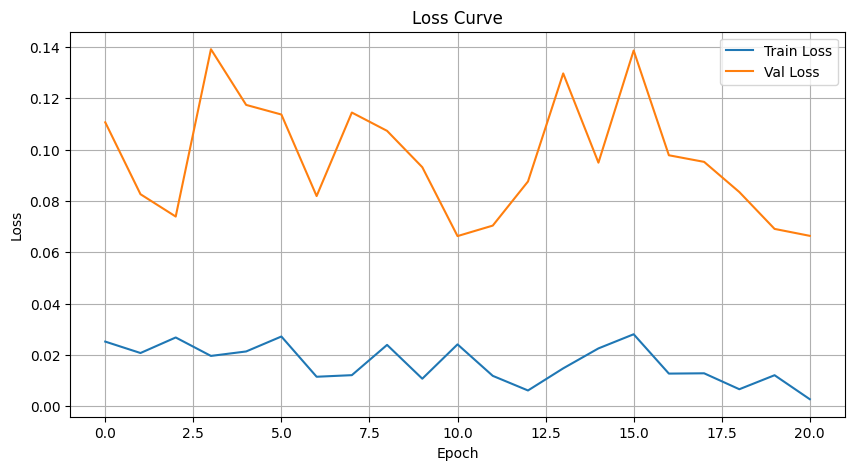

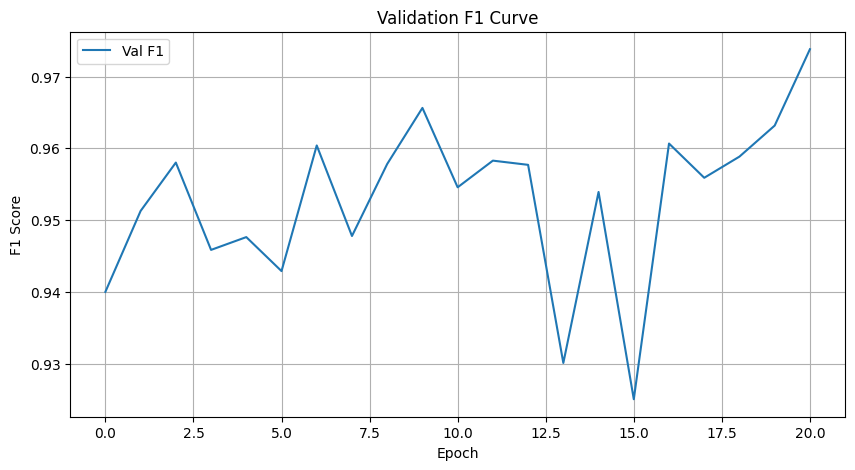

In [37]:

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(f1_scores, label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Curve")
plt.legend()
plt.grid()
plt.show()

#### Performance on Training Set

In [34]:
# evaluation
model_path = "E:/LSE/ST311/ST311-Group-Project/experiment/mixed_restran/resnet_tran_f1_0.9580.pth"
model = load_model(model_path, ResNetTransformerClassifier, m_num_classes, device)

macro_map, macro_p, macro_r, macro_f1, p_class, r_class, f_class = evaluate_model(model, m_train_loader, m_index_to_label, criterion, device)

# save results to CSV
save_eval_results_to_csv(
    model_path,
    macro_map, macro_p, macro_r, macro_f1,
    p_class, r_class, f_class,
    list(m_label_to_index.keys())
)

Test Loss: 2.9304, mAP: 0.7967, Macro P: 0.9486, R: 0.5148, F1: 0.6594
Per-class F1:
  bird: P=1.000, R=0.310, F1=0.473
  cat: P=0.946, R=0.394, F1=0.557
  cow: P=0.988, R=0.643, F1=0.779
  dog: P=0.914, R=0.498, F1=0.644
  elephant: P=0.976, R=0.566, F1=0.716
  horse: P=0.888, R=0.469, F1=0.614
  lion: P=0.937, R=0.604, F1=0.735
  sheep: P=0.939, R=0.635, F1=0.758
Saved evaluation results to: E:\LSE\ST311\ST311-Group-Project\experiment\resnet_tran_f1_0.9580_metrics.csv


In [36]:
# evaluation
model_path = "E:/LSE/ST311/ST311-Group-Project/experiment/mixed_restran/resnet_tran_f1_0.9580.pth"
model = load_model(model_path, ResNetTransformerClassifier, m_num_classes, device)

macro_map, macro_p, macro_r, macro_f1, p_class, r_class, f_class = evaluate_model(model, m_train_loader, m_index_to_label, criterion, device, threshold=0.1)

# save results to CSV
save_eval_results_to_csv(
    model_path,
    macro_map, macro_p, macro_r, macro_f1,
    p_class, r_class, f_class,
    list(m_label_to_index.keys())
)

Test Loss: 2.9304, mAP: 0.7967, Macro P: 0.9143, R: 0.5642, F1: 0.6908
Per-class F1:
  bird: P=0.997, R=0.367, F1=0.536
  cat: P=0.900, R=0.445, F1=0.596
  cow: P=0.984, R=0.692, F1=0.812
  dog: P=0.852, R=0.545, F1=0.665
  elephant: P=0.938, R=0.622, F1=0.748
  horse: P=0.834, R=0.521, F1=0.641
  lion: P=0.904, R=0.653, F1=0.758
  sheep: P=0.906, R=0.669, F1=0.770
Saved evaluation results to: E:\LSE\ST311\ST311-Group-Project\experiment\resnet_tran_f1_0.9580_metrics.csv


# Train on Pure Mixed Audios

### ResNetTransform

learning_rate = 1e-4, batch_size = 32

In [ ]:
# Model
learning_rate = 1e-4
early_stop_patience = 10

model = ResNetClassifier(m_num_classes).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=m_pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model_save_dir = Path("E:/LSE/ST311/ST311-Group-Project/experiment/pure_mixed_restran")
model_save_dir.mkdir(parents=True, exist_ok=True)
best_loss = float('inf')
patience_counter = 0

train_losses = []
val_losses = []
f1_scores = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, targets in loop:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=total_loss / (loop.n + 1))

    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_preds.append(outputs)
            all_targets.append(targets)

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    val_loss = criterion(all_preds, all_targets).item()
    macro_p, macro_r, macro_f1, macro_map, p_class, r_class, f_class = multilabel_metrics(all_preds, all_targets)

    print(f"Val Loss: {val_loss:.4f}, Map:{round(macro_map,4)}, Macro P: {macro_p:.4f}, R: {macro_r:.4f}, F1: {macro_f1:.4f}")
    print("Per-class F1:")
    for i, label in index_to_label.items():
        print(f"  {label}: P={p_class[i]:.3f}, R={r_class[i]:.3f}, F1={f_class[i]:.3f}")
        
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss)
    f1_scores.append(macro_f1)

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), model_save_dir / f"res_f1_{macro_f1:.4f}.pth")
        print("Saved best model.")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{early_stop_patience}")

    if patience_counter >= early_stop_patience:
        print("Early stopping.")
        break

d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/100: 100%|██████████| 117/117 [00:16<00:00,  7.25it/s, loss=0.435]


Val Loss: 0.2071, Map:0.947, Macro P: 0.8129, R: 0.9363, F1: 0.8636
Per-class F1:
  bird: P=0.905, R=0.934, F1=0.919
  cat: P=0.938, R=0.865, F1=0.900
  cow: P=0.786, R=1.000, F1=0.880
  dog: P=0.889, R=0.941, F1=0.914
  elephant: P=0.653, R=0.922, F1=0.764
  horse: P=0.875, R=0.889, F1=0.882
  lion: P=0.596, R=0.982, F1=0.742
  sheep: P=0.863, R=0.957, F1=0.907
Saved best model.


Epoch 2/100: 100%|██████████| 117/117 [00:15<00:00,  7.77it/s, loss=0.147]


Val Loss: 0.1307, Map:0.975, Macro P: 0.8834, R: 0.9360, F1: 0.9071
Per-class F1:
  bird: P=0.967, R=0.951, F1=0.959
  cat: P=0.868, R=0.885, F1=0.876
  cow: P=0.906, R=0.879, F1=0.892
  dog: P=0.959, R=0.922, F1=0.940
  elephant: P=0.873, R=0.941, F1=0.906
  horse: P=0.753, R=0.968, F1=0.847
  lion: P=0.859, R=0.965, F1=0.909
  sheep: P=0.882, R=0.978, F1=0.928
Saved best model.


Epoch 3/100: 100%|██████████| 117/117 [00:15<00:00,  7.70it/s, loss=0.0913]


Val Loss: 0.1666, Map:0.9547, Macro P: 0.8724, R: 0.9339, F1: 0.8969
Per-class F1:
  bird: P=1.000, R=0.934, F1=0.966
  cat: P=0.939, R=0.885, F1=0.911
  cow: P=0.744, R=0.970, F1=0.842
  dog: P=0.794, R=0.980, F1=0.877
  elephant: P=0.900, R=0.882, F1=0.891
  horse: P=0.981, R=0.841, F1=0.906
  lion: P=0.803, R=1.000, F1=0.891
  sheep: P=0.818, R=0.978, F1=0.891
No improvement. Patience: 1/10


Epoch 4/100: 100%|██████████| 117/117 [00:15<00:00,  7.34it/s, loss=0.0675]


Val Loss: 0.1257, Map:0.9754, Macro P: 0.9119, R: 0.9480, F1: 0.9287
Per-class F1:
  bird: P=0.922, R=0.967, F1=0.944
  cat: P=0.902, R=0.885, F1=0.893
  cow: P=0.892, R=1.000, F1=0.943
  dog: P=0.941, R=0.941, F1=0.941
  elephant: P=0.860, R=0.961, F1=0.907
  horse: P=0.870, R=0.952, F1=0.909
  lion: P=0.932, R=0.965, F1=0.948
  sheep: P=0.977, R=0.913, F1=0.944
Saved best model.


Epoch 5/100: 100%|██████████| 117/117 [00:15<00:00,  7.39it/s, loss=0.042] 


Val Loss: 0.1732, Map:0.9603, Macro P: 0.9018, R: 0.9219, F1: 0.9096
Per-class F1:
  bird: P=0.894, R=0.967, F1=0.929
  cat: P=0.939, R=0.885, F1=0.911
  cow: P=0.886, R=0.939, F1=0.912
  dog: P=0.845, R=0.961, F1=0.899
  elephant: P=0.978, R=0.882, F1=0.928
  horse: P=0.848, R=0.889, F1=0.868
  lion: P=0.848, R=0.982, F1=0.911
  sheep: P=0.976, R=0.870, F1=0.920
No improvement. Patience: 1/10


Epoch 6/100: 100%|██████████| 117/117 [00:15<00:00,  7.49it/s, loss=0.0407]


Val Loss: 0.1075, Map:0.9748, Macro P: 0.9257, R: 0.9554, F1: 0.9385
Per-class F1:
  bird: P=0.968, R=1.000, F1=0.984
  cat: P=0.978, R=0.846, F1=0.907
  cow: P=0.969, R=0.939, F1=0.954
  dog: P=0.961, R=0.961, F1=0.961
  elephant: P=0.911, R=1.000, F1=0.953
  horse: P=0.868, R=0.937, F1=0.901
  lion: P=0.933, R=0.982, F1=0.957
  sheep: P=0.818, R=0.978, F1=0.891
Saved best model.


Epoch 7/100: 100%|██████████| 117/117 [00:15<00:00,  7.33it/s, loss=0.0377]


Val Loss: 0.1255, Map:0.9775, Macro P: 0.9097, R: 0.9417, F1: 0.9229
Per-class F1:
  bird: P=0.984, R=1.000, F1=0.992
  cat: P=0.887, R=0.904, F1=0.895
  cow: P=0.966, R=0.848, F1=0.903
  dog: P=0.941, R=0.941, F1=0.941
  elephant: P=0.769, R=0.980, F1=0.862
  horse: P=0.951, R=0.921, F1=0.935
  lion: P=0.966, R=0.982, F1=0.974
  sheep: P=0.815, R=0.957, F1=0.880
No improvement. Patience: 1/10


Epoch 8/100: 100%|██████████| 117/117 [00:15<00:00,  7.49it/s, loss=0.0401]


Val Loss: 0.1024, Map:0.9779, Macro P: 0.9387, R: 0.9660, F1: 0.9504
Per-class F1:
  bird: P=1.000, R=0.967, F1=0.983
  cat: P=1.000, R=0.885, F1=0.939
  cow: P=0.941, R=0.970, F1=0.955
  dog: P=0.943, R=0.980, F1=0.962
  elephant: P=0.942, R=0.961, F1=0.951
  horse: P=0.913, R=1.000, F1=0.955
  lion: P=0.948, R=0.965, F1=0.957
  sheep: P=0.821, R=1.000, F1=0.902
Saved best model.


Epoch 9/100: 100%|██████████| 117/117 [00:17<00:00,  6.88it/s, loss=0.0291]


Val Loss: 0.1177, Map:0.9852, Macro P: 0.9389, R: 0.9530, F1: 0.9448
Per-class F1:
  bird: P=1.000, R=0.934, F1=0.966
  cat: P=0.958, R=0.885, F1=0.920
  cow: P=0.941, R=0.970, F1=0.955
  dog: P=0.960, R=0.941, F1=0.950
  elephant: P=0.961, R=0.961, F1=0.961
  horse: P=0.836, R=0.968, F1=0.897
  lion: P=0.917, R=0.965, F1=0.940
  sheep: P=0.939, R=1.000, F1=0.968
No improvement. Patience: 1/10


Epoch 10/100: 100%|██████████| 117/117 [00:17<00:00,  6.66it/s, loss=0.0346]


Val Loss: 0.1116, Map:0.9783, Macro P: 0.9351, R: 0.9637, F1: 0.9479
Per-class F1:
  bird: P=1.000, R=0.967, F1=0.983
  cat: P=0.958, R=0.885, F1=0.920
  cow: P=0.970, R=0.970, F1=0.970
  dog: P=0.943, R=0.980, F1=0.962
  elephant: P=0.961, R=0.961, F1=0.961
  horse: P=0.924, R=0.968, F1=0.946
  lion: P=0.891, R=1.000, F1=0.942
  sheep: P=0.833, R=0.978, F1=0.900
No improvement. Patience: 2/10


Epoch 11/100: 100%|██████████| 117/117 [00:16<00:00,  7.07it/s, loss=0.028] 


Val Loss: 0.1015, Map:0.9925, Macro P: 0.9243, R: 0.9542, F1: 0.9377
Per-class F1:
  bird: P=0.951, R=0.951, F1=0.951
  cat: P=1.000, R=0.885, F1=0.939
  cow: P=1.000, R=0.970, F1=0.985
  dog: P=0.909, R=0.980, F1=0.943
  elephant: P=0.862, R=0.980, F1=0.917
  horse: P=0.897, R=0.968, F1=0.931
  lion: P=0.932, R=0.965, F1=0.948
  sheep: P=0.843, R=0.935, F1=0.887
Saved best model.


Epoch 12/100: 100%|██████████| 117/117 [00:16<00:00,  7.13it/s, loss=0.0119]


Val Loss: 0.1479, Map:0.9639, Macro P: 0.9073, R: 0.9504, F1: 0.9263
Per-class F1:
  bird: P=0.952, R=0.967, F1=0.959
  cat: P=0.958, R=0.885, F1=0.920
  cow: P=0.767, R=1.000, F1=0.868
  dog: P=0.942, R=0.961, F1=0.951
  elephant: P=0.893, R=0.980, F1=0.935
  horse: P=0.937, R=0.937, F1=0.937
  lion: P=0.918, R=0.982, F1=0.949
  sheep: P=0.891, R=0.891, F1=0.891
No improvement. Patience: 1/10


Epoch 13/100: 100%|██████████| 117/117 [00:16<00:00,  7.17it/s, loss=0.0297]


Val Loss: 0.1456, Map:0.9707, Macro P: 0.8918, R: 0.9453, F1: 0.9150
Per-class F1:
  bird: P=0.984, R=0.984, F1=0.984
  cat: P=0.939, R=0.885, F1=0.911
  cow: P=0.882, R=0.909, F1=0.896
  dog: P=0.960, R=0.941, F1=0.950
  elephant: P=0.847, R=0.980, F1=0.909
  horse: P=0.921, R=0.921, F1=0.921
  lion: P=0.887, R=0.965, F1=0.924
  sheep: P=0.714, R=0.978, F1=0.826
No improvement. Patience: 2/10


Epoch 14/100: 100%|██████████| 117/117 [00:17<00:00,  6.84it/s, loss=0.0218]


Val Loss: 0.1291, Map:0.9657, Macro P: 0.9404, R: 0.9529, F1: 0.9451
Per-class F1:
  bird: P=0.968, R=0.984, F1=0.976
  cat: P=1.000, R=0.923, F1=0.960
  cow: P=0.939, R=0.939, F1=0.939
  dog: P=0.980, R=0.941, F1=0.960
  elephant: P=0.942, R=0.961, F1=0.951
  horse: P=0.894, R=0.937, F1=0.915
  lion: P=0.800, R=0.982, F1=0.882
  sheep: P=1.000, R=0.957, F1=0.978
No improvement. Patience: 3/10


Epoch 15/100: 100%|██████████| 117/117 [00:16<00:00,  6.89it/s, loss=0.0353]


Val Loss: 0.1010, Map:0.9793, Macro P: 0.9479, R: 0.9674, F1: 0.9572
Per-class F1:
  bird: P=0.968, R=0.984, F1=0.976
  cat: P=0.961, R=0.942, F1=0.951
  cow: P=1.000, R=1.000, F1=1.000
  dog: P=0.960, R=0.941, F1=0.950
  elephant: P=0.926, R=0.980, F1=0.952
  horse: P=0.952, R=0.952, F1=0.952
  lion: P=0.918, R=0.982, F1=0.949
  sheep: P=0.898, R=0.957, F1=0.926
Saved best model.


Epoch 16/100: 100%|██████████| 117/117 [00:18<00:00,  6.46it/s, loss=0.0339]


Val Loss: 0.1515, Map:0.9767, Macro P: 0.9171, R: 0.9333, F1: 0.9229
Per-class F1:
  bird: P=1.000, R=0.951, F1=0.975
  cat: P=0.902, R=0.885, F1=0.893
  cow: P=1.000, R=0.818, F1=0.900
  dog: P=0.907, R=0.961, F1=0.933
  elephant: P=0.907, R=0.961, F1=0.933
  horse: P=0.882, R=0.952, F1=0.916
  lion: P=0.875, R=0.982, F1=0.926
  sheep: P=0.863, R=0.957, F1=0.907
No improvement. Patience: 1/10


Epoch 17/100: 100%|██████████| 117/117 [00:18<00:00,  6.46it/s, loss=0.0325]


Val Loss: 0.1185, Map:0.9794, Macro P: 0.9288, R: 0.9649, F1: 0.9456
Per-class F1:
  bird: P=0.896, R=0.984, F1=0.938
  cat: P=0.957, R=0.865, F1=0.909
  cow: P=0.971, R=1.000, F1=0.985
  dog: P=0.925, R=0.961, F1=0.942
  elephant: P=0.943, R=0.980, F1=0.962
  horse: P=0.924, R=0.968, F1=0.946
  lion: P=0.949, R=0.982, F1=0.966
  sheep: P=0.865, R=0.978, F1=0.918
No improvement. Patience: 2/10


Epoch 18/100: 100%|██████████| 117/117 [00:18<00:00,  6.46it/s, loss=0.012]  


Val Loss: 0.1136, Map:0.9902, Macro P: 0.9477, R: 0.9589, F1: 0.9521
Per-class F1:
  bird: P=1.000, R=0.967, F1=0.983
  cat: P=0.959, R=0.904, F1=0.931
  cow: P=1.000, R=0.909, F1=0.952
  dog: P=0.980, R=0.961, F1=0.970
  elephant: P=0.962, R=1.000, F1=0.981
  horse: P=0.857, R=0.952, F1=0.902
  lion: P=0.905, R=1.000, F1=0.950
  sheep: P=0.918, R=0.978, F1=0.947
No improvement. Patience: 3/10


Epoch 19/100: 100%|██████████| 117/117 [00:17<00:00,  6.75it/s, loss=0.0329]


Val Loss: 0.0938, Map:0.9906, Macro P: 0.9471, R: 0.9562, F1: 0.9510
Per-class F1:
  bird: P=0.984, R=0.984, F1=0.984
  cat: P=0.922, R=0.904, F1=0.913
  cow: P=1.000, R=0.939, F1=0.969
  dog: P=0.961, R=0.961, F1=0.961
  elephant: P=0.962, R=0.980, F1=0.971
  horse: P=0.951, R=0.921, F1=0.935
  lion: P=0.933, R=0.982, F1=0.957
  sheep: P=0.865, R=0.978, F1=0.918
Saved best model.


Epoch 20/100: 100%|██████████| 117/117 [00:16<00:00,  6.95it/s, loss=0.00758]


Val Loss: 0.1112, Map:0.9844, Macro P: 0.9385, R: 0.9621, F1: 0.9497
Per-class F1:
  bird: P=0.953, R=1.000, F1=0.976
  cat: P=0.960, R=0.923, F1=0.941
  cow: P=0.969, R=0.939, F1=0.954
  dog: P=0.941, R=0.941, F1=0.941
  elephant: P=0.962, R=0.980, F1=0.971
  horse: P=0.882, R=0.952, F1=0.916
  lion: P=0.903, R=0.982, F1=0.941
  sheep: P=0.938, R=0.978, F1=0.957
No improvement. Patience: 1/10


Epoch 21/100: 100%|██████████| 117/117 [00:16<00:00,  7.07it/s, loss=0.00769]


Val Loss: 0.0960, Map:0.9912, Macro P: 0.9525, R: 0.9640, F1: 0.9578
Per-class F1:
  bird: P=0.984, R=0.984, F1=0.984
  cat: P=0.958, R=0.885, F1=0.920
  cow: P=0.970, R=0.970, F1=0.970
  dog: P=0.961, R=0.961, F1=0.961
  elephant: P=0.962, R=1.000, F1=0.981
  horse: P=0.882, R=0.952, F1=0.916
  lion: P=0.966, R=0.982, F1=0.974
  sheep: P=0.938, R=0.978, F1=0.957
No improvement. Patience: 2/10


Epoch 22/100: 100%|██████████| 117/117 [00:16<00:00,  6.99it/s, loss=0.00376]


Val Loss: 0.1202, Map:0.9817, Macro P: 0.9537, R: 0.9664, F1: 0.9597
Per-class F1:
  bird: P=0.984, R=1.000, F1=0.992
  cat: P=0.959, R=0.904, F1=0.931
  cow: P=1.000, R=0.970, F1=0.985
  dog: P=0.961, R=0.961, F1=0.961
  elephant: P=0.962, R=1.000, F1=0.981
  horse: P=0.908, R=0.937, F1=0.922
  lion: P=0.918, R=0.982, F1=0.949
  sheep: P=0.938, R=0.978, F1=0.957
No improvement. Patience: 3/10


Epoch 23/100: 100%|██████████| 117/117 [00:16<00:00,  7.23it/s, loss=0.00233]


Val Loss: 0.0990, Map:0.9883, Macro P: 0.9621, R: 0.9678, F1: 0.9646
Per-class F1:
  bird: P=0.984, R=0.984, F1=0.984
  cat: P=0.958, R=0.885, F1=0.920
  cow: P=1.000, R=1.000, F1=1.000
  dog: P=0.942, R=0.961, F1=0.951
  elephant: P=0.962, R=1.000, F1=0.981
  horse: P=0.923, R=0.952, F1=0.938
  lion: P=0.949, R=0.982, F1=0.966
  sheep: P=0.978, R=0.978, F1=0.978
No improvement. Patience: 4/10


Epoch 24/100: 100%|██████████| 117/117 [00:16<00:00,  7.17it/s, loss=0.0165]


Val Loss: 0.1105, Map:0.9904, Macro P: 0.9420, R: 0.9637, F1: 0.9511
Per-class F1:
  bird: P=0.968, R=0.984, F1=0.976
  cat: P=1.000, R=0.904, F1=0.949
  cow: P=1.000, R=0.970, F1=0.985
  dog: P=0.979, R=0.902, F1=0.939
  elephant: P=0.927, R=1.000, F1=0.962
  horse: P=0.824, R=0.968, F1=0.891
  lion: P=0.918, R=0.982, F1=0.949
  sheep: P=0.920, R=1.000, F1=0.958
No improvement. Patience: 5/10


Epoch 25/100: 100%|██████████| 117/117 [00:15<00:00,  7.33it/s, loss=0.0197]


Val Loss: 0.1369, Map:0.9793, Macro P: 0.9284, R: 0.9585, F1: 0.9426
Per-class F1:
  bird: P=0.983, R=0.967, F1=0.975
  cat: P=0.922, R=0.904, F1=0.913
  cow: P=0.971, R=1.000, F1=0.985
  dog: P=0.891, R=0.961, F1=0.925
  elephant: P=0.961, R=0.961, F1=0.961
  horse: P=0.937, R=0.937, F1=0.937
  lion: P=0.933, R=0.982, F1=0.957
  sheep: P=0.830, R=0.957, F1=0.889
No improvement. Patience: 6/10


Epoch 26/100: 100%|██████████| 117/117 [00:15<00:00,  7.42it/s, loss=0.0133] 


Val Loss: 0.1338, Map:0.977, Macro P: 0.9306, R: 0.9572, F1: 0.9426
Per-class F1:
  bird: P=0.983, R=0.967, F1=0.975
  cat: P=0.958, R=0.885, F1=0.920
  cow: P=0.935, R=0.879, F1=0.906
  dog: P=0.925, R=0.961, F1=0.942
  elephant: P=0.944, R=1.000, F1=0.971
  horse: P=0.899, R=0.984, F1=0.939
  lion: P=0.862, R=0.982, F1=0.918
  sheep: P=0.939, R=1.000, F1=0.968
No improvement. Patience: 7/10


Epoch 27/100: 100%|██████████| 117/117 [00:16<00:00,  7.15it/s, loss=0.0354]


Val Loss: 0.1626, Map:0.9764, Macro P: 0.9398, R: 0.9541, F1: 0.9453
Per-class F1:
  bird: P=1.000, R=0.951, F1=0.975
  cat: P=0.978, R=0.846, F1=0.907
  cow: P=0.941, R=0.970, F1=0.955
  dog: P=0.909, R=0.980, F1=0.943
  elephant: P=0.981, R=1.000, F1=0.990
  horse: P=0.836, R=0.968, F1=0.897
  lion: P=0.918, R=0.982, F1=0.949
  sheep: P=0.956, R=0.935, F1=0.945
No improvement. Patience: 8/10


Epoch 28/100: 100%|██████████| 117/117 [00:16<00:00,  7.22it/s, loss=0.0105]


Val Loss: 0.1212, Map:0.9828, Macro P: 0.9534, R: 0.9612, F1: 0.9564
Per-class F1:
  bird: P=0.983, R=0.967, F1=0.975
  cat: P=0.957, R=0.865, F1=0.909
  cow: P=1.000, R=0.970, F1=0.985
  dog: P=0.926, R=0.980, F1=0.952
  elephant: P=0.927, R=1.000, F1=0.962
  horse: P=0.884, R=0.968, F1=0.924
  lion: P=0.949, R=0.982, F1=0.966
  sheep: P=1.000, R=0.957, F1=0.978
No improvement. Patience: 9/10


Epoch 29/100: 100%|██████████| 117/117 [00:16<00:00,  7.28it/s, loss=0.0166]


Val Loss: 0.1186, Map:0.9858, Macro P: 0.9425, R: 0.9600, F1: 0.9491
Per-class F1:
  bird: P=0.984, R=0.984, F1=0.984
  cat: P=1.000, R=0.904, F1=0.949
  cow: P=1.000, R=0.970, F1=0.985
  dog: P=0.960, R=0.941, F1=0.950
  elephant: P=0.911, R=1.000, F1=0.953
  horse: P=0.951, R=0.921, F1=0.935
  lion: P=0.778, R=0.982, F1=0.868
  sheep: P=0.957, R=0.978, F1=0.968
No improvement. Patience: 10/10
Early stopping.


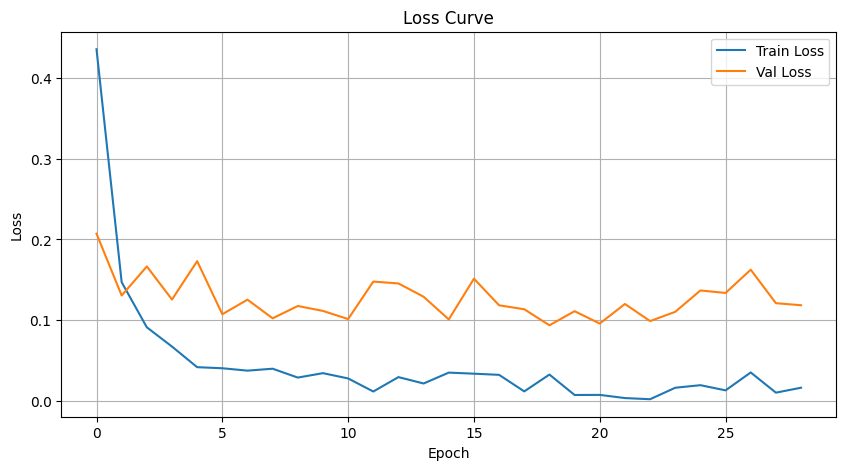

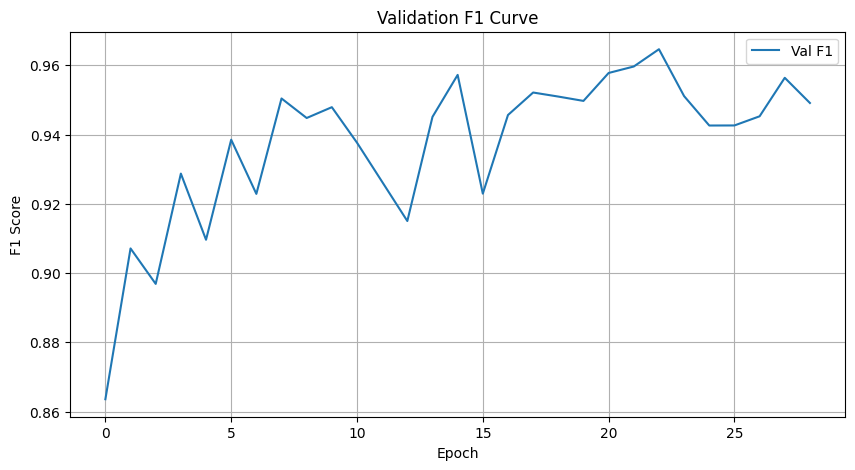

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(f1_scores, label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Curve")
plt.legend()
plt.grid()
plt.show()

#### Performance on Training Set

In [ ]:
# ResNetTransform evaluation
model_path = "E:/LSE/ST311/ST311-Group-Project/experiment/pure_mixed_restran/restran_f1_0.9572.pth"
model = load_model(model_path, ResNetTransformerClassifier, m_num_classes, device)

macro_map, macro_p, macro_r, macro_f1, p_class, r_class, f_class = evaluate_model(model, m_train_loader, m_index_to_label, criterion, device)

# save results to CSV
save_eval_results_to_csv(
    model_path,
    macro_map, macro_p, macro_r, macro_f1,
    p_class, r_class, f_class,
    list(m_label_to_index.keys())
)

d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Loss: 2.7912, mAP: 0.7921, Macro P: 0.9508, R: 0.5138, F1: 0.6541
Per-class F1:
  bird: P=0.986, R=0.460, F1=0.627
  cat: P=0.942, R=0.387, F1=0.548
  cow: P=0.960, R=0.741, F1=0.837
  dog: P=0.977, R=0.268, F1=0.421
  elephant: P=0.937, R=0.597, F1=0.730
  horse: P=0.908, R=0.432, F1=0.586
  lion: P=0.958, R=0.561, F1=0.708
  sheep: P=0.938, R=0.663, F1=0.777
Saved evaluation results to: E:\LSE\ST311\ST311-Group-Project\experiment\restran_3e_5_lr_f1_0.9572_metrics.csv


In [40]:
# ResNetTransform evaluation
model_path = "E:/LSE/ST311/ST311-Group-Project/experiment/pure_mixed_restran/restran_f1_0.9572.pth"
model = load_model(model_path, ResNetTransformerClassifier, m_num_classes, device)

macro_map, macro_p, macro_r, macro_f1, p_class, r_class, f_class = evaluate_model(model, m_train_loader, m_index_to_label, criterion, device, threshold=0.1)

# save results to CSV
save_eval_results_to_csv(
    model_path,
    macro_map, macro_p, macro_r, macro_f1,
    p_class, r_class, f_class,
    list(m_label_to_index.keys())
)

Test Loss: 2.7969, mAP: 0.7913, Macro P: 0.9079, R: 0.5598, F1: 0.6813
Per-class F1:
  bird: P=0.967, R=0.496, F1=0.656
  cat: P=0.895, R=0.445, F1=0.595
  cow: P=0.938, R=0.772, F1=0.847
  dog: P=0.944, R=0.320, F1=0.478
  elephant: P=0.866, R=0.651, F1=0.743
  horse: P=0.825, R=0.477, F1=0.605
  lion: P=0.941, R=0.611, F1=0.741
  sheep: P=0.887, R=0.706, F1=0.786
Saved evaluation results to: E:\LSE\ST311\ST311-Group-Project\experiment\restran_3e_5_lr_f1_0.9572_metrics.csv


### ResNet

learning_rate = 1e-4, batch_size = 32

In [41]:
# Model
learning_rate = 1e-4
early_stop_patience = 10

model = ResNetClassifier(m_num_classes).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=m_pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model_save_dir = Path("E:/LSE/ST311/ST311-Group-Project/experiment/pure_mixed_res")
model_save_dir.mkdir(parents=True, exist_ok=True)
best_loss = float('inf')
patience_counter = 0

train_losses = []
val_losses = []
f1_scores = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, targets in loop:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=total_loss / (loop.n + 1))

    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_preds.append(outputs)
            all_targets.append(targets)

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    val_loss = criterion(all_preds, all_targets).item()
    macro_p, macro_r, macro_f1, macro_map, p_class, r_class, f_class = multilabel_metrics(all_preds, all_targets)

    print(f"Val Loss: {val_loss:.4f}, Map:{round(macro_map,4)}, Macro P: {macro_p:.4f}, R: {macro_r:.4f}, F1: {macro_f1:.4f}")
    print("Per-class F1:")
    for i, label in index_to_label.items():
        print(f"  {label}: P={p_class[i]:.3f}, R={r_class[i]:.3f}, F1={f_class[i]:.3f}")
        
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss)
    f1_scores.append(macro_f1)

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), model_save_dir / f"res_1e_4_lr_f1_{macro_f1:.4f}.pth")
        print("Saved best model.")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{early_stop_patience}")

    if patience_counter >= early_stop_patience:
        print("Early stopping.")
        break

d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/100: 100%|██████████| 117/117 [00:12<00:00,  9.64it/s, loss=0.45] 


Val Loss: 0.1766, Map:0.9635, Macro P: 0.8309, R: 0.9202, F1: 0.8699
Per-class F1:
  bird: P=0.909, R=0.984, F1=0.945
  cat: P=0.915, R=0.827, F1=0.869
  cow: P=0.681, R=0.970, F1=0.800
  dog: P=0.902, R=0.902, F1=0.902
  elephant: P=0.721, R=0.863, F1=0.786
  horse: P=0.800, R=0.952, F1=0.870
  lion: P=0.841, R=0.930, F1=0.883
  sheep: P=0.878, R=0.935, F1=0.905
Saved best model.


Epoch 2/100: 100%|██████████| 117/117 [00:12<00:00,  9.63it/s, loss=0.134]


Val Loss: 0.1234, Map:0.9771, Macro P: 0.8855, R: 0.9460, F1: 0.9123
Per-class F1:
  bird: P=0.952, R=0.967, F1=0.959
  cat: P=0.906, R=0.923, F1=0.914
  cow: P=0.939, R=0.939, F1=0.939
  dog: P=0.938, R=0.882, F1=0.909
  elephant: P=0.721, R=0.961, F1=0.824
  horse: P=0.909, R=0.952, F1=0.930
  lion: P=0.917, R=0.965, F1=0.940
  sheep: P=0.804, R=0.978, F1=0.882
Saved best model.


Epoch 3/100: 100%|██████████| 117/117 [00:12<00:00,  9.63it/s, loss=0.0677]


Val Loss: 0.0979, Map:0.9847, Macro P: 0.9044, R: 0.9515, F1: 0.9251
Per-class F1:
  bird: P=0.983, R=0.967, F1=0.975
  cat: P=0.977, R=0.827, F1=0.896
  cow: P=0.800, R=0.970, F1=0.877
  dog: P=0.943, R=0.980, F1=0.962
  elephant: P=0.875, R=0.961, F1=0.916
  horse: P=0.897, R=0.968, F1=0.931
  lion: P=0.862, R=0.982, F1=0.918
  sheep: P=0.898, R=0.957, F1=0.926
Saved best model.


Epoch 4/100: 100%|██████████| 117/117 [00:12<00:00,  9.29it/s, loss=0.0307]


Val Loss: 0.0979, Map:0.9871, Macro P: 0.9147, R: 0.9495, F1: 0.9302
Per-class F1:
  bird: P=0.952, R=0.984, F1=0.968
  cat: P=0.922, R=0.904, F1=0.913
  cow: P=0.939, R=0.939, F1=0.939
  dog: P=0.960, R=0.941, F1=0.950
  elephant: P=0.907, R=0.961, F1=0.933
  horse: P=0.966, R=0.889, F1=0.926
  lion: P=0.838, R=1.000, F1=0.912
  sheep: P=0.833, R=0.978, F1=0.900
Saved best model.


Epoch 5/100: 100%|██████████| 117/117 [00:12<00:00,  9.50it/s, loss=0.0255]


Val Loss: 0.0702, Map:0.9922, Macro P: 0.9324, R: 0.9671, F1: 0.9488
Per-class F1:
  bird: P=0.923, R=0.984, F1=0.952
  cat: P=0.898, R=0.846, F1=0.871
  cow: P=0.971, R=1.000, F1=0.985
  dog: P=0.980, R=0.961, F1=0.970
  elephant: P=0.962, R=1.000, F1=0.981
  horse: P=0.938, R=0.968, F1=0.953
  lion: P=0.905, R=1.000, F1=0.950
  sheep: P=0.882, R=0.978, F1=0.928
Saved best model.


Epoch 6/100: 100%|██████████| 117/117 [00:12<00:00,  9.28it/s, loss=0.0304]


Val Loss: 0.0754, Map:0.9923, Macro P: 0.9228, R: 0.9566, F1: 0.9383
Per-class F1:
  bird: P=1.000, R=0.951, F1=0.975
  cat: P=0.922, R=0.904, F1=0.913
  cow: P=0.842, R=0.970, F1=0.901
  dog: P=0.925, R=0.961, F1=0.942
  elephant: P=0.926, R=0.980, F1=0.952
  horse: P=0.950, R=0.905, F1=0.927
  lion: P=0.933, R=0.982, F1=0.957
  sheep: P=0.885, R=1.000, F1=0.939
No improvement. Patience: 1/10


Epoch 7/100: 100%|██████████| 117/117 [00:12<00:00,  9.23it/s, loss=0.0117]


Val Loss: 0.0655, Map:0.9941, Macro P: 0.9589, R: 0.9751, F1: 0.9667
Per-class F1:
  bird: P=1.000, R=1.000, F1=1.000
  cat: P=0.922, R=0.904, F1=0.913
  cow: P=1.000, R=1.000, F1=1.000
  dog: P=0.961, R=0.961, F1=0.961
  elephant: P=0.944, R=1.000, F1=0.971
  horse: P=0.952, R=0.937, F1=0.944
  lion: P=0.934, R=1.000, F1=0.966
  sheep: P=0.958, R=1.000, F1=0.979
Saved best model.


Epoch 8/100: 100%|██████████| 117/117 [00:12<00:00,  9.23it/s, loss=0.0115]


Val Loss: 0.0819, Map:0.9919, Macro P: 0.9441, R: 0.9621, F1: 0.9522
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.922, R=0.904, F1=0.913
  cow: P=0.969, R=0.939, F1=0.954
  dog: P=0.962, R=0.980, F1=0.971
  elephant: P=0.962, R=0.980, F1=0.971
  horse: P=0.952, R=0.952, F1=0.952
  lion: P=0.851, R=1.000, F1=0.919
  sheep: P=0.936, R=0.957, F1=0.946
No improvement. Patience: 1/10


Epoch 9/100: 100%|██████████| 117/117 [00:13<00:00,  8.66it/s, loss=0.0211]


Val Loss: 0.1084, Map:0.9826, Macro P: 0.9333, R: 0.9597, F1: 0.9450
Per-class F1:
  bird: P=0.968, R=1.000, F1=0.984
  cat: P=0.957, R=0.865, F1=0.909
  cow: P=0.970, R=0.970, F1=0.970
  dog: P=0.942, R=0.961, F1=0.951
  elephant: P=0.806, R=0.980, F1=0.885
  horse: P=0.952, R=0.937, F1=0.944
  lion: P=0.932, R=0.965, F1=0.948
  sheep: P=0.939, R=1.000, F1=0.968
No improvement. Patience: 2/10


Epoch 10/100: 100%|██████████| 117/117 [00:13<00:00,  8.95it/s, loss=0.00799]


Val Loss: 0.0859, Map:0.9914, Macro P: 0.9426, R: 0.9577, F1: 0.9491
Per-class F1:
  bird: P=0.968, R=1.000, F1=0.984
  cat: P=0.958, R=0.885, F1=0.920
  cow: P=1.000, R=0.970, F1=0.985
  dog: P=0.925, R=0.961, F1=0.942
  elephant: P=0.833, R=0.980, F1=0.901
  horse: P=0.952, R=0.937, F1=0.944
  lion: P=0.946, R=0.930, F1=0.938
  sheep: P=0.958, R=1.000, F1=0.979
No improvement. Patience: 3/10


Epoch 11/100: 100%|██████████| 117/117 [00:13<00:00,  8.73it/s, loss=0.0183] 


Val Loss: 0.0683, Map:0.9931, Macro P: 0.9498, R: 0.9745, F1: 0.9614
Per-class F1:
  bird: P=0.968, R=1.000, F1=0.984
  cat: P=0.959, R=0.904, F1=0.931
  cow: P=0.971, R=1.000, F1=0.985
  dog: P=0.980, R=0.961, F1=0.970
  elephant: P=0.962, R=0.980, F1=0.971
  horse: P=0.938, R=0.968, F1=0.953
  lion: P=0.918, R=0.982, F1=0.949
  sheep: P=0.902, R=1.000, F1=0.948
No improvement. Patience: 4/10


Epoch 12/100: 100%|██████████| 117/117 [00:13<00:00,  8.64it/s, loss=0.0369]


Val Loss: 0.0809, Map:0.9875, Macro P: 0.9407, R: 0.9664, F1: 0.9531
Per-class F1:
  bird: P=0.924, R=1.000, F1=0.961
  cat: P=0.904, R=0.904, F1=0.904
  cow: P=0.912, R=0.939, F1=0.925
  dog: P=0.980, R=0.961, F1=0.970
  elephant: P=0.980, R=0.980, F1=0.980
  horse: P=0.897, R=0.968, F1=0.931
  lion: P=0.950, R=1.000, F1=0.974
  sheep: P=0.978, R=0.978, F1=0.978
No improvement. Patience: 5/10


Epoch 13/100: 100%|██████████| 117/117 [00:13<00:00,  8.88it/s, loss=0.0107]


Val Loss: 0.0818, Map:0.9912, Macro P: 0.9436, R: 0.9689, F1: 0.9558
Per-class F1:
  bird: P=0.967, R=0.967, F1=0.967
  cat: P=0.925, R=0.942, F1=0.933
  cow: P=0.941, R=0.970, F1=0.955
  dog: P=0.877, R=0.980, F1=0.926
  elephant: P=0.942, R=0.961, F1=0.951
  horse: P=0.952, R=0.952, F1=0.952
  lion: P=0.966, R=1.000, F1=0.983
  sheep: P=0.978, R=0.978, F1=0.978
No improvement. Patience: 6/10


Epoch 14/100: 100%|██████████| 117/117 [00:14<00:00,  8.19it/s, loss=0.00724]


Val Loss: 0.0670, Map:0.9929, Macro P: 0.9633, R: 0.9771, F1: 0.9696
Per-class F1:
  bird: P=1.000, R=0.984, F1=0.992
  cat: P=0.979, R=0.885, F1=0.929
  cow: P=0.943, R=1.000, F1=0.971
  dog: P=0.943, R=0.980, F1=0.962
  elephant: P=0.944, R=1.000, F1=0.971
  horse: P=0.968, R=0.968, F1=0.968
  lion: P=0.950, R=1.000, F1=0.974
  sheep: P=0.979, R=1.000, F1=0.989
No improvement. Patience: 7/10


Epoch 15/100: 100%|██████████| 117/117 [00:13<00:00,  8.84it/s, loss=0.00711]


Val Loss: 0.0781, Map:0.9939, Macro P: 0.9564, R: 0.9636, F1: 0.9594
Per-class F1:
  bird: P=1.000, R=0.967, F1=0.983
  cat: P=0.959, R=0.904, F1=0.931
  cow: P=1.000, R=0.970, F1=0.985
  dog: P=0.942, R=0.961, F1=0.951
  elephant: P=0.944, R=1.000, F1=0.971
  horse: P=0.938, R=0.968, F1=0.953
  lion: P=0.889, R=0.982, F1=0.933
  sheep: P=0.978, R=0.957, F1=0.967
No improvement. Patience: 8/10


Epoch 16/100: 100%|██████████| 117/117 [00:13<00:00,  8.71it/s, loss=0.00985]


Val Loss: 0.0894, Map:0.9921, Macro P: 0.9414, R: 0.9615, F1: 0.9502
Per-class F1:
  bird: P=0.968, R=0.984, F1=0.976
  cat: P=0.978, R=0.865, F1=0.918
  cow: P=0.971, R=1.000, F1=0.985
  dog: P=0.875, R=0.961, F1=0.916
  elephant: P=0.879, R=1.000, F1=0.936
  horse: P=0.968, R=0.952, F1=0.960
  lion: P=0.914, R=0.930, F1=0.922
  sheep: P=0.979, R=1.000, F1=0.989
No improvement. Patience: 9/10


Epoch 17/100: 100%|██████████| 117/117 [00:13<00:00,  8.72it/s, loss=0.00875]


Val Loss: 0.0811, Map:0.993, Macro P: 0.9440, R: 0.9638, F1: 0.9533
Per-class F1:
  bird: P=0.968, R=0.984, F1=0.976
  cat: P=0.958, R=0.885, F1=0.920
  cow: P=0.917, R=1.000, F1=0.957
  dog: P=0.925, R=0.961, F1=0.942
  elephant: P=0.962, R=1.000, F1=0.981
  horse: P=0.935, R=0.921, F1=0.928
  lion: P=0.949, R=0.982, F1=0.966
  sheep: P=0.938, R=0.978, F1=0.957
No improvement. Patience: 10/10
Early stopping.


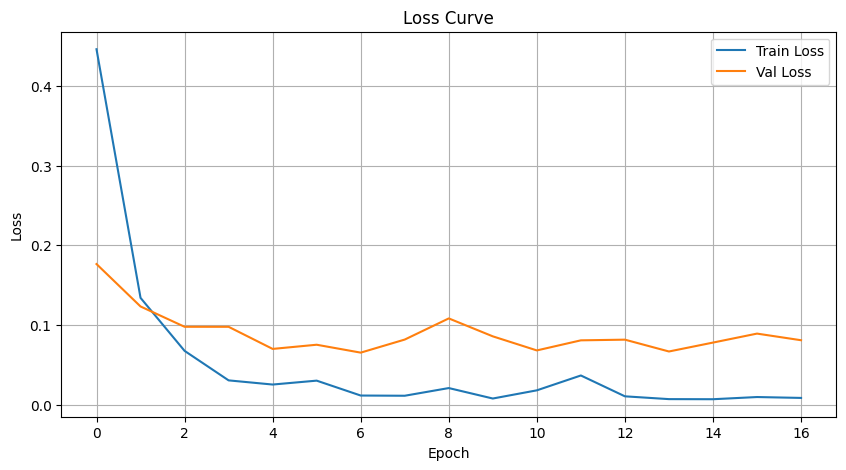

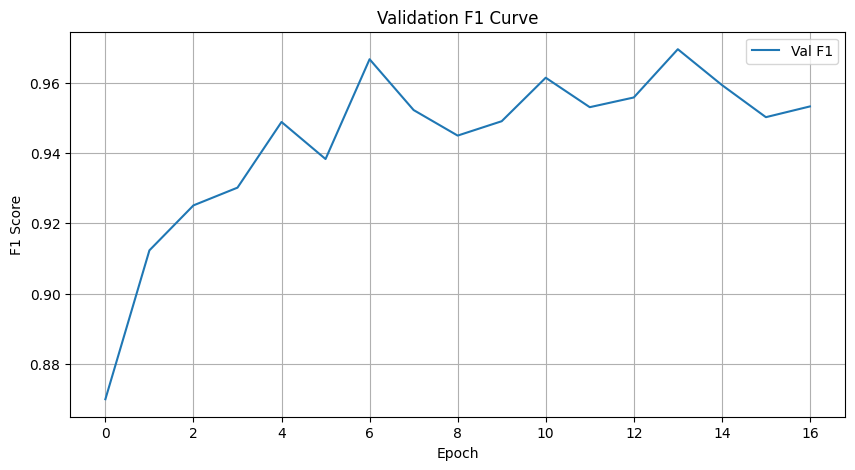

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(f1_scores, label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Curve")
plt.legend()
plt.grid()
plt.show()

In [43]:
# ResNetTransform evaluation
model_path = "E:/LSE/ST311/ST311-Group-Project/experiment/pure_mixed_res/res_1e_4_lr_f1_0.9667.pth"
model = load_model(model_path, ResNetClassifier, m_num_classes, device)

macro_map, macro_p, macro_r, macro_f1, p_class, r_class, f_class = evaluate_model(model, m_train_loader, m_index_to_label, criterion, device, threshold=0.1)

# save results to CSV
save_eval_results_to_csv(
    model_path,
    macro_map, macro_p, macro_r, macro_f1,
    p_class, r_class, f_class,
    list(m_label_to_index.keys())
)

Test Loss: 2.5057, mAP: 0.8176, Macro P: 0.8968, R: 0.6009, F1: 0.7038
Per-class F1:
  bird: P=0.986, R=0.467, F1=0.634
  cat: P=0.898, R=0.393, F1=0.547
  cow: P=0.797, R=0.885, F1=0.839
  dog: P=0.880, R=0.486, F1=0.626
  elephant: P=0.910, R=0.654, F1=0.761
  horse: P=0.931, R=0.508, F1=0.658
  lion: P=0.840, R=0.759, F1=0.797
  sheep: P=0.932, R=0.655, F1=0.769
Saved evaluation results to: E:\LSE\ST311\ST311-Group-Project\experiment\res_1e_4_lr_f1_0.9667_metrics.csv


## ResNet on combined dataset

In [ ]:
# Model
learning_rate = 1e-4
early_stop_patience = 10

model = ResNetClassifier(m_num_classes).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=m_pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model_save_dir = Path("E:/LSE/ST311/ST311-Group-Project/experiment/pure_mixed_res")
model_save_dir.mkdir(parents=True, exist_ok=True)
best_loss = float('inf')
patience_counter = 0

train_losses = []
val_losses = []
f1_scores = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, targets in loop:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=total_loss / (loop.n + 1))

    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_preds.append(outputs)
            all_targets.append(targets)

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    val_loss = criterion(all_preds, all_targets).item()
    macro_p, macro_r, macro_f1, macro_map, p_class, r_class, f_class = multilabel_metrics(all_preds, all_targets)

    print(f"Val Loss: {val_loss:.4f}, Map:{round(macro_map,4)}, Macro P: {macro_p:.4f}, R: {macro_r:.4f}, F1: {macro_f1:.4f}")
    print("Per-class F1:")
    for i, label in index_to_label.items():
        print(f"  {label}: P={p_class[i]:.3f}, R={r_class[i]:.3f}, F1={f_class[i]:.3f}")
        
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss)
    f1_scores.append(macro_f1)

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), model_save_dir / f"res_1e_4_lr_f1_{macro_f1:.4f}.pth")
        print("Saved best model.")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{early_stop_patience}")

    if patience_counter >= early_stop_patience:
        print("Early stopping.")
        break

## Evaluation

Two Stage Trained models

In [44]:
model_path = "E:/LSE/ST311/ST311-Group-Project/experiment/mixed_res/resnet_f1_0.9744.pth"
model = load_model(model_path, ResNetClassifier, m_num_classes, device)

macro_map, macro_p, macro_r, macro_f1, p_class, r_class, f_class = evaluate_model(model, m_test_loader, m_index_to_label, criterion, device, threshold=0.1)

# save results to CSV
save_eval_results_to_csv(
    model_path,
    macro_map, macro_p, macro_r, macro_f1,
    p_class, r_class, f_class,
    list(m_label_to_index.keys())
)

d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Loss: 3.2406, mAP: 0.8281, Macro P: 0.9432, R: 0.5870, F1: 0.7080
Per-class F1:
  bird: P=0.988, R=0.337, F1=0.502
  cat: P=0.888, R=0.518, F1=0.655
  cow: P=0.986, R=0.835, F1=0.904
  dog: P=0.975, R=0.398, F1=0.565
  elephant: P=0.921, R=0.688, F1=0.787
  horse: P=0.947, R=0.469, F1=0.628
  lion: P=0.920, R=0.708, F1=0.800
  sheep: P=0.922, R=0.743, F1=0.823
Saved evaluation results to: E:\LSE\ST311\ST311-Group-Project\experiment\resnet_f1_0.9744_metrics.csv


In [45]:
# Rest Trans evaluation
model_path = "E:/LSE/ST311/ST311-Group-Project/experiment/mixed_restran/resnet_tran_f1_0.9580.pth"
model = load_model(model_path, ResNetTransformerClassifier, m_num_classes, device)

macro_map, macro_p, macro_r, macro_f1, p_class, r_class, f_class = evaluate_model(model, m_test_loader, m_index_to_label, criterion, device, threshold=0.1)

# save results to CSV
save_eval_results_to_csv(
    model_path,
    macro_map, macro_p, macro_r, macro_f1,
    p_class, r_class, f_class,
    list(m_label_to_index.keys())
)

d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Loss: 2.9352, mAP: 0.7945, Macro P: 0.9049, R: 0.5671, F1: 0.6864
Per-class F1:
  bird: P=0.993, R=0.306, F1=0.468
  cat: P=0.879, R=0.459, F1=0.603
  cow: P=0.972, R=0.706, F1=0.818
  dog: P=0.862, R=0.496, F1=0.630
  elephant: P=0.934, R=0.633, F1=0.754
  horse: P=0.828, R=0.588, F1=0.687
  lion: P=0.880, R=0.645, F1=0.744
  sheep: P=0.891, R=0.704, F1=0.787
Saved evaluation results to: E:\LSE\ST311\ST311-Group-Project\experiment\resnet_tran_f1_0.9580_metrics.csv


Pure mixed audiso trained models

In [47]:
# ResNetTransform evaluation
model_path = "E:/LSE/ST311/ST311-Group-Project/experiment/pure_mixed_restran/restran_f1_0.9572.pth"
model = load_model(model_path, ResNetTransformerClassifier, m_num_classes, device)

macro_map, macro_p, macro_r, macro_f1, p_class, r_class, f_class = evaluate_model(model, m_test_loader, m_index_to_label, criterion, device, threshold=0.1)

# save results to CSV
save_eval_results_to_csv(
    model_path,
    macro_map, macro_p, macro_r, macro_f1,
    p_class, r_class, f_class,
    list(m_label_to_index.keys())
)

Test Loss: 2.7847, mAP: 0.7913, Macro P: 0.9035, R: 0.5663, F1: 0.6804
Per-class F1:
  bird: P=0.969, R=0.453, F1=0.618
  cat: P=0.892, R=0.437, F1=0.586
  cow: P=0.957, R=0.816, F1=0.881
  dog: P=0.915, R=0.265, F1=0.411
  elephant: P=0.878, R=0.663, F1=0.756
  horse: P=0.839, R=0.533, F1=0.652
  lion: P=0.915, R=0.639, F1=0.752
  sheep: P=0.862, R=0.724, F1=0.787
Saved evaluation results to: E:\LSE\ST311\ST311-Group-Project\experiment\restran_3e_5_lr_f1_0.9572_metrics.csv


In [48]:
# ResNet evaluation
model_path = "E:/LSE/ST311/ST311-Group-Project/experiment/pure_mixed_res/res_1e_4_lr_f1_0.9667.pth"
model = load_model(model_path, ResNetClassifier, m_num_classes, device)

macro_map, macro_p, macro_r, macro_f1, p_class, r_class, f_class = evaluate_model(model, m_test_loader, m_index_to_label, criterion, device, threshold=0.1)

# save results to CSV
save_eval_results_to_csv(
    model_path,
    macro_map, macro_p, macro_r, macro_f1,
    p_class, r_class, f_class,
    list(m_label_to_index.keys())
)

d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\miniconda\envs\st311_final\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Loss: 2.5236, mAP: 0.8173, Macro P: 0.9143, R: 0.5987, F1: 0.7039
Per-class F1:
  bird: P=0.985, R=0.410, F1=0.579
  cat: P=0.932, R=0.394, F1=0.554
  cow: P=0.818, R=0.918, F1=0.865
  dog: P=0.960, R=0.437, F1=0.600
  elephant: P=0.915, R=0.655, F1=0.763
  horse: P=0.918, R=0.547, F1=0.685
  lion: P=0.854, R=0.751, F1=0.799
  sheep: P=0.933, R=0.678, F1=0.785
Saved evaluation results to: E:\LSE\ST311\ST311-Group-Project\experiment\res_1e_4_lr_f1_0.9667_metrics.csv


ResNet has better performance than ResNetTransformer. Two-stage training gives higher precisions while direct train on mixed audio dataset makes the model more stable and having higher recall.

Overall, two-stage trained ResNetClassifier perform the best